In [ ]:
!pip install --upgrade pip
!pip install torch_geometric

In [ ]:
import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import torch_geometric

import timeit


from tqdm import tqdm
from sklearn import preprocessing
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, torch.__version__)


/Users/rozaabol/opt/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu 1.12.1


In [ ]:
from torch_scatter import scatter_mean, scatter_add

# Defining the Attention Mechanism as a Separate Class of itself
class AttentionLayer(torch.nn.Module):
    def __init__(self, d = 16, activation=2, a = 0.1):
        """
        :param: d: Output Dimension of the Node Embeddings
        :param: activation: The Activation Function to be used for the Attention Layer
        :param: a: Slope of the -ve part if the activation is Leaky ReLU
        """
        super(AttentionLayer, self).__init__()
        self.d = d # Output dimension of the Convolution Vector for each Node
        self.activation = activation
        self.a = a # Slope of the negative part in Leaky-ReLU

        self.params()
        self.initialize()

    def params(self):
        self.W_att = torch.nn.Parameter(torch.Tensor(self.d, self.d))

    def initialize(self):
        """
        Initialization depends upon the activation function used.
        If ReLU/ Leaky ReLU : He (Kaiming) Initialization
        If tanh/ sigmoid : Xavier Initialization
        0-ReLU, 1-Leaky ReLU, 2-tanh, 3-sigmoid
        """
        non_lin = {0:"relu", 1:"leaky_relu", 2:"tanh", 3:"sigmoid"}

        if (self.activation==1) or (self.activation==0):
            torch.nn.init.kaiming_normal_(self.W_att, a=self.a, nonlinearity=non_lin[self.activation])
        elif (self.activation==2) or (self.activation==3):
            torch.nn.init.xavier_normal_(self.W_att)
        else:
            raise ValueError("Activation can only take values 0,1,2,3!")

    def forward(self, node_embeddings, batch, size = None):
        """
        :param: node_embeddings :(N_B x D) Tensor containing Node Embeddings
        :param: batch : Tensor containing the Graph to which Each Node in the Batch belongs
        :param: size : Check Documentation https://pytorch-scatter.readthedocs.io/en/1.3.0/functions/mean.html
        :return: global_graph_embedding for each graph in the batch
        """
        size = batch[-1].item()+1 if size is None else size # Gives Batch Size = B

        global_context = scatter_mean(node_embeddings,index = batch, dim=0, dim_size = size) # (N_B,D) -> (B,D) (mean)
        global_context = torch.matmul(global_context, self.W_att) # (B,D) x (D,D) -> (B,D)

        # Applying the Non-Linearity over W_att*mean(U_i), the default is tanh
        if self.activation==2:
            global_context = torch.tanh(global_context)
        elif self.activation==1:
            leaky_relu = torch.nn.LeakyReLU()
            global_context = leaky_relu(global_context)
        elif self.activation==0:
            global_context = global_context.relu()
        elif self.activation==3:
            global_context = torch.sigmoid(global_context)

        # Getting the attention value for each Node for a Given Graph
        e = torch.sum(node_embeddings*global_context[batch], dim=1) # (N_B,D) * (N_B,D) -> (N_B,1) (due to sum along dimension D)
        attn_weights = e.sigmoid() # (N_B, 1)

        # Calculating the Global Graph Embedding
        global_graph_embedding = scatter_add(node_embeddings*attn_weights.unsqueeze(-1),
                                             index=batch, dim=0, dim_size=size) # (N_B,D) x (N_B,1) -> (B,D)

        return global_graph_embedding

# **2) Neural Tensor Network Layer**

In [ ]:
# Defining the Neural Tensor Network Layer as a Separate Class of Itself
class NTNLayer(torch.nn.Module):
    def __init__(self, d=16, k=16, activation=0, a = 0.1):
        """
        :param: d: Input Dimension of the NTN - i.e Dimension of the Graph/ Node Embeddings
        :param: k: Output Dimension of the NTN - No. of Similarity Scores to output
        :param: activation: Activation Function to be used for the NTN - Default = ReLU
        :param: a: Slope of the negative part for a Leaky ReLU activation
        """
        super(NTNLayer, self).__init__()
        self.d = d # Input Dimension of the NTN
        self.k = k # Output dimension of the NTN
        self.a = a # Slope in case of Leaky ReLU initialization
        self.activation = activation
        self.params()
        self.initialize()

    def params(self):
        self.W = torch.nn.Parameter(torch.Tensor(self.d,self.d,self.k))
        self.V = torch.nn.Parameter(torch.Tensor(self.k, 2*self.d))
        self.b = torch.nn.Parameter(torch.Tensor(self.k,1))

    def initialize(self):
        """
        Initialization depends upon the activation function used.
        If ReLU/ Leaky ReLU : He Initialization
        If tanh/ sigmoid : Xavier Initialization
        0-ReLU, 1-Leaky ReLU, 2-tanh, 3-sigmoid
        """
        non_lin = {0:"relu", 1:"leaky_relu", 2:"tanh", 3:"sigmoid"}
        if (self.activation==1) or (self.activation==0):
            torch.nn.init.kaiming_normal_(self.W, a=self.a, nonlinearity=non_lin[self.activation])
            torch.nn.init.kaiming_normal_(self.V, a=self.a, nonlinearity=non_lin[self.activation])
            torch.nn.init.kaiming_normal_(self.b, a=self.a, nonlinearity=non_lin[self.activation])

        elif (self.activation==2) or (self.activation==3):
            torch.nn.init.xavier_normal_(self.W)
            torch.nn.init.xavier_normal_(self.V)
            torch.nn.init.xavier_normal_(self.b)

        else:
            raise ValueError("Activation can only take values 0,1,2,3!")

    def forward(self, h1, h2):
        """Returns 'K' Rough Similarity Scores between the Pair of Graphs
        The Neural Tensor Network (NTN) outputs 'K' similarity scores where 'K' is a hyperparameter
        :param: h1 : Graph Embedding of Graph 1 - (B,D)
        :param: h2 : Graph Embedding of Graph 2 - (B,D)
        """
        B,_ = h1.shape
        scores = torch.mm(h1, self.W.view(self.d, -1)) # (B,D) x (D, K+D) -> (B, K+D)
        scores = scores.view(B,self.d,self.k) # (B,K+D) -> (B,D,K)
        scores = (scores*h2.unsqueeze(-1)).sum(dim=1) # (B,D,K) * (B,D,1) -> (B,K)

        concatenated_rep = torch.cat((h1, h2), dim=1) # (B,2D)
        scores = scores + torch.mm(concatenated_rep, self.V.t()) # (B,2D) x (2D,K) -> (B,K)
        scores = scores + self.b.t() # (B,K) + (1,K) = (B,K)

        if self.activation==0:
            scores = scores.relu()
            return scores
        elif self.activation==1:
            leaky_relu = torch.nn.LeakyReLU()
            scores = leaky_relu(scores)
            return scores
        elif self.activation==2:
            scores = torch.tanh(scores)
            return scores
        elif self.activation==3:
            scores = torch.sigmoid(scores)
            return scores
        else:
            raise ValueError("Activation can only take values 0,1,2,3!")

# **3) SimGNN - Putting it Together**

In [ ]:
# Writing the Entire SimGNN Model
from torch_geometric.utils import to_dense_batch, to_dense_adj
from torch_geometric.nn import GCNConv
from torch.nn import Linear

class SimGNN(torch.nn.Module):
    def __init__(self, num_node_features, hist=True, ntn_layer=True, d=16, k=16, bins = 16):
        super(SimGNN, self).__init__()
        self.setupHyperParams(hist, ntn_layer, d, k, bins, num_node_features)
        self.setupLayers()

    def setupHyperParams(self, hist, ntn_layer, d, k, bins, num_node_features):
        self.num_node_features = num_node_features
        # Dimension of the Node/ Graph Embeddding
        self.d = d
        # Output Dimension of the NTN
        self.k = k
        # Do we want to include the NTN Layer in the pipeline
        self.ntn_layer = ntn_layer
        # Do we want to use the histogram strategy
        self.hist = hist
        # No. of Bins to be used for the Histogram
        self.bins = bins

    def fcnnInputDim(self):
        """Calculate The Input Dimension of the FCNN Layer"""
        if self.hist and self.ntn_layer:
            return self.bins+self.k
        elif self.hist:
            return self.bins + 1
        elif self.ntn_layer:
            return self.k
        else :
            # Instead of NTN ,we would just be using a simple rbf kernel
            # between the Graph Embeddings to Compute Similarities
            return 1

    def setupLayers(self):
        fcnn_input_dim = self.fcnnInputDim()

        # Layers of SimGNN
        # GCN Layers
        self.conv1 = GCNConv(self.num_node_features,64)
        self.conv2 = GCNConv(64,32)
        self.conv3 = GCNConv(32,self.d)

        # Attention Layer and Neural Tensor Network Layer
        self.attention_layer = AttentionLayer(self.d)
        self.NTN = NTNLayer(self.d, self.k)

        # Fully Connected Layer
        self.linear_1 = torch.nn.Linear(fcnn_input_dim,16)
        self.linear_2 = torch.nn.Linear(16,8)
        self.linear_3 = torch.nn.Linear(8,10)
        self.linear_4 = torch.nn.Linear(10,1)

    def GCN(self, x, edge_index):
        """
        Implementing the Graph Convolutional Network
        :param x : One Hot Encoded Feature Representation of the Nodes
        :param edge_index : Tensor Representation of Edges to calculate Adjacency Matrix
        :U : (N_B x D) matrix of Node Embeddings
        :N_B : Total No. of Nodes in the Batch (irrespective of parent graph)
        :D : dimensions of the Node Embeddings (decided by us)
        I haven't implemented Dropout/ BatchNorm but can also try to do that
        """
        U = self.conv1(x, edge_index)
        U = U.relu()
        U = self.conv2(U, edge_index)
        U = U.relu()
        U = self.conv3(U, edge_index)
        return U

    def kernel(self, graph_embedding_1, graph_embedding_2):
        pass

    def rbf_kernel_sim(self, graph_embedding_1, graph_embedding_2):
        """
        :param: graph_embedding_1 : (B,D) dimensional graph embedding
        :param: graph_embedding_2 : (B,D) dimensional graph embedding
        :return: rbf_sim : RBF Kernel Similarity the two graph embeddings
        """
        distance = graph_embedding_1-graph_embedding_2
        distance = torch.sum(distance*distance, dim = 1)
        # return (1/distance).view(-1,1)
        return torch.exp(-distance).view(-1,1)

    def histogram(self, U1, U2, batch1, batch2):
        """ B = Batch Size
        To calculate the Histogram Representation of the Pairwise Interaction Tensor
        :param: U1 : (N_B1 x D) matrix which encodes the node embeddings of Graph 1
        :param: U2 : (N_B2 x D) matrix which encodes the node embeddings of Graph 2
        :param: batch1 : Logs the Parent graph of the Nodes
        :param: batch2 : Logs the Parent Graph of the Nodes
        :return: norm_hist_scores : (B x self.bins) Normalized histogram for each batch
        """
        # Convert U1 and U2 into Dense Matrices
        U1, mask1 = to_dense_batch(U1, batch1) # (B, N_max1, D); (B, N_max1)
        U2, mask2 = to_dense_batch(U2, batch2) # (B, N_max2, D); (B, N_max2)
        B, N_max1, _ = U1.size()
        B, N_max2, _ = U2.size()

        # Max Number of Nodes for Each Graph Pair in the Batch
        max_total_nodes = torch.max(mask1.sum(dim=1), mask2.sum(dim=1)).view(-1) # (B,1)

        # Calculating Interaction Scores for the entire batch
        interaction_scores = torch.matmul(U1, U2.permute(0,2,1)).detach() # (B, N_max1, N_max2)
        interaction_scores = torch.sigmoid(interaction_scores)

        # Getting the Histogram for each Pair in the batch
        hist_score_list = []
        for i in range(B):
            interaction_matrix = interaction_scores[:,:max_total_nodes[i], :max_total_nodes[i]]
            hist_score = torch.histc(interaction_matrix, bins = self.bins).view(-1) # (self.bins,)
            hist_score = hist_score/hist_score.sum() # Normalizing the Histogram
            hist_score_list.append(hist_score)

        return torch.stack(hist_score_list).view(B, self.bins) # (B, self.bins)

    def FCNN(self, x):
        """:param: x: Rough Similarity Scores of 'B' Graph Pairs where B is Batch Size"""
        ged_sim = self.linear_1(x)
        ged_sim = ged_sim.relu()

        ged_sim = self.linear_2(ged_sim)
        ged_sim = ged_sim.relu()

        ged_sim = self.linear_3(ged_sim)
        ged_sim = ged_sim.relu()
        ged_sim = self.linear_4(ged_sim)
#        last_layer = self.linear_4(ged_sim)
        return ged_sim.sigmoid()
#        raw_output = self.linear_4(ged_sim)
#        return  raw_output.sigmoid()


    def forward(self, data):
        """
         Forward pass with graphs.
         :param data: A Batch Containing a Pair of Graphs.
         :return score: Similarity score.
         """
        edge_index_1 = data.edge_index_1
        edge_index_2 = data.edge_index_2
        x1, x2 = data.x1, data.x2
        x1_batch , x2_batch = data.x1_batch, data.x2_batch

        # Passed through GCN
        node_embeddings_1 = self.GCN(x1, edge_index_1)
        node_embeddings_2 = self.GCN(x2, edge_index_2)

        # Passed through Attention Layer to get Graph Embedding
        graph_embedding_1 = self.attention_layer(node_embeddings_1, x1_batch)
        graph_embedding_2 = self.attention_layer(node_embeddings_2, x2_batch)

        # Passed through Neural Tensor Network if allowed otherwise just take a simple Inner Product
        if self.ntn_layer:
            scores = self.NTN(graph_embedding_1, graph_embedding_2)
        else:
            scores = self.rbf_kernel_sim(graph_embedding_1, graph_embedding_2)

        # Computed Histogram from the Node Embeddings (Strategy 2)
        if self.hist:
            hist = self.histogram(node_embeddings_1, node_embeddings_2, x1_batch, x2_batch)
            scores = torch.cat((scores, hist), dim=1) # (B, K+self.bins)

        # Pass through the Fully Connected Neural Network Layer to get Graph Edit Distance Similarity
        sim_pred = self.FCNN(scores)

        return sim_pred.view(-1)

# **4) Loading Data & Feature Engineering**

In [ ]:
#name = "LINUX"
#from torch_geometric.datasets import GEDDataset
#train_graphs = GEDDataset(root="./data_/train", train = True, name=name)
#test_graphs = GEDDataset(root="./data_/test", train = False, name=name)

#print(f"Number of Graphs in Train Set : {len(train_graphs)}")
#print(f"Number of Graphs in Test Set : {len(test_graphs)}")

In [ ]:
#### ******* I added this part (to make smaller dataset)********
#name = "LINUX"
#from torch_geometric.datasets import GEDDataset
#train_graphs = GEDDataset(root="./data_/train", train = True, name=name)#[0:20]
#test_graphs = GEDDataset(root="./data_/test", train = False, name=name)#[0:5]

#print(f"Number of Graphs in Train Set : {len(train_graphs)}")
#print(f"Number of Graphs in Test Set : {len(test_graphs)}")


## **a)Loading data**

In [ ]:
# Loading the Food dataset by PMovie_num = 6
User_num = 20
Item_num = 6
ComparisonMatrix = np.zeros((User_num, Item_num, Item_num))
ComparisonMatrix[0][:][:] = pd.read_csv("./FoodData_Pedro/2021101309.1/direct/adrian1.csv", index_col=0).to_numpy()
ComparisonMatrix[1][:][:] = pd.read_csv("./FoodData_Pedro/2021101309.1/direct/anis1.csv", index_col=0).to_numpy()
ComparisonMatrix[2][:][:] = pd.read_csv("./FoodData_Pedro/2021101309.1/direct/kristian1.csv", index_col=0).to_numpy()
ComparisonMatrix[3][:][:] = pd.read_csv("./FoodData_Pedro/2021101309.1/direct/pedro1.csv", index_col=0).to_numpy()
ComparisonMatrix[4][:][:] = pd.read_csv("./FoodData_Pedro/2021101309.1/direct/random1.csv", index_col=0).to_numpy()

ComparisonMatrix[5][:][:] = pd.read_csv("./FoodData_Pedro/2021101309.1/indirect/adrian2.csv", index_col=0).to_numpy()
ComparisonMatrix[6][:][:] = pd.read_csv("./FoodData_Pedro/2021101309.1/indirect/anis2.csv", index_col=0).to_numpy()
ComparisonMatrix[7][:][:] = pd.read_csv("./FoodData_Pedro/2021101309.1/indirect/kristian2.csv", index_col=0).to_numpy()
ComparisonMatrix[8][:][:] = pd.read_csv("./FoodData_Pedro/2021101309.1/indirect/pedro2.csv", index_col=0).to_numpy()
ComparisonMatrix[9][:][:] = pd.read_csv("./FoodData_Pedro/2021101309.1/indirect/random2.csv", index_col=0).to_numpy()

ComparisonMatrix[10][:][:] = pd.read_csv("./FoodData_Pedro/2021101309.2/direct/adrian1.csv", index_col=0).to_numpy()
ComparisonMatrix[11][:][:] = pd.read_csv("./FoodData_Pedro/2021101309.2/direct/anis1.csv", index_col=0).to_numpy()
ComparisonMatrix[12][:][:] = pd.read_csv("./FoodData_Pedro/2021101309.2/direct/kristian1.csv", index_col=0).to_numpy()
ComparisonMatrix[13][:][:] = pd.read_csv("./FoodData_Pedro/2021101309.2/direct/pedro1.csv", index_col=0).to_numpy()
ComparisonMatrix[14][:][:] = pd.read_csv("./FoodData_Pedro/2021101309.2/direct/random1.csv", index_col=0).to_numpy()

ComparisonMatrix[15][:][:] = pd.read_csv("./FoodData_Pedro/2021101309.2/indirect/adrian2.csv", index_col=0).to_numpy()
ComparisonMatrix[16][:][:] = pd.read_csv("./FoodData_Pedro/2021101309.2/indirect/anis2.csv", index_col=0).to_numpy()
ComparisonMatrix[17][:][:] = pd.read_csv("./FoodData_Pedro/2021101309.2/indirect/kristian2.csv", index_col=0).to_numpy()
ComparisonMatrix[18][:][:] = pd.read_csv("./FoodData_Pedro/2021101309.2/indirect/pedro2.csv", index_col=0).to_numpy()
ComparisonMatrix[19][:][:] = pd.read_csv("./FoodData_Pedro/2021101309.2/indirect/random2.csv", index_col=0).to_numpy()

filename = "prefs_FoodData.csv"
with open(filename, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    header = ["User_ID", "Item1_ID", "Item2_ID"]
    writer.writerow(header)

    for user in range(User_num):
        for item1 in range(Item_num):
            for item2 in range(item1+1, Item_num):
                if ComparisonMatrix[user][item1][item2] > 0.5:
                    List = [user+1, item1+1 ,item2+1]
                else:
                    List = [user+1, item2+1, item1+1]
                writer.writerow(List)

print(ComparisonMatrix[8])

[[0.5  0.5  0.35 0.23 0.23 0.27]
 [0.5  0.5  0.23 0.22 0.3  0.22]
 [0.65 0.77 0.5  0.22 0.32 0.31]
 [0.77 0.78 0.78 0.5  0.28 0.28]
 [0.77 0.7  0.68 0.72 0.5  0.31]
 [0.73 0.78 0.69 0.72 0.69 0.5 ]]




## **b) Creating Data objects (Graphs)**

In [ ]:
##***
"""List of parameters:  https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#module-torch_geometric.data
x (Tensor, optional) – Node feature matrix with shape [num_nodes, num_node_features]. (default: None)
edge_index (LongTensor, optional) – Graph connectivity in COO format with shape [2, num_edges]. (default: None)
edge_attr (Tensor, optional) – Edge feature matrix with shape [num_edges, num_edge_features]. (default: None)
y (Tensor, optional) – Graph-level or node-level ground-truth labels with arbitrary shape. (default: None)
pos (Tensor, optional) – Node position matrix with shape [num_nodes, num_dimensions]. (default: None)
"""
from torch_geometric.data import Data
import random

num_items = 6
num_nodes = num_items
num_users = 20
pr_train = 80 #percentage of number of training data
train_graphs = []
test_graphs = []
DS_graphs = []

#Original data
Dataset_Edges = pd.read_csv("./prefs_FoodData.csv") ##Food Dataset_Pair items
Dataset_Node_features = pd.read_csv("./FoodData_Pedro/items_FoodData.csv") ##Food Dataset_item features

Dataset_Node_features.drop("Item_ID", axis=1, inplace=True) #removing the index of items from the features
Nodes_FeatureMatrix = Dataset_Node_features.values.tolist()
num_node_features = len(Nodes_FeatureMatrix[0])
x = torch.tensor(Nodes_FeatureMatrix, dtype=torch.float) #Node feature matrix with shape [num_nodes, num_node_features]
#
old_user = 0
idx_train = 0
idx_test = 0
for index, row in Dataset_Edges.iterrows():
    current_user = row.User_ID    #CarData.User_ID[index]
    if old_user != current_user:
        if current_user >1 and current_user <= num_users :
            # Saving graph of the user
            # Info:https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html
            edge_index = torch.tensor(Edges_matrix, dtype=torch.long) -1 #Graph connectivity in COO format with shape [2, num_edges]. (default: None)
            data = Data(edge_index=edge_index, num_nodes=num_nodes, num_features=num_node_features ,x=x)

            if idx_train < num_users * (5/6): ##random.randint(0,100) < pr_train:
                train_graphs.append(data)
                DS_graphs.append(data)
                idx_train +=1
            else:
                test_graphs.append(data)
                DS_graphs.append(data)
        # starting a new user:
        num_edges = Dataset_Edges.User_ID.tolist().count(current_user)
        Edges_matrix = np.zeros((2, num_edges)) ##empty
        edg = 0 ## edge
    item1 = row.Item1_ID    #CarData.Item1_ID[index]
    item2 = row.Item2_ID    #CarData.Item2_ID[index]
    Edges_matrix [0][edg]= row.Item1_ID
    Edges_matrix [1][edg]= row.Item2_ID
    edg+=1
    old_user = current_user

# Saving last graph user
edge_index = torch.tensor(Edges_matrix, dtype=torch.long)-1 #Graph connectivity in COO format with shape [2, num_edges]. (default: None)
data = Data(edge_index=edge_index, num_nodes=num_nodes, num_features=num_node_features  ,x=x)

test_graphs.append(data)
DS_graphs.append(data)

In [ ]:
print(old_user)
edg = 0
num_edges = Dataset_Edges.User_ID.tolist().count(current_user)
Edges_matrix = np.zeros((2, num_edges))

20


In [ ]:
##***

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

Dataset_graphs = train_graphs+ test_graphs

In [ ]:

print(train_graphs[10])

print("Number of Training Graphs = {}".format(len(train_graphs)))
print("Number of Testing Graphss = {}".format(len(test_graphs)))
print("Number of whole Graphss = {}".format(len(Dataset_graphs)))
print (DS_graphs==Dataset_graphs)  ####You can remove DS_graphs later

Data(x=[6, 4], edge_index=[2, 15], num_nodes=6, num_features=4)
Number of Training Graphs = 17
Number of Testing Graphss = 3
Number of whole Graphss = 20
True


In [ ]:
print(train_graphs[0].edge_index)

tensor([[1, 2, 0, 4, 5, 2, 3, 4, 5, 2, 4, 5, 4, 5, 5],
        [0, 0, 3, 0, 0, 1, 1, 1, 1, 3, 2, 2, 3, 3, 4]])


## **c) Creating a Feature Matrix for the Graphs**

In [ ]:
from torch_geometric.transforms import OneHotDegree
from torch_geometric.utils import degree

# If the dataset does not have a feature matrix, we create one!
# Only the AIDS700nef Dataset has an inbuilt feature matrix
# We create a One Hot Encoded Degree Feature Matrix
if train_graphs[0].x is None:
            max_degree = 0
            for graph in train_graphs + test_graphs:
                # If this graph has edges then do
                if graph.edge_index.size(1) > 0:
                    max_degree = max(max_degree, int(degree(graph.edge_index[0]).max().item()))

            # Create the feature matrix for the Dataset
            one_hot_degree = OneHotDegree(max_degree, cat=False)
            train_graphs.transform = one_hot_degree
            test_graphs.transform = one_hot_degree

num_node_features = train_graphs[0].num_features ##**
num_edge_features = train_graphs[0].num_edge_features ##**
print(num_node_features, num_edge_features)

4 0


## **d) Similarity between the praphs**

In [ ]:
## **Similarity**  A function which takes two inputs and returns theis similarity as a number.
# In "Recommendation systems", one measure for similarity between two users is to find the distance between their top-k most prefered items

# Item_scores_matrix is a matrix which rows are users and columns are items. Entries indicte how much the user likes this item more than the other items.
Item_scores_matrix = np.zeros((num_users, num_items))
for index, row in Dataset_Edges.iterrows():
    user = row.User_ID    #CarData.User_ID[index]
    item1 = row.Item1_ID    #CarData.Item1_ID[index]
    item2 = row.Item2_ID    #CarData.Item2_ID[index]
    Item_scores_matrix[user-1][item1-1] += 1


# Normalizing the scores
Personalized_Item_scores_matrix = np.zeros((num_users, num_items))
for user in range(num_users):
    Personalized_Item_scores_matrix[user] = Item_scores_matrix[user]/ (num_items)




## **e) Making Pairs of Graphs**

In [ ]:
class makeGraphPairs(torch_geometric.data.Data):
    """
    :param: edge_index_1 : Edge Index of the First Graph
    :param: edge_index_2 : Edge Index of the Second Graph in the pair
    :param: x_1 : Feature Matrix of the First Graph in the Pair
    :param: x_2 : Feature Matrix of the Second Graph in the Pair

    :returns: torch_geometric.data.Data object which comprises two graphs
    """
    def __init__(self, edge_index_1, x1, edge_index_2, x2, graph_sim):#, ged, norm_ged):##**
        super(makeGraphPairs, self).__init__()
        self.edge_index_1 = edge_index_1
        self.x1 = x1
        self.edge_index_2 = edge_index_2
        self.x2 = x2
        #self.ged = ged ##*
        #self.norm_ged = norm_ged ##*
        self.graph_sim = graph_sim ##*


    def __inc__(self, key, value,*rest): ## I added *rest
        if key == "edge_index_1":
            return self.x1.size(0)
        elif key == "edge_index_2":
            return self.x2.size(0)
        else:
            return super().__inc__(key, value)## I added *rest

In [ ]:
 ## **Similarity**  A function which takes two inputs and returns their similarity as a number.
 # Here, similarity is the intersect of top ranled items for two users.

def sim_TopK (x, y):
    #Indices1 = (-Personalized_Item_scores_matrix[user1.idx]).argsort()[:3] # Index of 3-best items (Culd use this one as well.)
    Personalized_Item_scores1 = np.zeros((num_items))
    Personalized_Item_scores2 = np.zeros((num_items))
    for item in range(num_items):
        Personalized_Item_scores1[item] =  x[0].tolist().count(item)/num_items # Personalized item score: (How many times i item prefered / num_items)
        Personalized_Item_scores2[item] =  y[0].tolist().count(item)/num_items
    print(Personalized_Item_scores1)
    print(Personalized_Item_scores2)
    # number of items with score more than n:
    n = 0.2
    Indices1 = [i for i,v in enumerate(Personalized_Item_scores1) if v >= n]
    Indices2 = [j for j,h in enumerate(Personalized_Item_scores2) if h >= n]
    print(Indices1)
    print(Indices2)
    graph_sim = len(np.intersect1d(Indices1,Indices2))/((len(Indices1)+len(Indices2))/2) #Min-max normalization on number of intersection of the preferences
    return graph_sim


In [ ]:

x = train_graphs[2].edge_index
y = train_graphs[0].edge_index
print(x)
print(sim_TopK (x, y))

tensor([[1, 0, 0, 0, 5, 2, 3, 1, 1, 2, 4, 5, 3, 3, 4],
        [0, 2, 3, 4, 0, 1, 1, 4, 5, 3, 2, 2, 4, 5, 5]])
[0.5        0.5        0.33333333 0.5        0.33333333 0.33333333]
[0.16666667 0.16666667 0.5        0.16666667 0.66666667 0.83333333]
[0, 1, 2, 3, 4, 5]
[2, 4, 5]
0.6666666666666666


In [ ]:
 ## **Similarity**  A function which takes two inputs and returns theis similarity as a number.
 # Here, similarity is the intersect of top ranled items for two users.

def sim_GED (x, y):
    # Number of similar edges
    x_pairs = list(zip(x[0],x[1]))
    y_pairs = list(zip(y[0],y[1]))


    graph_sim = len([l for l in x_pairs if l in y_pairs]) /(np.max([len(x_pairs), len(y_pairs)]))
    return graph_sim



In [ ]:

i = train_graphs[0].edge_index.tolist()[0]
j = train_graphs[0].edge_index.tolist()[1]
print(i)
print(j)
print("\n")
pairs = list(zip(i,j))
print(pairs)
print("\n")

ii = train_graphs[1].edge_index.tolist()[0]
jj = train_graphs[1].edge_index.tolist()[1]
print(ii)
print(jj)
print("\n")
pairs2 = list(zip(ii,jj))
print(pairs2)


print("\n")
print(np.intersect1d(pairs, pairs2, assume_unique=False,))
print(np.intersect1d(pairs[0], pairs2[0], assume_unique=False,))
pairs[0]==pairs2[0]

len([l for l in pairs if l in pairs2])

[1, 2, 0, 4, 5, 2, 3, 4, 5, 2, 4, 5, 4, 5, 5]
[0, 0, 3, 0, 0, 1, 1, 1, 1, 3, 2, 2, 3, 3, 4]


[(1, 0), (2, 0), (0, 3), (4, 0), (5, 0), (2, 1), (3, 1), (4, 1), (5, 1), (2, 3), (4, 2), (5, 2), (4, 3), (5, 3), (5, 4)]


[0, 2, 0, 4, 0, 2, 1, 4, 1, 2, 4, 2, 4, 3, 5]
[1, 0, 3, 0, 5, 1, 3, 1, 5, 3, 2, 5, 3, 5, 4]


[(0, 1), (2, 0), (0, 3), (4, 0), (0, 5), (2, 1), (1, 3), (4, 1), (1, 5), (2, 3), (4, 2), (2, 5), (4, 3), (3, 5), (5, 4)]


[0 1 2 3 4 5]
[0 1]


9

In [ ]:
## Hazf kon.
x=train_graphs[10].edge_index
y=train_graphs[10].edge_index

print(sim_GED(x,y))

1.0


In [ ]:
# Choose the similarity function here:
## **Similarity**  A function which takes two inputs and returns theis similarity as a number.


#Simimilarity_Function = sim_TopK(edge_index_1, edge_index_2)
#Simimilarity_Function = sim_GED(edge_index_1, edge_index_2)

### **i. For Training**

In [ ]:
"""TRAINING SET PAIR"""
# Data List to pass into the Data Loader to get Batches
train_graph_pair_list = []


# Making the Pairs of Graphs
for graph1_num, graph1 in enumerate(train_graphs):
    for graph2 in train_graphs:
        # Initializing Data
        edge_index_1 = graph1.edge_index
        x1 = graph1.x
        edge_index_2 = graph2.edge_index
        x2 = graph2.x

        #ged = train_graphs.ged[graph1, graph2] ##**
        #norm_ged = train_graphs.norm_ged[graph1.i, graph2.i]##**
        #graph_sim = torch.exp(-norm_ged)##**
        #ged=128         ##**
        #norm_ged=128   ##**
        #graph_sim=128  ##**

        #Choose one on these similarity functions as the ground truth:
        graph_sim =  sim_TopK (edge_index_1, edge_index_2)  ##**
        #graph_sim = sim_GED (edge_index_1, edge_index_2)  ##**

        # Making Graph Pair
        graph_pair = makeGraphPairs(edge_index_1=edge_index_1, x1=x1,
                                    edge_index_2=edge_index_2, x2=x2, graph_sim = graph_sim)#,ged=ged ,norm_ged=norm_ged , graph_sim = graph_sim) ##*

        # Saving all the Graph Pairs to the List for Batching and Data Loading
        train_graph_pair_list.append(graph_pair)

[0.16666667 0.16666667 0.5        0.16666667 0.66666667 0.83333333]
[0.16666667 0.16666667 0.5        0.16666667 0.66666667 0.83333333]
[2, 4, 5]
[2, 4, 5]
[0.16666667 0.16666667 0.5        0.16666667 0.66666667 0.83333333]
[0.5        0.33333333 0.66666667 0.16666667 0.66666667 0.16666667]
[2, 4, 5]
[0, 1, 2, 4]
[0.16666667 0.16666667 0.5        0.16666667 0.66666667 0.83333333]
[0.5        0.5        0.33333333 0.5        0.33333333 0.33333333]
[2, 4, 5]
[0, 1, 2, 3, 4, 5]
[0.16666667 0.16666667 0.5        0.16666667 0.66666667 0.83333333]
[0.83333333 0.66666667 0.5        0.33333333 0.16666667 0.        ]
[2, 4, 5]
[0, 1, 2, 3]
[0.16666667 0.16666667 0.5        0.16666667 0.66666667 0.83333333]
[0.         0.83333333 0.16666667 0.5        0.66666667 0.33333333]
[2, 4, 5]
[1, 3, 4, 5]
[0.16666667 0.16666667 0.5        0.16666667 0.66666667 0.83333333]
[0.         0.33333333 0.33333333 0.5        0.66666667 0.66666667]
[2, 4, 5]
[1, 2, 3, 4, 5]
[0.16666667 0.16666667 0.5        0.1666

[0.         0.66666667 0.16666667 0.83333333 0.5        0.33333333]
[0.5        0.5        0.33333333 0.5        0.33333333 0.33333333]
[1, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0.         0.66666667 0.16666667 0.83333333 0.5        0.33333333]
[0.83333333 0.66666667 0.5        0.33333333 0.16666667 0.        ]
[1, 3, 4, 5]
[0, 1, 2, 3]
[0.         0.66666667 0.16666667 0.83333333 0.5        0.33333333]
[0.         0.83333333 0.16666667 0.5        0.66666667 0.33333333]
[1, 3, 4, 5]
[1, 3, 4, 5]
[0.         0.66666667 0.16666667 0.83333333 0.5        0.33333333]
[0.         0.33333333 0.33333333 0.5        0.66666667 0.66666667]
[1, 3, 4, 5]
[1, 2, 3, 4, 5]
[0.         0.66666667 0.16666667 0.83333333 0.5        0.33333333]
[0.         0.5        0.33333333 0.5        0.83333333 0.33333333]
[1, 3, 4, 5]
[1, 2, 3, 4, 5]
[0.         0.66666667 0.16666667 0.83333333 0.5        0.33333333]
[0.16666667 0.33333333 0.66666667 0.83333333 0.33333333 0.16666667]
[1, 3, 4, 5]
[1, 2, 3, 4]
[0.         0.66

[0.         0.33333333 0.33333333 0.5        0.66666667 0.66666667]
[0.5        0.33333333 0.66666667 0.16666667 0.66666667 0.16666667]
[1, 2, 3, 4, 5]
[0, 1, 2, 4]
[0.         0.33333333 0.33333333 0.5        0.66666667 0.66666667]
[0.5        0.5        0.33333333 0.5        0.33333333 0.33333333]
[1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0.         0.33333333 0.33333333 0.5        0.66666667 0.66666667]
[0.83333333 0.66666667 0.5        0.33333333 0.16666667 0.        ]
[1, 2, 3, 4, 5]
[0, 1, 2, 3]
[0.         0.33333333 0.33333333 0.5        0.66666667 0.66666667]
[0.         0.83333333 0.16666667 0.5        0.66666667 0.33333333]
[1, 2, 3, 4, 5]
[1, 3, 4, 5]
[0.         0.33333333 0.33333333 0.5        0.66666667 0.66666667]
[0.         0.33333333 0.33333333 0.5        0.66666667 0.66666667]
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5]
[0.         0.33333333 0.33333333 0.5        0.66666667 0.66666667]
[0.         0.5        0.33333333 0.5        0.83333333 0.33333333]
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5

### **ii. For Testing**

In [ ]:
"""TEST SET PAIR"""
# Data List to pass into the Data Loader to get batches
test_graph_pair_list = []

# Making the Pairs of Graphs

for graph1 in test_graphs:
    for graph2 in train_graphs:
        # Initializing Data
        edge_index_1 = graph1.edge_index
        x1 = graph1.x
        edge_index_2 = graph2.edge_index
        x2 = graph2.x
        #ged = train_graphs.ged[graph1.i, graph2.i] ##**
        #norm_ged = train_graphs.norm_ged[graph1.i, graph2.i]##**
        #graph_sim = torch.exp(-norm_ged)##**
        #ged=128         ##**
        #norm_ged=128   ##**
        #graph_sim=128  ##**

        #Choose one on these similarity functions as the ground truth:
        graph_sim =  sim_TopK (edge_index_1, edge_index_2)  ##**
        #graph_sim = sim_GED (edge_index_1, edge_index_2)  ##**

        # Making Graph Pair
        graph_pair = makeGraphPairs(edge_index_1=edge_index_1, x1=x1,
                                    edge_index_2=edge_index_2, x2=x2, graph_sim = graph_sim)#, ged=ged ,norm_ged=norm_ged)

        # Saving all the Graph Pairs to the List for Batching and Data Loading
        test_graph_pair_list.append(graph_pair)


[0.16666667 0.33333333 0.5        0.66666667 0.66666667 0.16666667]
[0.16666667 0.16666667 0.5        0.16666667 0.66666667 0.83333333]
[1, 2, 3, 4]
[2, 4, 5]
[0.16666667 0.33333333 0.5        0.66666667 0.66666667 0.16666667]
[0.5        0.33333333 0.66666667 0.16666667 0.66666667 0.16666667]
[1, 2, 3, 4]
[0, 1, 2, 4]
[0.16666667 0.33333333 0.5        0.66666667 0.66666667 0.16666667]
[0.5        0.5        0.33333333 0.5        0.33333333 0.33333333]
[1, 2, 3, 4]
[0, 1, 2, 3, 4, 5]
[0.16666667 0.33333333 0.5        0.66666667 0.66666667 0.16666667]
[0.83333333 0.66666667 0.5        0.33333333 0.16666667 0.        ]
[1, 2, 3, 4]
[0, 1, 2, 3]
[0.16666667 0.33333333 0.5        0.66666667 0.66666667 0.16666667]
[0.         0.83333333 0.16666667 0.5        0.66666667 0.33333333]
[1, 2, 3, 4]
[1, 3, 4, 5]
[0.16666667 0.33333333 0.5        0.66666667 0.66666667 0.16666667]
[0.         0.33333333 0.33333333 0.5        0.66666667 0.66666667]
[1, 2, 3, 4]
[1, 2, 3, 4, 5]
[0.16666667 0.33333333

In [ ]:
"""Whole Data SET PAIR"""
# Data List to pass into the Data Loader to get Batches
Dataset_graph_pair_list = []


# Making the Pairs of Graphs
for graph1_num, graph1 in enumerate(DS_graphs):
    for graph2 in DS_graphs:
        # Initializing Data
        edge_index_1 = graph1.edge_index
        x1 = graph1.x
        edge_index_2 = graph2.edge_index
        x2 = graph2.x

        #Choose one on these similarity functions as the ground truth:
        graph_sim =  sim_TopK (edge_index_1, edge_index_2)  ##**
        #graph_sim = sim_GED (edge_index_1, edge_index_2)  ##**

        # Making Graph Pair
        graph_pair = makeGraphPairs(edge_index_1=edge_index_1, x1=x1,
                                    edge_index_2=edge_index_2, x2=x2, graph_sim = graph_sim)#,ged=ged ,norm_ged=norm_ged , graph_sim = graph_sim) ##*

        # Saving all the Graph Pairs to the List for Batching and Data Loading
        Dataset_graph_pair_list.append(graph_pair)





[0.16666667 0.16666667 0.5        0.16666667 0.66666667 0.83333333]
[0.16666667 0.16666667 0.5        0.16666667 0.66666667 0.83333333]
[2, 4, 5]
[2, 4, 5]
[0.16666667 0.16666667 0.5        0.16666667 0.66666667 0.83333333]
[0.5        0.33333333 0.66666667 0.16666667 0.66666667 0.16666667]
[2, 4, 5]
[0, 1, 2, 4]
[0.16666667 0.16666667 0.5        0.16666667 0.66666667 0.83333333]
[0.5        0.5        0.33333333 0.5        0.33333333 0.33333333]
[2, 4, 5]
[0, 1, 2, 3, 4, 5]
[0.16666667 0.16666667 0.5        0.16666667 0.66666667 0.83333333]
[0.83333333 0.66666667 0.5        0.33333333 0.16666667 0.        ]
[2, 4, 5]
[0, 1, 2, 3]
[0.16666667 0.16666667 0.5        0.16666667 0.66666667 0.83333333]
[0.         0.83333333 0.16666667 0.5        0.66666667 0.33333333]
[2, 4, 5]
[1, 3, 4, 5]
[0.16666667 0.16666667 0.5        0.16666667 0.66666667 0.83333333]
[0.         0.33333333 0.33333333 0.5        0.66666667 0.66666667]
[2, 4, 5]
[1, 2, 3, 4, 5]
[0.16666667 0.16666667 0.5        0.1666

[0.         0.83333333 0.16666667 0.5        0.66666667 0.33333333]
[0.         0.5        0.33333333 0.5        0.83333333 0.33333333]
[1, 3, 4, 5]
[1, 2, 3, 4, 5]
[0.         0.83333333 0.16666667 0.5        0.66666667 0.33333333]
[0.16666667 0.33333333 0.66666667 0.83333333 0.33333333 0.16666667]
[1, 3, 4, 5]
[1, 2, 3, 4]
[0.         0.83333333 0.16666667 0.5        0.66666667 0.33333333]
[0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333]
[1, 3, 4, 5]
[2, 3, 4, 5]
[0.         0.83333333 0.16666667 0.5        0.66666667 0.33333333]
[0.         0.66666667 0.16666667 0.83333333 0.5        0.33333333]
[1, 3, 4, 5]
[1, 3, 4, 5]
[0.         0.83333333 0.16666667 0.5        0.66666667 0.33333333]
[0.16666667 0.16666667 0.33333333 0.66666667 0.5        0.66666667]
[1, 3, 4, 5]
[2, 3, 4, 5]
[0.         0.83333333 0.16666667 0.5        0.66666667 0.33333333]
[0.5        0.33333333 0.66666667 0.         0.66666667 0.33333333]
[1, 3, 4, 5]
[0, 1, 2, 4, 5]
[0.         0.83333333

[0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333]
[0.33333333 0.5        0.33333333 0.33333333 0.5        0.5       ]
[2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333]
[0.83333333 0.66666667 0.5        0.33333333 0.16666667 0.        ]
[2, 3, 4, 5]
[0, 1, 2, 3]
[0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333]
[0.         0.83333333 0.16666667 0.5        0.66666667 0.33333333]
[2, 3, 4, 5]
[1, 3, 4, 5]
[0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333]
[0.         0.33333333 0.33333333 0.5        0.66666667 0.66666667]
[2, 3, 4, 5]
[1, 2, 3, 4, 5]
[0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333]
[0.16666667 0.5        0.16666667 0.5        0.83333333 0.33333333]
[2, 3, 4, 5]
[1, 3, 4, 5]
[0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333]
[0.16666667 0.33333333 0.5        0.66666667 0.66666667 0.16666667]
[2, 3, 4, 5]
[1, 2, 3, 4]
[0.         0.16666

[0.         0.83333333 0.16666667 0.5        0.66666667 0.33333333]
[0.16666667 0.5        0.16666667 0.5        0.83333333 0.33333333]
[1, 3, 4, 5]
[1, 3, 4, 5]
[0.         0.83333333 0.16666667 0.5        0.66666667 0.33333333]
[0.16666667 0.33333333 0.5        0.66666667 0.66666667 0.16666667]
[1, 3, 4, 5]
[1, 2, 3, 4]
[0.         0.83333333 0.16666667 0.5        0.66666667 0.33333333]
[0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333]
[1, 3, 4, 5]
[2, 3, 4, 5]
[0.         0.83333333 0.16666667 0.5        0.66666667 0.33333333]
[0.         0.5        0.16666667 0.83333333 0.66666667 0.33333333]
[1, 3, 4, 5]
[1, 3, 4, 5]
[0.         0.33333333 0.33333333 0.5        0.66666667 0.66666667]
[0.16666667 0.16666667 0.5        0.16666667 0.66666667 0.83333333]
[1, 2, 3, 4, 5]
[2, 4, 5]
[0.         0.33333333 0.33333333 0.5        0.66666667 0.66666667]
[0.5        0.33333333 0.66666667 0.16666667 0.66666667 0.16666667]
[1, 2, 3, 4, 5]
[0, 1, 2, 4]
[0.         0.33333333 0.

# **5) Training Begins**

In [ ]:
import random

# Creating Validation Data
val_graph_pair_list = random.sample(train_graph_pair_list, len(test_graph_pair_list))
# Removing the Validation examples from Train Set
#train_graph_pair_list = list(set(train_graph_pair_list)-set(val_graph_pair_list))
train_graph_pair_list = [x for x in train_graph_pair_list if x not in val_graph_pair_list] ##

print("Number of Training Graph Pairs = {}".format(len(train_graph_pair_list)))
print("Number of Validation Graph Pairs = {}".format(len(val_graph_pair_list)))
print("Number of Test Graph Pairs = {}".format(len(test_graph_pair_list)))
print("Number of Dataset Graph Pairs = {}".format(len(Dataset_graph_pair_list)))


Number of Training Graph Pairs = 238
Number of Validation Graph Pairs = 51
Number of Test Graph Pairs = 51
Number of Dataset Graph Pairs = 400


In [ ]:

batch_size = 32
bs =  128

train_loader = DataLoader(train_graph_pair_list, batch_size = batch_size, follow_batch = ["x1", "x2"], shuffle = True)
val_loader = DataLoader(val_graph_pair_list, batch_size = batch_size, follow_batch= ["x1", "x2"], shuffle = True)
test_loader = DataLoader(test_graph_pair_list, batch_size = bs, follow_batch = ["x1", "x2"], shuffle = True)
Dataset_loader = DataLoader(Dataset_graph_pair_list, batch_size = 1, follow_batch = ["x1", "x2"], shuffle = True)


##*** my changes:
#train_loader = DataLoader(train_graph_pair_list, batch_size = batch_size, shuffle = True)
#val_loader = DataLoader(val_graph_pair_list, batch_size = batch_size, shuffle = True)
#test_loader = DataLoader(test_graph_pair_list, batch_size = bs, shuffle = True)


In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))
print(len(val_loader))
print(len(Dataset_loader))

8
2
1
2
400


In [ ]:
def evaluate(dataloader, model, loss_criterion):
    total_loss = 0
    num_ex = 0
    model.eval()
    predicted_sim = [] ##** predicted similarity
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            sim_pred = model(data)
            predicted_sim.append(sim_pred.tolist())   ##**
            batch_loss = loss_criterion(sim_pred , data.graph_sim)
            total_loss = total_loss + batch_loss # *len(data.ged) ##**
            num_ex += 1#len(data.ged)  ##**

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    return total_loss.item()/num_ex ,predicted_sim ##**

In [ ]:
print ("Training in process...")

model = SimGNN(num_node_features,ntn_layer=True, hist=True).to(device)
loss_criterion = torch.nn.MSELoss()
opt = torch.optim.AdamW(model.parameters(), lr = 0.001, weight_decay = 5e-6)

epochs = 1000
min_val_loss = 1000
min_train_loss = 0
num_batches = len(train_loader)


import time
import copy
from itertools import cycle
train_loss_arr = []
val_loss_arr = []
tik = time.time()

for epoch in tqdm(range(epochs), desc="Epochs"):
    print (epoch, "/",epochs)
    model.train()
    for i,(train_batch, val_batch) in enumerate(zip(train_loader, cycle(val_loader))):
        # Training the Model
        opt.zero_grad()
        train_batch = train_batch.to(device)
        y_pred = model(train_batch)
        label = torch.tensor(train_batch.graph_sim, dtype=torch.float)
        loss = loss_criterion(y_pred.view(-1), label)
        loss.backward()
        opt.step()
        train_loss_arr.append(loss.item())

        #Cross Validation Begins
        model.eval()
        with torch.no_grad():
            val_batch = val_batch.to(device)
            y_val_pred = model(val_batch)
            val_loss = loss_criterion(y_val_pred.view(-1), val_batch.graph_sim)
            val_loss_arr.append(val_loss.item())
        model.train()

        # Model Checkpointing
        if (min_val_loss>loss.item()) and (min_val_loss>val_loss.item()):
            min_val_loss = val_loss.item()
            min_train_loss = loss.item() # Just saving this for reference
            best_model = copy.deepcopy(model.state_dict())

        # Printing Loss Values
        if i%200 == 0:
            print(f"Epoch{epoch+1}/{epochs} | Batch: {i}/{num_batches} | Train Loss: {loss} | Validation Loss: {val_loss}")

        if torch.cuda.is_available():
            torch.cuda.empty_cache()



    # Printing Epoch Summary
    print(f"Epoch: {epoch+1}/{epochs} | Train MSE: {loss} | Validation MSE: {val_loss}")



tok = time.time()


# Load the best model state
model.load_state_dict(best_model)

# Function to get the layer before the output layer weights
def get_penultimate_layer_weights(model):
    # Assuming the penultimate layer is named, modify as needed based on SimGNN definition
    last_layer_name = None
    penultimate_layer_name = None
    for name, param in model.named_parameters():
        penultimate_layer_name = last_layer_name
        last_layer_name = name
    penultimate_layer_weights = dict(model.named_parameters())[penultimate_layer_name]
    return penultimate_layer_weights

# Print the weights of the penultimate layer
penultimate_layer_weights = get_penultimate_layer_weights(model)
print("*****************************\n Weights of the layer before the output layer in the best model:")
print(penultimate_layer_weights)





Training in process...


Epochs:   0%|                                          | 0/1000 [00:00<?, ?it/s]/var/folders/3n/n3f4n2gn3hg1xvkglkjfg8wh0000gq/T/ipykernel_55012/2021776599.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(train_batch.graph_sim, dtype=torch.float)
Epochs:   0%|                                  | 1/1000 [00:00<02:42,  6.16it/s]

0 / 1000
Epoch1/1000 | Batch: 0/8 | Train Loss: 0.11510510742664337 | Validation Loss: 0.09963291138410568
Epoch: 1/1000 | Train MSE: 0.15528951585292816 | Validation MSE: 0.13635028898715973
1 / 1000
Epoch2/1000 | Batch: 0/8 | Train Loss: 0.11354053020477295 | Validation Loss: 0.08082751929759979


Epochs:   0%|                                  | 3/1000 [00:00<02:35,  6.41it/s]

Epoch: 2/1000 | Train MSE: 0.024910327047109604 | Validation MSE: 0.04479610174894333
2 / 1000
Epoch3/1000 | Batch: 0/8 | Train Loss: 0.03052101656794548 | Validation Loss: 0.05295444279909134
Epoch: 3/1000 | Train MSE: 0.01587519608438015 | Validation MSE: 0.037825215607881546
3 / 1000
Epoch4/1000 | Batch: 0/8 | Train Loss: 0.03885192796587944 | Validation Loss: 0.0447329543530941


Epochs:   0%|▏                                 | 5/1000 [00:00<02:32,  6.51it/s]

Epoch: 4/1000 | Train MSE: 0.027662545442581177 | Validation MSE: 0.042438894510269165
4 / 1000
Epoch5/1000 | Batch: 0/8 | Train Loss: 0.03203589841723442 | Validation Loss: 0.06341534107923508
Epoch: 5/1000 | Train MSE: 0.06408139318227768 | Validation MSE: 0.026356229558587074
5 / 1000
Epoch6/1000 | Batch: 0/8 | Train Loss: 0.031606193631887436 | Validation Loss: 0.032632265239953995


Epochs:   1%|▏                                 | 7/1000 [00:01<02:31,  6.55it/s]

Epoch: 6/1000 | Train MSE: 0.03918391466140747 | Validation MSE: 0.05456371232867241
6 / 1000
Epoch7/1000 | Batch: 0/8 | Train Loss: 0.02911803498864174 | Validation Loss: 0.046387817710638046
Epoch: 7/1000 | Train MSE: 0.04200855642557144 | Validation MSE: 0.03592647239565849
7 / 1000
Epoch8/1000 | Batch: 0/8 | Train Loss: 0.018621573224663734 | Validation Loss: 0.04643848165869713


Epochs:   1%|▎                                 | 9/1000 [00:01<02:33,  6.45it/s]

Epoch: 8/1000 | Train MSE: 0.025381047278642654 | Validation MSE: 0.02648177184164524
8 / 1000
Epoch9/1000 | Batch: 0/8 | Train Loss: 0.02320314757525921 | Validation Loss: 0.04413774237036705
Epoch: 9/1000 | Train MSE: 0.02209826186299324 | Validation MSE: 0.031229116022586823
9 / 1000
Epoch10/1000 | Batch: 0/8 | Train Loss: 0.025469206273555756 | Validation Loss: 0.04238709434866905


Epochs:   1%|▎                                | 11/1000 [00:01<02:31,  6.55it/s]

Epoch: 10/1000 | Train MSE: 0.02974524162709713 | Validation MSE: 0.028860418125987053
10 / 1000
Epoch11/1000 | Batch: 0/8 | Train Loss: 0.033446479588747025 | Validation Loss: 0.031746696680784225
Epoch: 11/1000 | Train MSE: 0.016675442457199097 | Validation MSE: 0.036835912615060806
11 / 1000
Epoch12/1000 | Batch: 0/8 | Train Loss: 0.018040336668491364 | Validation Loss: 0.03227486088871956


Epochs:   1%|▍                                | 13/1000 [00:01<02:25,  6.79it/s]

Epoch: 12/1000 | Train MSE: 0.026044612750411034 | Validation MSE: 0.03489600121974945
12 / 1000
Epoch13/1000 | Batch: 0/8 | Train Loss: 0.0224579107016325 | Validation Loss: 0.029314737766981125
Epoch: 13/1000 | Train MSE: 0.020987149327993393 | Validation MSE: 0.03993647173047066
13 / 1000
Epoch14/1000 | Batch: 0/8 | Train Loss: 0.024409184232354164 | Validation Loss: 0.023396726697683334


Epochs:   2%|▍                                | 15/1000 [00:02<02:24,  6.82it/s]

Epoch: 14/1000 | Train MSE: 0.016286376863718033 | Validation MSE: 0.040272507816553116
14 / 1000
Epoch15/1000 | Batch: 0/8 | Train Loss: 0.022122487425804138 | Validation Loss: 0.027088042348623276
Epoch: 15/1000 | Train MSE: 0.019845331087708473 | Validation MSE: 0.037454962730407715
15 / 1000
Epoch16/1000 | Batch: 0/8 | Train Loss: 0.023664729669690132 | Validation Loss: 0.03082146681845188


Epochs:   2%|▌                                | 17/1000 [00:02<02:23,  6.86it/s]

Epoch: 16/1000 | Train MSE: 0.016406165435910225 | Validation MSE: 0.022572612389922142
16 / 1000
Epoch17/1000 | Batch: 0/8 | Train Loss: 0.020712008699774742 | Validation Loss: 0.0257478766143322
Epoch: 17/1000 | Train MSE: 0.02139875665307045 | Validation MSE: 0.034285396337509155
17 / 1000
Epoch18/1000 | Batch: 0/8 | Train Loss: 0.018874777480959892 | Validation Loss: 0.03424873948097229


Epochs:   2%|▋                                | 19/1000 [00:02<02:30,  6.52it/s]

Epoch: 18/1000 | Train MSE: 0.024120483547449112 | Validation MSE: 0.018480481579899788
18 / 1000
Epoch19/1000 | Batch: 0/8 | Train Loss: 0.01182971429079771 | Validation Loss: 0.023213567212224007
Epoch: 19/1000 | Train MSE: 0.013317091390490532 | Validation MSE: 0.032863762229681015
19 / 1000
Epoch20/1000 | Batch: 0/8 | Train Loss: 0.01970413513481617 | Validation Loss: 0.025172943249344826


Epochs:   2%|▋                                | 21/1000 [00:03<02:41,  6.08it/s]

Epoch: 20/1000 | Train MSE: 0.009333656169474125 | Validation MSE: 0.026528142392635345
20 / 1000
Epoch21/1000 | Batch: 0/8 | Train Loss: 0.018231132999062538 | Validation Loss: 0.031234491616487503
Epoch: 21/1000 | Train MSE: 0.01826496608555317 | Validation MSE: 0.020613880828022957
21 / 1000
Epoch22/1000 | Batch: 0/8 | Train Loss: 0.014506587758660316 | Validation Loss: 0.03111254796385765


Epochs:   2%|▊                                | 23/1000 [00:03<02:56,  5.55it/s]

Epoch: 22/1000 | Train MSE: 0.022026019170880318 | Validation MSE: 0.011797772720456123
22 / 1000
Epoch23/1000 | Batch: 0/8 | Train Loss: 0.025020375847816467 | Validation Loss: 0.017544783651828766
Epoch: 23/1000 | Train MSE: 0.01737223193049431 | Validation MSE: 0.036451078951358795
23 / 1000


Epochs:   2%|▊                                | 24/1000 [00:03<02:55,  5.57it/s]

Epoch24/1000 | Batch: 0/8 | Train Loss: 0.0172488521784544 | Validation Loss: 0.022882742807269096
Epoch: 24/1000 | Train MSE: 0.016627952456474304 | Validation MSE: 0.026283975690603256
24 / 1000
Epoch25/1000 | Batch: 0/8 | Train Loss: 0.01455734483897686 | Validation Loss: 0.025729671120643616


Epochs:   3%|▊                                | 26/1000 [00:04<02:43,  5.95it/s]

Epoch: 25/1000 | Train MSE: 0.018995610997080803 | Validation MSE: 0.022810690104961395
25 / 1000
Epoch26/1000 | Batch: 0/8 | Train Loss: 0.013556990772485733 | Validation Loss: 0.026899918913841248
Epoch: 26/1000 | Train MSE: 0.015283346176147461 | Validation MSE: 0.021641599014401436
26 / 1000
Epoch27/1000 | Batch: 0/8 | Train Loss: 0.011384954676032066 | Validation Loss: 0.024222813546657562


Epochs:   3%|▉                                | 27/1000 [00:04<02:55,  5.54it/s]

Epoch: 27/1000 | Train MSE: 0.013300354592502117 | Validation MSE: 0.023953452706336975
27 / 1000
Epoch28/1000 | Batch: 0/8 | Train Loss: 0.012044604867696762 | Validation Loss: 0.018591511994600296


Epochs:   3%|▉                                | 28/1000 [00:04<03:03,  5.31it/s]

Epoch: 28/1000 | Train MSE: 0.026247141882777214 | Validation MSE: 0.028397105634212494
28 / 1000
Epoch29/1000 | Batch: 0/8 | Train Loss: 0.015080288052558899 | Validation Loss: 0.028514567762613297


Epochs:   3%|▉                                | 29/1000 [00:04<03:08,  5.14it/s]

Epoch: 29/1000 | Train MSE: 0.019924160093069077 | Validation MSE: 0.013140958733856678
29 / 1000
Epoch30/1000 | Batch: 0/8 | Train Loss: 0.012645036913454533 | Validation Loss: 0.01903412863612175


Epochs:   3%|█                                | 31/1000 [00:05<03:06,  5.20it/s]

Epoch: 30/1000 | Train MSE: 0.02571892738342285 | Validation MSE: 0.027104035019874573
30 / 1000
Epoch31/1000 | Batch: 0/8 | Train Loss: 0.01944873481988907 | Validation Loss: 0.022684592753648758
Epoch: 31/1000 | Train MSE: 0.016442397609353065 | Validation MSE: 0.023400956764817238
31 / 1000
Epoch32/1000 | Batch: 0/8 | Train Loss: 0.012742959894239902 | Validation Loss: 0.02560318447649479


Epochs:   3%|█                                | 33/1000 [00:05<02:51,  5.64it/s]

Epoch: 32/1000 | Train MSE: 0.017964957281947136 | Validation MSE: 0.011552674695849419
32 / 1000
Epoch33/1000 | Batch: 0/8 | Train Loss: 0.020159972831606865 | Validation Loss: 0.0164302047342062
Epoch: 33/1000 | Train MSE: 0.012594269588589668 | Validation MSE: 0.03167261555790901
33 / 1000
Epoch34/1000 | Batch: 0/8 | Train Loss: 0.01965506188571453 | Validation Loss: 0.018569674342870712


Epochs:   4%|█▏                               | 35/1000 [00:05<02:37,  6.12it/s]

Epoch: 34/1000 | Train MSE: 0.018594032153487206 | Validation MSE: 0.027297409251332283
34 / 1000
Epoch35/1000 | Batch: 0/8 | Train Loss: 0.0119368527084589 | Validation Loss: 0.02575821243226528
Epoch: 35/1000 | Train MSE: 0.009621014818549156 | Validation MSE: 0.01620531640946865
35 / 1000
Epoch36/1000 | Batch: 0/8 | Train Loss: 0.013204289600253105 | Validation Loss: 0.017418941482901573


Epochs:   4%|█▏                               | 37/1000 [00:06<02:31,  6.36it/s]

Epoch: 36/1000 | Train MSE: 0.03093840554356575 | Validation MSE: 0.02393779717385769
36 / 1000
Epoch37/1000 | Batch: 0/8 | Train Loss: 0.014383714646100998 | Validation Loss: 0.01962033100426197
Epoch: 37/1000 | Train MSE: 0.012666466645896435 | Validation MSE: 0.026409223675727844
37 / 1000
Epoch38/1000 | Batch: 0/8 | Train Loss: 0.01451527327299118 | Validation Loss: 0.018892750144004822


Epochs:   4%|█▎                               | 39/1000 [00:06<02:25,  6.62it/s]

Epoch: 38/1000 | Train MSE: 0.011806576512753963 | Validation MSE: 0.0270269513130188
38 / 1000
Epoch39/1000 | Batch: 0/8 | Train Loss: 0.020806320011615753 | Validation Loss: 0.019000427797436714
Epoch: 39/1000 | Train MSE: 0.02409597858786583 | Validation MSE: 0.026638513430953026
39 / 1000
Epoch40/1000 | Batch: 0/8 | Train Loss: 0.01582684926688671 | Validation Loss: 0.0191563181579113


Epochs:   4%|█▎                               | 41/1000 [00:06<02:16,  7.01it/s]

Epoch: 40/1000 | Train MSE: 0.006381423678249121 | Validation MSE: 0.020159050822257996
40 / 1000
Epoch41/1000 | Batch: 0/8 | Train Loss: 0.015979329124093056 | Validation Loss: 0.019777711480855942
Epoch: 41/1000 | Train MSE: 0.019885243847966194 | Validation MSE: 0.025774622336030006
41 / 1000
Epoch42/1000 | Batch: 0/8 | Train Loss: 0.024627288803458214 | Validation Loss: 0.020303824916481972


Epochs:   4%|█▍                               | 43/1000 [00:06<02:13,  7.16it/s]

Epoch: 42/1000 | Train MSE: 0.017840027809143066 | Validation MSE: 0.023434612900018692
42 / 1000
Epoch43/1000 | Batch: 0/8 | Train Loss: 0.016188092529773712 | Validation Loss: 0.02535982057452202
Epoch: 43/1000 | Train MSE: 0.020962199196219444 | Validation MSE: 0.01504769641906023
43 / 1000
Epoch44/1000 | Batch: 0/8 | Train Loss: 0.012849529273808002 | Validation Loss: 0.026875292882323265


Epochs:   4%|█▍                               | 45/1000 [00:07<02:14,  7.11it/s]

Epoch: 44/1000 | Train MSE: 0.01122996211051941 | Validation MSE: 0.019671527668833733
44 / 1000
Epoch45/1000 | Batch: 0/8 | Train Loss: 0.015328610315918922 | Validation Loss: 0.01770254224538803
Epoch: 45/1000 | Train MSE: 0.014516958966851234 | Validation MSE: 0.020906001329421997
45 / 1000
Epoch46/1000 | Batch: 0/8 | Train Loss: 0.014683513902127743 | Validation Loss: 0.019857041537761688


Epochs:   5%|█▌                               | 47/1000 [00:07<02:15,  7.04it/s]

Epoch: 46/1000 | Train MSE: 0.02029762603342533 | Validation MSE: 0.020766563713550568
46 / 1000
Epoch47/1000 | Batch: 0/8 | Train Loss: 0.01889531873166561 | Validation Loss: 0.021501723676919937
Epoch: 47/1000 | Train MSE: 0.020171355456113815 | Validation MSE: 0.017095614224672318
47 / 1000
Epoch48/1000 | Batch: 0/8 | Train Loss: 0.01580853946506977 | Validation Loss: 0.019591866061091423


Epochs:   5%|█▌                               | 49/1000 [00:07<02:12,  7.18it/s]

Epoch: 48/1000 | Train MSE: 0.016519587486982346 | Validation MSE: 0.01908113993704319
48 / 1000
Epoch49/1000 | Batch: 0/8 | Train Loss: 0.011717364192008972 | Validation Loss: 0.019050605595111847
Epoch: 49/1000 | Train MSE: 0.00896733533591032 | Validation MSE: 0.019585376605391502
49 / 1000
Epoch50/1000 | Batch: 0/8 | Train Loss: 0.016123076900839806 | Validation Loss: 0.026944801211357117


Epochs:   5%|█▋                               | 51/1000 [00:08<02:11,  7.20it/s]

Epoch: 50/1000 | Train MSE: 0.005088518839329481 | Validation MSE: 0.00474816607311368
50 / 1000
Epoch51/1000 | Batch: 0/8 | Train Loss: 0.009260894730687141 | Validation Loss: 0.019275391474366188
Epoch: 51/1000 | Train MSE: 0.007199864834547043 | Validation MSE: 0.021801305934786797
51 / 1000
Epoch52/1000 | Batch: 0/8 | Train Loss: 0.016622290015220642 | Validation Loss: 0.016056273132562637


Epochs:   5%|█▋                               | 53/1000 [00:08<02:10,  7.28it/s]

Epoch: 52/1000 | Train MSE: 0.02223767340183258 | Validation MSE: 0.022700240835547447
52 / 1000
Epoch53/1000 | Batch: 0/8 | Train Loss: 0.01959247514605522 | Validation Loss: 0.01697535254061222
Epoch: 53/1000 | Train MSE: 0.019526662304997444 | Validation MSE: 0.02501489408314228
53 / 1000
Epoch54/1000 | Batch: 0/8 | Train Loss: 0.016157116740942 | Validation Loss: 0.01581929437816143


Epochs:   6%|█▊                               | 55/1000 [00:08<02:12,  7.14it/s]

Epoch: 54/1000 | Train MSE: 0.01530745904892683 | Validation MSE: 0.024001145735383034
54 / 1000
Epoch55/1000 | Batch: 0/8 | Train Loss: 0.01320483349263668 | Validation Loss: 0.014927050098776817
Epoch: 55/1000 | Train MSE: 0.017259256914258003 | Validation MSE: 0.020749365910887718
55 / 1000
Epoch56/1000 | Batch: 0/8 | Train Loss: 0.014911881648004055 | Validation Loss: 0.019365737214684486


Epochs:   6%|█▉                               | 57/1000 [00:08<02:10,  7.23it/s]

Epoch: 56/1000 | Train MSE: 0.01641138270497322 | Validation MSE: 0.016927283257246017
56 / 1000
Epoch57/1000 | Batch: 0/8 | Train Loss: 0.01814422570168972 | Validation Loss: 0.02204473502933979
Epoch: 57/1000 | Train MSE: 0.008986199274659157 | Validation MSE: 0.014984073117375374
57 / 1000
Epoch58/1000 | Batch: 0/8 | Train Loss: 0.014500072225928307 | Validation Loss: 0.021363884210586548


Epochs:   6%|█▉                               | 59/1000 [00:09<02:09,  7.27it/s]

Epoch: 58/1000 | Train MSE: 0.02145770564675331 | Validation MSE: 0.018298164010047913
58 / 1000
Epoch59/1000 | Batch: 0/8 | Train Loss: 0.018255557864904404 | Validation Loss: 0.017741326242685318
Epoch: 59/1000 | Train MSE: 0.006196390371769667 | Validation MSE: 0.02724107913672924
59 / 1000
Epoch60/1000 | Batch: 0/8 | Train Loss: 0.016108091920614243 | Validation Loss: 0.014851379208266735


Epochs:   6%|██                               | 61/1000 [00:09<02:09,  7.28it/s]

Epoch: 60/1000 | Train MSE: 0.016761500388383865 | Validation MSE: 0.032858800143003464
60 / 1000
Epoch61/1000 | Batch: 0/8 | Train Loss: 0.013444646261632442 | Validation Loss: 0.028596527874469757
Epoch: 61/1000 | Train MSE: 0.01596861705183983 | Validation MSE: 0.013260089792311192
61 / 1000
Epoch62/1000 | Batch: 0/8 | Train Loss: 0.008120723068714142 | Validation Loss: 0.02221059612929821


Epochs:   6%|██                               | 63/1000 [00:09<02:08,  7.28it/s]

Epoch: 62/1000 | Train MSE: 0.008683266118168831 | Validation MSE: 0.016643276438117027
62 / 1000
Epoch63/1000 | Batch: 0/8 | Train Loss: 0.0174434632062912 | Validation Loss: 0.02484014444053173
Epoch: 63/1000 | Train MSE: 0.013762615621089935 | Validation MSE: 0.012337831780314445
63 / 1000
Epoch64/1000 | Batch: 0/8 | Train Loss: 0.014767211861908436 | Validation Loss: 0.02502102591097355


Epochs:   6%|██▏                              | 65/1000 [00:10<02:20,  6.68it/s]

Epoch: 64/1000 | Train MSE: 0.01552438922226429 | Validation MSE: 0.006135140545666218
64 / 1000
Epoch65/1000 | Batch: 0/8 | Train Loss: 0.0157847311347723 | Validation Loss: 0.017059264704585075
Epoch: 65/1000 | Train MSE: 0.014568456448614597 | Validation MSE: 0.020301220938563347
65 / 1000
Epoch66/1000 | Batch: 0/8 | Train Loss: 0.014660181477665901 | Validation Loss: 0.014659510925412178


Epochs:   7%|██▏                              | 67/1000 [00:10<02:38,  5.90it/s]

Epoch: 66/1000 | Train MSE: 0.018503515049815178 | Validation MSE: 0.02431950531899929
66 / 1000
Epoch67/1000 | Batch: 0/8 | Train Loss: 0.017065031453967094 | Validation Loss: 0.01718713715672493
Epoch: 67/1000 | Train MSE: 0.010048002004623413 | Validation MSE: 0.01925346814095974
67 / 1000


Epochs:   7%|██▏                              | 68/1000 [00:10<02:45,  5.63it/s]

Epoch68/1000 | Batch: 0/8 | Train Loss: 0.01762668415904045 | Validation Loss: 0.018334701657295227
Epoch: 68/1000 | Train MSE: 0.013704190962016582 | Validation MSE: 0.019269295036792755
68 / 1000
Epoch69/1000 | Batch: 0/8 | Train Loss: 0.013690784573554993 | Validation Loss: 0.021204696968197823


Epochs:   7%|██▎                              | 70/1000 [00:10<02:40,  5.79it/s]

Epoch: 69/1000 | Train MSE: 0.014547131955623627 | Validation MSE: 0.012979837134480476
69 / 1000
Epoch70/1000 | Batch: 0/8 | Train Loss: 0.010734650306403637 | Validation Loss: 0.01586953178048134
Epoch: 70/1000 | Train MSE: 0.014130736701190472 | Validation MSE: 0.014087466523051262
70 / 1000
Epoch71/1000 | Batch: 0/8 | Train Loss: 0.015851717442274094 | Validation Loss: 0.012310309335589409


Epochs:   7%|██▍                              | 72/1000 [00:11<02:26,  6.31it/s]

Epoch: 71/1000 | Train MSE: 0.02281632460653782 | Validation MSE: 0.01979878917336464
71 / 1000
Epoch72/1000 | Batch: 0/8 | Train Loss: 0.015261482447385788 | Validation Loss: 0.015928570181131363
Epoch: 72/1000 | Train MSE: 0.006856017746031284 | Validation MSE: 0.016971787437796593
72 / 1000
Epoch73/1000 | Batch: 0/8 | Train Loss: 0.010940896347165108 | Validation Loss: 0.013362109661102295


Epochs:   7%|██▍                              | 74/1000 [00:11<02:19,  6.62it/s]

Epoch: 73/1000 | Train MSE: 0.007627339102327824 | Validation MSE: 0.020541442558169365
73 / 1000
Epoch74/1000 | Batch: 0/8 | Train Loss: 0.009766305796802044 | Validation Loss: 0.01621297001838684
Epoch: 74/1000 | Train MSE: 0.0028604865074157715 | Validation MSE: 0.015290959738194942
74 / 1000
Epoch75/1000 | Batch: 0/8 | Train Loss: 0.012880686670541763 | Validation Loss: 0.016701873391866684


Epochs:   8%|██▍                              | 75/1000 [00:11<02:25,  6.35it/s]

Epoch: 75/1000 | Train MSE: 0.009647403843700886 | Validation MSE: 0.015730952844023705
75 / 1000
Epoch76/1000 | Batch: 0/8 | Train Loss: 0.011759469285607338 | Validation Loss: 0.021379737183451653


Epochs:   8%|██▌                              | 77/1000 [00:12<02:45,  5.57it/s]

Epoch: 76/1000 | Train MSE: 0.012502557598054409 | Validation MSE: 0.015978960320353508
76 / 1000
Epoch77/1000 | Batch: 0/8 | Train Loss: 0.006244288757443428 | Validation Loss: 0.018451198935508728
Epoch: 77/1000 | Train MSE: 0.011499404907226562 | Validation MSE: 0.02337155118584633
77 / 1000


Epochs:   8%|██▌                              | 78/1000 [00:12<02:47,  5.49it/s]

Epoch78/1000 | Batch: 0/8 | Train Loss: 0.012100901454687119 | Validation Loss: 0.01458328403532505
Epoch: 78/1000 | Train MSE: 0.011132529936730862 | Validation MSE: 0.010207878425717354
78 / 1000
Epoch79/1000 | Batch: 0/8 | Train Loss: 0.010033909231424332 | Validation Loss: 0.01505852397531271


Epochs:   8%|██▌                              | 79/1000 [00:12<02:39,  5.78it/s]

Epoch: 79/1000 | Train MSE: 0.016762694343924522 | Validation MSE: 0.009675332345068455
79 / 1000
Epoch80/1000 | Batch: 0/8 | Train Loss: 0.008565040305256844 | Validation Loss: 0.012245981022715569


Epochs:   8%|██▋                              | 81/1000 [00:13<04:02,  3.79it/s]

Epoch: 80/1000 | Train MSE: 0.014436577446758747 | Validation MSE: 0.014325625263154507
80 / 1000
Epoch81/1000 | Batch: 0/8 | Train Loss: 0.008969432674348354 | Validation Loss: 0.014091981574892998
Epoch: 81/1000 | Train MSE: 0.01135262567549944 | Validation MSE: 0.011733856983482838
81 / 1000
Epoch82/1000 | Batch: 0/8 | Train Loss: 0.007084869313985109 | Validation Loss: 0.013611274771392345


Epochs:   8%|██▋                              | 83/1000 [00:13<03:04,  4.97it/s]

Epoch: 82/1000 | Train MSE: 0.013299958780407906 | Validation MSE: 0.01726914942264557
82 / 1000
Epoch83/1000 | Batch: 0/8 | Train Loss: 0.009111614897847176 | Validation Loss: 0.010853922925889492
Epoch: 83/1000 | Train MSE: 0.009289276786148548 | Validation MSE: 0.013546178117394447
83 / 1000
Epoch84/1000 | Batch: 0/8 | Train Loss: 0.007392985746264458 | Validation Loss: 0.01202611904591322


Epochs:   8%|██▊                              | 85/1000 [00:13<02:36,  5.85it/s]

Epoch: 84/1000 | Train MSE: 0.013943806290626526 | Validation MSE: 0.013443625532090664
84 / 1000
Epoch85/1000 | Batch: 0/8 | Train Loss: 0.005541124381124973 | Validation Loss: 0.012765469029545784
Epoch: 85/1000 | Train MSE: 0.011897912248969078 | Validation MSE: 0.01343752071261406
85 / 1000
Epoch86/1000 | Batch: 0/8 | Train Loss: 0.011608976870775223 | Validation Loss: 0.010737841948866844


Epochs:   9%|██▊                              | 87/1000 [00:14<02:21,  6.44it/s]

Epoch: 86/1000 | Train MSE: 0.006050203926861286 | Validation MSE: 0.012852832674980164
86 / 1000
Epoch87/1000 | Batch: 0/8 | Train Loss: 0.01046698447316885 | Validation Loss: 0.008645502850413322
Epoch: 87/1000 | Train MSE: 0.009516270831227303 | Validation MSE: 0.017635850235819817
87 / 1000
Epoch88/1000 | Batch: 0/8 | Train Loss: 0.010308089666068554 | Validation Loss: 0.012835060246288776


Epochs:   9%|██▉                              | 89/1000 [00:14<02:13,  6.83it/s]

Epoch: 88/1000 | Train MSE: 0.00843580812215805 | Validation MSE: 0.011575070209801197
88 / 1000
Epoch89/1000 | Batch: 0/8 | Train Loss: 0.013847628608345985 | Validation Loss: 0.013576582074165344
Epoch: 89/1000 | Train MSE: 0.009180822409689426 | Validation MSE: 0.007384988944977522
89 / 1000
Epoch90/1000 | Batch: 0/8 | Train Loss: 0.009446129202842712 | Validation Loss: 0.012702930718660355


Epochs:   9%|██▉                              | 90/1000 [00:14<02:16,  6.65it/s]

Epoch: 90/1000 | Train MSE: 0.003932515624910593 | Validation MSE: 0.012381505221128464
90 / 1000
Epoch91/1000 | Batch: 0/8 | Train Loss: 0.00905202329158783 | Validation Loss: 0.009677202440798283


Epochs:   9%|███                              | 92/1000 [00:14<02:26,  6.18it/s]

Epoch: 91/1000 | Train MSE: 0.006551855709403753 | Validation MSE: 0.017146732658147812
91 / 1000
Epoch92/1000 | Batch: 0/8 | Train Loss: 0.00789937935769558 | Validation Loss: 0.012566516175866127
Epoch: 92/1000 | Train MSE: 0.007608551997691393 | Validation MSE: 0.008824154734611511
92 / 1000
Epoch93/1000 | Batch: 0/8 | Train Loss: 0.00850055180490017 | Validation Loss: 0.0121564120054245


Epochs:   9%|███                              | 94/1000 [00:15<02:18,  6.56it/s]

Epoch: 93/1000 | Train MSE: 0.008291443809866905 | Validation MSE: 0.008303113281726837
93 / 1000
Epoch94/1000 | Batch: 0/8 | Train Loss: 0.007393025327473879 | Validation Loss: 0.0059081981889903545
Epoch: 94/1000 | Train MSE: 0.02268003113567829 | Validation MSE: 0.014118674211204052
94 / 1000
Epoch95/1000 | Batch: 0/8 | Train Loss: 0.009740645065903664 | Validation Loss: 0.011296212673187256


Epochs:  10%|███▏                             | 96/1000 [00:15<02:17,  6.56it/s]

Epoch: 95/1000 | Train MSE: 0.006454825401306152 | Validation MSE: 0.0071432157419621944
95 / 1000
Epoch96/1000 | Batch: 0/8 | Train Loss: 0.0076120286248624325 | Validation Loss: 0.010317018255591393
Epoch: 96/1000 | Train MSE: 0.014776870608329773 | Validation MSE: 0.0085389893501997
96 / 1000
Epoch97/1000 | Batch: 0/8 | Train Loss: 0.007483102381229401 | Validation Loss: 0.012957136146724224


Epochs:  10%|███▏                             | 98/1000 [00:15<02:14,  6.72it/s]

Epoch: 97/1000 | Train MSE: 0.021351320669054985 | Validation MSE: 0.01040115486830473
97 / 1000
Epoch98/1000 | Batch: 0/8 | Train Loss: 0.007435562554746866 | Validation Loss: 0.012468728236854076
Epoch: 98/1000 | Train MSE: 0.0056443908251821995 | Validation MSE: 0.006035942118614912
98 / 1000
Epoch99/1000 | Batch: 0/8 | Train Loss: 0.00813788641244173 | Validation Loss: 0.011148134246468544


Epochs:  10%|███▏                            | 100/1000 [00:16<02:10,  6.89it/s]

Epoch: 99/1000 | Train MSE: 0.010664738714694977 | Validation MSE: 0.006402009166777134
99 / 1000
Epoch100/1000 | Batch: 0/8 | Train Loss: 0.005897131748497486 | Validation Loss: 0.01222134567797184
Epoch: 100/1000 | Train MSE: 0.015196057967841625 | Validation MSE: 0.00812328141182661
100 / 1000
Epoch101/1000 | Batch: 0/8 | Train Loss: 0.009014111012220383 | Validation Loss: 0.01090822834521532


Epochs:  10%|███▎                            | 102/1000 [00:16<02:09,  6.93it/s]

Epoch: 101/1000 | Train MSE: 0.012720344588160515 | Validation MSE: 0.014901507645845413
101 / 1000
Epoch102/1000 | Batch: 0/8 | Train Loss: 0.008520208299160004 | Validation Loss: 0.017662957310676575
Epoch: 102/1000 | Train MSE: 0.01743820495903492 | Validation MSE: 0.010407640598714352
102 / 1000
Epoch103/1000 | Batch: 0/8 | Train Loss: 0.00998612679541111 | Validation Loss: 0.010245357640087605


Epochs:  10%|███▎                            | 104/1000 [00:16<02:09,  6.91it/s]

Epoch: 103/1000 | Train MSE: 0.008820136077702045 | Validation MSE: 0.013471857644617558
103 / 1000
Epoch104/1000 | Batch: 0/8 | Train Loss: 0.014974286779761314 | Validation Loss: 0.010909727774560452
Epoch: 104/1000 | Train MSE: 0.009444803930819035 | Validation MSE: 0.01089903898537159
104 / 1000
Epoch105/1000 | Batch: 0/8 | Train Loss: 0.006642923690378666 | Validation Loss: 0.009602831676602364


Epochs:  11%|███▍                            | 106/1000 [00:16<02:07,  7.02it/s]

Epoch: 105/1000 | Train MSE: 0.005179095081984997 | Validation MSE: 0.010866404511034489
105 / 1000
Epoch106/1000 | Batch: 0/8 | Train Loss: 0.005917324684560299 | Validation Loss: 0.008371187373995781
Epoch: 106/1000 | Train MSE: 0.013114179484546185 | Validation MSE: 0.00976607110351324
106 / 1000
Epoch107/1000 | Batch: 0/8 | Train Loss: 0.006410103291273117 | Validation Loss: 0.010215828195214272


Epochs:  11%|███▍                            | 108/1000 [00:17<02:05,  7.13it/s]

Epoch: 107/1000 | Train MSE: 0.010802477598190308 | Validation MSE: 0.010023009032011032
107 / 1000
Epoch108/1000 | Batch: 0/8 | Train Loss: 0.010387505404651165 | Validation Loss: 0.013714023865759373
Epoch: 108/1000 | Train MSE: 0.013277923688292503 | Validation MSE: 0.007990255020558834
108 / 1000
Epoch109/1000 | Batch: 0/8 | Train Loss: 0.008235166780650616 | Validation Loss: 0.009448068216443062


Epochs:  11%|███▌                            | 110/1000 [00:17<02:03,  7.22it/s]

Epoch: 109/1000 | Train MSE: 0.011106858029961586 | Validation MSE: 0.013198898173868656
109 / 1000
Epoch110/1000 | Batch: 0/8 | Train Loss: 0.007715254090726376 | Validation Loss: 0.010094264522194862
Epoch: 110/1000 | Train MSE: 0.009625477716326714 | Validation MSE: 0.007223104126751423
110 / 1000
Epoch111/1000 | Batch: 0/8 | Train Loss: 0.010585978627204895 | Validation Loss: 0.018523290753364563


Epochs:  11%|███▌                            | 112/1000 [00:17<02:05,  7.07it/s]

Epoch: 111/1000 | Train MSE: 0.012747613713145256 | Validation MSE: 0.006137016229331493
111 / 1000
Epoch112/1000 | Batch: 0/8 | Train Loss: 0.009211725555360317 | Validation Loss: 0.011753696948289871
Epoch: 112/1000 | Train MSE: 0.0038491447921842337 | Validation MSE: 0.006776349153369665
112 / 1000
Epoch113/1000 | Batch: 0/8 | Train Loss: 0.005185606889426708 | Validation Loss: 0.009790828451514244


Epochs:  11%|███▋                            | 114/1000 [00:17<02:04,  7.13it/s]

Epoch: 113/1000 | Train MSE: 0.007310993038117886 | Validation MSE: 0.006193961016833782
113 / 1000
Epoch114/1000 | Batch: 0/8 | Train Loss: 0.008581508882343769 | Validation Loss: 0.011762888170778751
Epoch: 114/1000 | Train MSE: 0.0125480517745018 | Validation MSE: 0.010954302735626698
114 / 1000
Epoch115/1000 | Batch: 0/8 | Train Loss: 0.009893147274851799 | Validation Loss: 0.010523013770580292


Epochs:  12%|███▋                            | 116/1000 [00:18<02:01,  7.26it/s]

Epoch: 115/1000 | Train MSE: 0.0188416987657547 | Validation MSE: 0.00868484377861023
115 / 1000
Epoch116/1000 | Batch: 0/8 | Train Loss: 0.009216531179845333 | Validation Loss: 0.006469473242759705
Epoch: 116/1000 | Train MSE: 0.009615501388907433 | Validation MSE: 0.010158931836485863
116 / 1000
Epoch117/1000 | Batch: 0/8 | Train Loss: 0.005938799120485783 | Validation Loss: 0.006530016660690308


Epochs:  12%|███▊                            | 118/1000 [00:18<02:02,  7.22it/s]

Epoch: 117/1000 | Train MSE: 0.005530110560357571 | Validation MSE: 0.01211143285036087
117 / 1000
Epoch118/1000 | Batch: 0/8 | Train Loss: 0.00676007242873311 | Validation Loss: 0.01009306125342846
Epoch: 118/1000 | Train MSE: 0.015296720899641514 | Validation MSE: 0.0046110148541629314
118 / 1000
Epoch119/1000 | Batch: 0/8 | Train Loss: 0.007421452552080154 | Validation Loss: 0.008436485193669796


Epochs:  12%|███▊                            | 120/1000 [00:18<02:03,  7.13it/s]

Epoch: 119/1000 | Train MSE: 0.004203646909445524 | Validation MSE: 0.012346764095127583
119 / 1000
Epoch120/1000 | Batch: 0/8 | Train Loss: 0.009428760968148708 | Validation Loss: 0.013508886098861694
Epoch: 120/1000 | Train MSE: 0.005845963954925537 | Validation MSE: 0.006883634719997644
120 / 1000
Epoch121/1000 | Batch: 0/8 | Train Loss: 0.007458923384547234 | Validation Loss: 0.008675864897668362


Epochs:  12%|███▉                            | 122/1000 [00:19<02:05,  7.02it/s]

Epoch: 121/1000 | Train MSE: 0.01187193114310503 | Validation MSE: 0.016506291925907135
121 / 1000
Epoch122/1000 | Batch: 0/8 | Train Loss: 0.013210604898631573 | Validation Loss: 0.011610368266701698
Epoch: 122/1000 | Train MSE: 0.009834314696490765 | Validation MSE: 0.008553150109946728
122 / 1000
Epoch123/1000 | Batch: 0/8 | Train Loss: 0.016687018796801567 | Validation Loss: 0.007972653955221176


Epochs:  12%|███▉                            | 123/1000 [00:19<02:07,  6.88it/s]

Epoch: 123/1000 | Train MSE: 0.00504866661503911 | Validation MSE: 0.01701049692928791
123 / 1000
Epoch124/1000 | Batch: 0/8 | Train Loss: 0.013614347204566002 | Validation Loss: 0.012121041305363178


Epochs:  12%|████                            | 125/1000 [00:19<02:22,  6.16it/s]

Epoch: 124/1000 | Train MSE: 0.007362395990639925 | Validation MSE: 0.008253281004726887
124 / 1000
Epoch125/1000 | Batch: 0/8 | Train Loss: 0.009738870896399021 | Validation Loss: 0.010951021686196327
Epoch: 125/1000 | Train MSE: 0.008139925077557564 | Validation MSE: 0.011874031275510788
125 / 1000
Epoch126/1000 | Batch: 0/8 | Train Loss: 0.004104772116988897 | Validation Loss: 0.010599343106150627


Epochs:  13%|████                            | 127/1000 [00:19<02:10,  6.68it/s]

Epoch: 126/1000 | Train MSE: 0.004454599227756262 | Validation MSE: 0.00751538434997201
126 / 1000
Epoch127/1000 | Batch: 0/8 | Train Loss: 0.00820399634540081 | Validation Loss: 0.011797891929745674
Epoch: 127/1000 | Train MSE: 0.007905686274170876 | Validation MSE: 0.004454045556485653
127 / 1000
Epoch128/1000 | Batch: 0/8 | Train Loss: 0.0065078409388661385 | Validation Loss: 0.008023274131119251


Epochs:  13%|████▏                           | 129/1000 [00:20<02:07,  6.85it/s]

Epoch: 128/1000 | Train MSE: 0.0087753776460886 | Validation MSE: 0.0077422927133738995
128 / 1000
Epoch129/1000 | Batch: 0/8 | Train Loss: 0.007388806901872158 | Validation Loss: 0.010285754688084126
Epoch: 129/1000 | Train MSE: 0.005888690706342459 | Validation MSE: 0.005771368741989136
129 / 1000
Epoch130/1000 | Batch: 0/8 | Train Loss: 0.006554282270371914 | Validation Loss: 0.008111538365483284


Epochs:  13%|████▏                           | 131/1000 [00:20<02:04,  6.97it/s]

Epoch: 130/1000 | Train MSE: 0.006159815471619368 | Validation MSE: 0.009736522100865841
130 / 1000
Epoch131/1000 | Batch: 0/8 | Train Loss: 0.00513145187869668 | Validation Loss: 0.008943255059421062
Epoch: 131/1000 | Train MSE: 0.006758523639291525 | Validation MSE: 0.004172750283032656
131 / 1000
Epoch132/1000 | Batch: 0/8 | Train Loss: 0.008861752226948738 | Validation Loss: 0.005170226562768221


Epochs:  13%|████▎                           | 133/1000 [00:20<02:04,  6.98it/s]

Epoch: 132/1000 | Train MSE: 0.007116560358554125 | Validation MSE: 0.011620217002928257
132 / 1000
Epoch133/1000 | Batch: 0/8 | Train Loss: 0.00578188244253397 | Validation Loss: 0.010051772929728031
Epoch: 133/1000 | Train MSE: 0.009630282409489155 | Validation MSE: 0.006011707242578268
133 / 1000
Epoch134/1000 | Batch: 0/8 | Train Loss: 0.005200178362429142 | Validation Loss: 0.007080982439219952


Epochs:  14%|████▎                           | 135/1000 [00:21<02:00,  7.19it/s]

Epoch: 134/1000 | Train MSE: 0.008334343321621418 | Validation MSE: 0.00895702838897705
134 / 1000
Epoch135/1000 | Batch: 0/8 | Train Loss: 0.0029285671189427376 | Validation Loss: 0.0071618459187448025
Epoch: 135/1000 | Train MSE: 0.00826821569353342 | Validation MSE: 0.00944928452372551
135 / 1000
Epoch136/1000 | Batch: 0/8 | Train Loss: 0.0075713396072387695 | Validation Loss: 0.009727654978632927


Epochs:  14%|████▍                           | 137/1000 [00:21<02:02,  7.04it/s]

Epoch: 136/1000 | Train MSE: 0.008206780068576336 | Validation MSE: 0.005709444638341665
136 / 1000
Epoch137/1000 | Batch: 0/8 | Train Loss: 0.005393543746322393 | Validation Loss: 0.008398974314332008
Epoch: 137/1000 | Train MSE: 0.006144563667476177 | Validation MSE: 0.00862851832062006
137 / 1000
Epoch138/1000 | Batch: 0/8 | Train Loss: 0.004808036610484123 | Validation Loss: 0.008993973955512047


Epochs:  14%|████▍                           | 139/1000 [00:21<02:02,  7.03it/s]

Epoch: 138/1000 | Train MSE: 0.01351533830165863 | Validation MSE: 0.008325870148837566
138 / 1000
Epoch139/1000 | Batch: 0/8 | Train Loss: 0.010176659561693668 | Validation Loss: 0.0085414107888937
Epoch: 139/1000 | Train MSE: 0.009737411513924599 | Validation MSE: 0.008393634110689163
139 / 1000
Epoch140/1000 | Batch: 0/8 | Train Loss: 0.006707289256155491 | Validation Loss: 0.009498895145952702


Epochs:  14%|████▌                           | 141/1000 [00:21<02:00,  7.11it/s]

Epoch: 140/1000 | Train MSE: 0.01031571440398693 | Validation MSE: 0.01808989606797695
140 / 1000
Epoch141/1000 | Batch: 0/8 | Train Loss: 0.00925496220588684 | Validation Loss: 0.012985100969672203
Epoch: 141/1000 | Train MSE: 0.011295533739030361 | Validation MSE: 0.010074123740196228
141 / 1000
Epoch142/1000 | Batch: 0/8 | Train Loss: 0.010657807812094688 | Validation Loss: 0.010035637766122818


Epochs:  14%|████▌                           | 143/1000 [00:22<01:59,  7.14it/s]

Epoch: 142/1000 | Train MSE: 0.01399692241102457 | Validation MSE: 0.010164367966353893
142 / 1000
Epoch143/1000 | Batch: 0/8 | Train Loss: 0.0074929711408913136 | Validation Loss: 0.012745676562190056
Epoch: 143/1000 | Train MSE: 0.007031397428363562 | Validation MSE: 0.01051250845193863
143 / 1000
Epoch144/1000 | Batch: 0/8 | Train Loss: 0.008472844958305359 | Validation Loss: 0.010372010990977287


Epochs:  14%|████▋                           | 145/1000 [00:22<02:00,  7.11it/s]

Epoch: 144/1000 | Train MSE: 0.006179397460073233 | Validation MSE: 0.005485773552209139
144 / 1000
Epoch145/1000 | Batch: 0/8 | Train Loss: 0.00680127926170826 | Validation Loss: 0.00844242237508297
Epoch: 145/1000 | Train MSE: 0.0072679766453802586 | Validation MSE: 0.011083491146564484
145 / 1000
Epoch146/1000 | Batch: 0/8 | Train Loss: 0.010560903698205948 | Validation Loss: 0.008523854427039623


Epochs:  15%|████▋                           | 147/1000 [00:22<02:01,  7.05it/s]

Epoch: 146/1000 | Train MSE: 0.0019276923267170787 | Validation MSE: 0.006922377739101648
146 / 1000
Epoch147/1000 | Batch: 0/8 | Train Loss: 0.004444904625415802 | Validation Loss: 0.0068291532807052135
Epoch: 147/1000 | Train MSE: 0.006322343368083239 | Validation MSE: 0.005690441466867924
147 / 1000
Epoch148/1000 | Batch: 0/8 | Train Loss: 0.009411927312612534 | Validation Loss: 0.006002671085298061


Epochs:  15%|████▊                           | 149/1000 [00:23<02:06,  6.75it/s]

Epoch: 148/1000 | Train MSE: 0.006112159229815006 | Validation MSE: 0.010125973261892796
148 / 1000
Epoch149/1000 | Batch: 0/8 | Train Loss: 0.0056453184224665165 | Validation Loss: 0.0094680180773139
Epoch: 149/1000 | Train MSE: 0.00872340053319931 | Validation MSE: 0.007081891410052776
149 / 1000
Epoch150/1000 | Batch: 0/8 | Train Loss: 0.007427297532558441 | Validation Loss: 0.008312785066664219


Epochs:  15%|████▊                           | 151/1000 [00:23<02:00,  7.03it/s]

Epoch: 150/1000 | Train MSE: 0.011986120603978634 | Validation MSE: 0.006773371249437332
150 / 1000
Epoch151/1000 | Batch: 0/8 | Train Loss: 0.0031782053411006927 | Validation Loss: 0.006818254478275776
Epoch: 151/1000 | Train MSE: 0.014110841788351536 | Validation MSE: 0.007548976223915815
151 / 1000
Epoch152/1000 | Batch: 0/8 | Train Loss: 0.006143948994576931 | Validation Loss: 0.00788312777876854


Epochs:  15%|████▉                           | 153/1000 [00:23<01:59,  7.09it/s]

Epoch: 152/1000 | Train MSE: 0.011255764402449131 | Validation MSE: 0.0072712162509560585
152 / 1000
Epoch153/1000 | Batch: 0/8 | Train Loss: 0.007807009853422642 | Validation Loss: 0.005947045050561428
Epoch: 153/1000 | Train MSE: 0.00502558471634984 | Validation MSE: 0.01022002100944519
153 / 1000
Epoch154/1000 | Batch: 0/8 | Train Loss: 0.00605444610118866 | Validation Loss: 0.009965906850993633


Epochs:  16%|████▉                           | 155/1000 [00:23<01:58,  7.11it/s]

Epoch: 154/1000 | Train MSE: 0.00756779033690691 | Validation MSE: 0.007731943391263485
154 / 1000
Epoch155/1000 | Batch: 0/8 | Train Loss: 0.006987231783568859 | Validation Loss: 0.010204438120126724
Epoch: 155/1000 | Train MSE: 0.00471954932436347 | Validation MSE: 0.008533080108463764
155 / 1000
Epoch156/1000 | Batch: 0/8 | Train Loss: 0.008296587504446507 | Validation Loss: 0.008539704605937004


Epochs:  16%|█████                           | 157/1000 [00:24<01:57,  7.14it/s]

Epoch: 156/1000 | Train MSE: 0.006888255476951599 | Validation MSE: 0.006480215582996607
156 / 1000
Epoch157/1000 | Batch: 0/8 | Train Loss: 0.007609967142343521 | Validation Loss: 0.0078088645823299885
Epoch: 157/1000 | Train MSE: 0.0076045989990234375 | Validation MSE: 0.0056176986545324326
157 / 1000
Epoch158/1000 | Batch: 0/8 | Train Loss: 0.004569373093545437 | Validation Loss: 0.006843100767582655


Epochs:  16%|█████                           | 159/1000 [00:24<01:59,  7.07it/s]

Epoch: 158/1000 | Train MSE: 0.0041410657577216625 | Validation MSE: 0.01035608071833849
158 / 1000
Epoch159/1000 | Batch: 0/8 | Train Loss: 0.008071725256741047 | Validation Loss: 0.008237039670348167
Epoch: 159/1000 | Train MSE: 0.011502684094011784 | Validation MSE: 0.005974240601062775
159 / 1000
Epoch160/1000 | Batch: 0/8 | Train Loss: 0.002138174371793866 | Validation Loss: 0.007617443334311247


Epochs:  16%|█████▏                          | 161/1000 [00:24<01:56,  7.18it/s]

Epoch: 160/1000 | Train MSE: 0.005043189972639084 | Validation MSE: 0.00942221563309431
160 / 1000
Epoch161/1000 | Batch: 0/8 | Train Loss: 0.006144936662167311 | Validation Loss: 0.007062861695885658
Epoch: 161/1000 | Train MSE: 0.006385291926562786 | Validation MSE: 0.005592911504209042
161 / 1000
Epoch162/1000 | Batch: 0/8 | Train Loss: 0.007095659617334604 | Validation Loss: 0.006452921312302351


Epochs:  16%|█████▏                          | 163/1000 [00:25<01:56,  7.17it/s]

Epoch: 162/1000 | Train MSE: 0.0038862391375005245 | Validation MSE: 0.00669552618637681
162 / 1000
Epoch163/1000 | Batch: 0/8 | Train Loss: 0.0035390269476920366 | Validation Loss: 0.00774624478071928
Epoch: 163/1000 | Train MSE: 0.005632628221064806 | Validation MSE: 0.005782417953014374
163 / 1000
Epoch164/1000 | Batch: 0/8 | Train Loss: 0.00738275283947587 | Validation Loss: 0.006662010680884123


Epochs:  16%|█████▎                          | 165/1000 [00:25<01:56,  7.15it/s]

Epoch: 164/1000 | Train MSE: 0.007370625622570515 | Validation MSE: 0.011144302785396576
164 / 1000
Epoch165/1000 | Batch: 0/8 | Train Loss: 0.004577603191137314 | Validation Loss: 0.009098192676901817
Epoch: 165/1000 | Train MSE: 0.005727363284677267 | Validation MSE: 0.0047605824656784534
165 / 1000
Epoch166/1000 | Batch: 0/8 | Train Loss: 0.0056688012555241585 | Validation Loss: 0.009072892367839813


Epochs:  17%|█████▎                          | 167/1000 [00:25<01:56,  7.18it/s]

Epoch: 166/1000 | Train MSE: 0.014054025523364544 | Validation MSE: 0.0049167657271027565
166 / 1000
Epoch167/1000 | Batch: 0/8 | Train Loss: 0.006129410117864609 | Validation Loss: 0.008923211134970188
Epoch: 167/1000 | Train MSE: 0.0048385984264314175 | Validation MSE: 0.00724851293489337
167 / 1000
Epoch168/1000 | Batch: 0/8 | Train Loss: 0.006003687623888254 | Validation Loss: 0.006530616898089647


Epochs:  17%|█████▍                          | 169/1000 [00:25<01:55,  7.20it/s]

Epoch: 168/1000 | Train MSE: 0.004079222213476896 | Validation MSE: 0.007843360304832458
168 / 1000
Epoch169/1000 | Batch: 0/8 | Train Loss: 0.0036423602141439915 | Validation Loss: 0.006804616656154394
Epoch: 169/1000 | Train MSE: 0.005534620024263859 | Validation MSE: 0.010041669011116028
169 / 1000
Epoch170/1000 | Batch: 0/8 | Train Loss: 0.005084596574306488 | Validation Loss: 0.006145631428807974


Epochs:  17%|█████▍                          | 171/1000 [00:26<02:00,  6.91it/s]

Epoch: 170/1000 | Train MSE: 0.015577271580696106 | Validation MSE: 0.01129343081265688
170 / 1000
Epoch171/1000 | Batch: 0/8 | Train Loss: 0.004164138343185186 | Validation Loss: 0.008037736639380455
Epoch: 171/1000 | Train MSE: 0.00638836994767189 | Validation MSE: 0.005138513632118702
171 / 1000
Epoch172/1000 | Batch: 0/8 | Train Loss: 0.007774060592055321 | Validation Loss: 0.007736574858427048


Epochs:  17%|█████▌                          | 173/1000 [00:26<02:02,  6.75it/s]

Epoch: 172/1000 | Train MSE: 0.004561109002679586 | Validation MSE: 0.006544613279402256
172 / 1000
Epoch173/1000 | Batch: 0/8 | Train Loss: 0.005659005604684353 | Validation Loss: 0.0068141925148665905
Epoch: 173/1000 | Train MSE: 0.005241184961050749 | Validation MSE: 0.008469093590974808
173 / 1000
Epoch174/1000 | Batch: 0/8 | Train Loss: 0.002592812292277813 | Validation Loss: 0.01275964081287384


Epochs:  18%|█████▌                          | 175/1000 [00:26<02:02,  6.76it/s]

Epoch: 174/1000 | Train MSE: 0.009332503192126751 | Validation MSE: 0.015587682835757732
174 / 1000
Epoch175/1000 | Batch: 0/8 | Train Loss: 0.014203710481524467 | Validation Loss: 0.013885258696973324
Epoch: 175/1000 | Train MSE: 0.01648690178990364 | Validation MSE: 0.00992166344076395
175 / 1000
Epoch176/1000 | Batch: 0/8 | Train Loss: 0.011572816409170628 | Validation Loss: 0.011095456779003143


Epochs:  18%|█████▋                          | 177/1000 [00:27<01:58,  6.95it/s]

Epoch: 176/1000 | Train MSE: 0.02108655497431755 | Validation MSE: 0.007927371188998222
176 / 1000
Epoch177/1000 | Batch: 0/8 | Train Loss: 0.007281145546585321 | Validation Loss: 0.007481018081307411
Epoch: 177/1000 | Train MSE: 0.005715540610253811 | Validation MSE: 0.012795287184417248
177 / 1000
Epoch178/1000 | Batch: 0/8 | Train Loss: 0.01553125400096178 | Validation Loss: 0.008987309411168098


Epochs:  18%|█████▋                          | 179/1000 [00:27<01:59,  6.86it/s]

Epoch: 178/1000 | Train MSE: 0.005513811018317938 | Validation MSE: 0.007129109930247068
178 / 1000
Epoch179/1000 | Batch: 0/8 | Train Loss: 0.008543131873011589 | Validation Loss: 0.011076833121478558
Epoch: 179/1000 | Train MSE: 0.005828506778925657 | Validation MSE: 0.008905523456633091
179 / 1000
Epoch180/1000 | Batch: 0/8 | Train Loss: 0.0067831045016646385 | Validation Loss: 0.010338779538869858


Epochs:  18%|█████▊                          | 181/1000 [00:27<02:15,  6.05it/s]

Epoch: 180/1000 | Train MSE: 0.009899994358420372 | Validation MSE: 0.004723820835351944
180 / 1000
Epoch181/1000 | Batch: 0/8 | Train Loss: 0.007169426418840885 | Validation Loss: 0.0076714809983968735
Epoch: 181/1000 | Train MSE: 0.005578956101089716 | Validation MSE: 0.005951163824647665
181 / 1000
Epoch182/1000 | Batch: 0/8 | Train Loss: 0.008618377149105072 | Validation Loss: 0.007299245335161686


Epochs:  18%|█████▊                          | 183/1000 [00:28<02:08,  6.35it/s]

Epoch: 182/1000 | Train MSE: 0.005185346584767103 | Validation MSE: 0.0076169418171048164
182 / 1000
Epoch183/1000 | Batch: 0/8 | Train Loss: 0.003256307914853096 | Validation Loss: 0.005355974659323692
Epoch: 183/1000 | Train MSE: 0.00868702121078968 | Validation MSE: 0.008195078931748867
183 / 1000
Epoch184/1000 | Batch: 0/8 | Train Loss: 0.006670083850622177 | Validation Loss: 0.00855302158743143


Epochs:  18%|█████▉                          | 184/1000 [00:28<02:06,  6.45it/s]

Epoch: 184/1000 | Train MSE: 0.008895816281437874 | Validation MSE: 0.006296232808381319
184 / 1000
Epoch185/1000 | Batch: 0/8 | Train Loss: 0.006703903898596764 | Validation Loss: 0.005679477006196976


Epochs:  19%|█████▉                          | 186/1000 [00:28<02:18,  5.87it/s]

Epoch: 185/1000 | Train MSE: 0.006277849432080984 | Validation MSE: 0.007894691079854965
185 / 1000
Epoch186/1000 | Batch: 0/8 | Train Loss: 0.007431421894580126 | Validation Loss: 0.00630931556224823
Epoch: 186/1000 | Train MSE: 0.00668689701706171 | Validation MSE: 0.011486636474728584
186 / 1000
Epoch187/1000 | Batch: 0/8 | Train Loss: 0.007476288825273514 | Validation Loss: 0.0129015501588583


Epochs:  19%|██████                          | 188/1000 [00:28<02:09,  6.28it/s]

Epoch: 187/1000 | Train MSE: 0.004566081799566746 | Validation MSE: 0.005297877360135317
187 / 1000
Epoch188/1000 | Batch: 0/8 | Train Loss: 0.005919755436480045 | Validation Loss: 0.007666141726076603
Epoch: 188/1000 | Train MSE: 0.0062197851948440075 | Validation MSE: 0.006990120746195316
188 / 1000
Epoch189/1000 | Batch: 0/8 | Train Loss: 0.005671028047800064 | Validation Loss: 0.00706855021417141


Epochs:  19%|██████                          | 190/1000 [00:29<02:03,  6.58it/s]

Epoch: 189/1000 | Train MSE: 0.010602391324937344 | Validation MSE: 0.006136897020041943
189 / 1000
Epoch190/1000 | Batch: 0/8 | Train Loss: 0.007470356300473213 | Validation Loss: 0.010967285372316837
Epoch: 190/1000 | Train MSE: 0.007674730382859707 | Validation MSE: 0.0063743856735527515
190 / 1000
Epoch191/1000 | Batch: 0/8 | Train Loss: 0.009010333567857742 | Validation Loss: 0.009678086265921593


Epochs:  19%|██████▏                         | 192/1000 [00:29<02:01,  6.68it/s]

Epoch: 191/1000 | Train MSE: 0.006991247646510601 | Validation MSE: 0.007507202681154013
191 / 1000
Epoch192/1000 | Batch: 0/8 | Train Loss: 0.007288690190762281 | Validation Loss: 0.009344219230115414
Epoch: 192/1000 | Train MSE: 0.017918366938829422 | Validation MSE: 0.008714153431355953
192 / 1000
Epoch193/1000 | Batch: 0/8 | Train Loss: 0.008528647944331169 | Validation Loss: 0.005907990969717503


Epochs:  19%|██████▏                         | 194/1000 [00:29<01:58,  6.81it/s]

Epoch: 193/1000 | Train MSE: 0.01171267032623291 | Validation MSE: 0.007946351543068886
193 / 1000
Epoch194/1000 | Batch: 0/8 | Train Loss: 0.005904909688979387 | Validation Loss: 0.00860230065882206
Epoch: 194/1000 | Train MSE: 0.009039422497153282 | Validation MSE: 0.006869157776236534
194 / 1000
Epoch195/1000 | Batch: 0/8 | Train Loss: 0.0045788586139678955 | Validation Loss: 0.0091693215072155


Epochs:  20%|██████▎                         | 196/1000 [00:29<01:55,  6.98it/s]

Epoch: 195/1000 | Train MSE: 0.004023194778710604 | Validation MSE: 0.007536913268268108
195 / 1000
Epoch196/1000 | Batch: 0/8 | Train Loss: 0.009863007813692093 | Validation Loss: 0.009242330677807331
Epoch: 196/1000 | Train MSE: 0.004563257563859224 | Validation MSE: 0.006763584446161985
196 / 1000
Epoch197/1000 | Batch: 0/8 | Train Loss: 0.003820632817223668 | Validation Loss: 0.011037137359380722


Epochs:  20%|██████▎                         | 198/1000 [00:30<01:56,  6.86it/s]

Epoch: 197/1000 | Train MSE: 0.006158180069178343 | Validation MSE: 0.006490031257271767
197 / 1000
Epoch198/1000 | Batch: 0/8 | Train Loss: 0.0065218545496463776 | Validation Loss: 0.008307736366987228
Epoch: 198/1000 | Train MSE: 0.007095943205058575 | Validation MSE: 0.006433306727558374
198 / 1000
Epoch199/1000 | Batch: 0/8 | Train Loss: 0.007461161352694035 | Validation Loss: 0.010511456057429314


Epochs:  20%|██████▍                         | 200/1000 [00:30<01:55,  6.93it/s]

Epoch: 199/1000 | Train MSE: 0.006640532054007053 | Validation MSE: 0.006733492948114872
199 / 1000
Epoch200/1000 | Batch: 0/8 | Train Loss: 0.003635444212704897 | Validation Loss: 0.007163835223764181
Epoch: 200/1000 | Train MSE: 0.0068130469880998135 | Validation MSE: 0.0076382700353860855
200 / 1000
Epoch201/1000 | Batch: 0/8 | Train Loss: 0.008804826065897942 | Validation Loss: 0.011016345582902431


Epochs:  20%|██████▍                         | 202/1000 [00:30<01:53,  7.06it/s]

Epoch: 201/1000 | Train MSE: 0.004091319628059864 | Validation MSE: 0.004458333365619183
201 / 1000
Epoch202/1000 | Batch: 0/8 | Train Loss: 0.005946582183241844 | Validation Loss: 0.006299935281276703
Epoch: 202/1000 | Train MSE: 0.005555462092161179 | Validation MSE: 0.008072408847510815
202 / 1000
Epoch203/1000 | Batch: 0/8 | Train Loss: 0.007533450610935688 | Validation Loss: 0.0077360826544463634


Epochs:  20%|██████▌                         | 204/1000 [00:31<01:52,  7.09it/s]

Epoch: 203/1000 | Train MSE: 0.011498761363327503 | Validation MSE: 0.00683617452159524
203 / 1000
Epoch204/1000 | Batch: 0/8 | Train Loss: 0.005876780021935701 | Validation Loss: 0.008723486214876175
Epoch: 204/1000 | Train MSE: 0.006798632442951202 | Validation MSE: 0.007259662263095379
204 / 1000
Epoch205/1000 | Batch: 0/8 | Train Loss: 0.00446047680452466 | Validation Loss: 0.006474158726632595


Epochs:  21%|██████▌                         | 206/1000 [00:31<01:51,  7.13it/s]

Epoch: 205/1000 | Train MSE: 0.0032782184425741434 | Validation MSE: 0.007202897220849991
205 / 1000
Epoch206/1000 | Batch: 0/8 | Train Loss: 0.0032490305602550507 | Validation Loss: 0.006615083198994398
Epoch: 206/1000 | Train MSE: 0.005130499601364136 | Validation MSE: 0.006917333230376244
206 / 1000
Epoch207/1000 | Batch: 0/8 | Train Loss: 0.005823857616633177 | Validation Loss: 0.009254120290279388


Epochs:  21%|██████▋                         | 208/1000 [00:31<01:49,  7.21it/s]

Epoch: 207/1000 | Train MSE: 0.004821476526558399 | Validation MSE: 0.007331173866987228
207 / 1000
Epoch208/1000 | Batch: 0/8 | Train Loss: 0.010397566482424736 | Validation Loss: 0.008157934062182903
Epoch: 208/1000 | Train MSE: 0.007520359009504318 | Validation MSE: 0.006817928981035948
208 / 1000
Epoch209/1000 | Batch: 0/8 | Train Loss: 0.004228394012898207 | Validation Loss: 0.007607406470924616


Epochs:  21%|██████▋                         | 210/1000 [00:31<01:49,  7.19it/s]

Epoch: 209/1000 | Train MSE: 0.0051549519412219524 | Validation MSE: 0.008994439616799355
209 / 1000
Epoch210/1000 | Batch: 0/8 | Train Loss: 0.005797772668302059 | Validation Loss: 0.006522290408611298
Epoch: 210/1000 | Train MSE: 0.00429968535900116 | Validation MSE: 0.006989625748246908
210 / 1000
Epoch211/1000 | Batch: 0/8 | Train Loss: 0.006465310230851173 | Validation Loss: 0.00714248139411211


Epochs:  21%|██████▊                         | 212/1000 [00:32<01:48,  7.26it/s]

Epoch: 211/1000 | Train MSE: 0.012303940020501614 | Validation MSE: 0.007774853613227606
211 / 1000
Epoch212/1000 | Batch: 0/8 | Train Loss: 0.004783747252076864 | Validation Loss: 0.006955245975404978
Epoch: 212/1000 | Train MSE: 0.00754536734893918 | Validation MSE: 0.006251432932913303
212 / 1000
Epoch213/1000 | Batch: 0/8 | Train Loss: 0.00362840062007308 | Validation Loss: 0.009973649866878986


Epochs:  21%|██████▊                         | 214/1000 [00:32<01:55,  6.81it/s]

Epoch: 213/1000 | Train MSE: 0.009646018967032433 | Validation MSE: 0.004467797465622425
213 / 1000
Epoch214/1000 | Batch: 0/8 | Train Loss: 0.004974648356437683 | Validation Loss: 0.007330440916121006
Epoch: 214/1000 | Train MSE: 0.0031221790704876184 | Validation MSE: 0.00891065876930952
214 / 1000
Epoch215/1000 | Batch: 0/8 | Train Loss: 0.003723585745319724 | Validation Loss: 0.008085939101874828


Epochs:  22%|██████▉                         | 216/1000 [00:32<01:58,  6.62it/s]

Epoch: 215/1000 | Train MSE: 0.003106412710621953 | Validation MSE: 0.007398176938295364
215 / 1000
Epoch216/1000 | Batch: 0/8 | Train Loss: 0.00761950621381402 | Validation Loss: 0.010538782924413681
Epoch: 216/1000 | Train MSE: 0.006332234479486942 | Validation MSE: 0.00994619820266962
216 / 1000
Epoch217/1000 | Batch: 0/8 | Train Loss: 0.010117007419466972 | Validation Loss: 0.006785070523619652


Epochs:  22%|██████▉                         | 218/1000 [00:33<02:01,  6.46it/s]

Epoch: 217/1000 | Train MSE: 0.004623293410986662 | Validation MSE: 0.009669555351138115
217 / 1000
Epoch218/1000 | Batch: 0/8 | Train Loss: 0.006329897791147232 | Validation Loss: 0.009030412882566452
Epoch: 218/1000 | Train MSE: 0.006440723780542612 | Validation MSE: 0.00752564100548625
218 / 1000
Epoch219/1000 | Batch: 0/8 | Train Loss: 0.002969440771266818 | Validation Loss: 0.00968098733574152


Epochs:  22%|███████                         | 220/1000 [00:33<01:55,  6.77it/s]

Epoch: 219/1000 | Train MSE: 0.005994237959384918 | Validation MSE: 0.006508436519652605
219 / 1000
Epoch220/1000 | Batch: 0/8 | Train Loss: 0.008166332729160786 | Validation Loss: 0.006868348922580481
Epoch: 220/1000 | Train MSE: 0.006848067045211792 | Validation MSE: 0.010117550380527973
220 / 1000
Epoch221/1000 | Batch: 0/8 | Train Loss: 0.0035735093988478184 | Validation Loss: 0.0054799639619886875


Epochs:  22%|███████                         | 222/1000 [00:33<01:51,  7.00it/s]

Epoch: 221/1000 | Train MSE: 0.002766551449894905 | Validation MSE: 0.00795359630137682
221 / 1000
Epoch222/1000 | Batch: 0/8 | Train Loss: 0.005071793682873249 | Validation Loss: 0.007534838281571865
Epoch: 222/1000 | Train MSE: 0.006929346825927496 | Validation MSE: 0.007997658103704453
222 / 1000
Epoch223/1000 | Batch: 0/8 | Train Loss: 0.0064727007411420345 | Validation Loss: 0.007539928890764713


Epochs:  22%|███████▏                        | 224/1000 [00:34<01:50,  7.03it/s]

Epoch: 223/1000 | Train MSE: 0.00578330596908927 | Validation MSE: 0.007341739255934954
223 / 1000
Epoch224/1000 | Batch: 0/8 | Train Loss: 0.0050072018057107925 | Validation Loss: 0.008577666245400906
Epoch: 224/1000 | Train MSE: 0.007468035910278559 | Validation MSE: 0.004648993723094463
224 / 1000
Epoch225/1000 | Batch: 0/8 | Train Loss: 0.005678165704011917 | Validation Loss: 0.0061515336856245995


Epochs:  23%|███████▏                        | 226/1000 [00:34<01:50,  7.03it/s]

Epoch: 225/1000 | Train MSE: 0.009575913660228252 | Validation MSE: 0.00883097480982542
225 / 1000
Epoch226/1000 | Batch: 0/8 | Train Loss: 0.005018316209316254 | Validation Loss: 0.008916281163692474
Epoch: 226/1000 | Train MSE: 0.005342087242752314 | Validation MSE: 0.006965127307921648
226 / 1000
Epoch227/1000 | Batch: 0/8 | Train Loss: 0.006851578131318092 | Validation Loss: 0.009711677208542824


Epochs:  23%|███████▎                        | 228/1000 [00:34<01:50,  6.98it/s]

Epoch: 227/1000 | Train MSE: 0.005141105502843857 | Validation MSE: 0.006977376062422991
227 / 1000
Epoch228/1000 | Batch: 0/8 | Train Loss: 0.0067413244396448135 | Validation Loss: 0.00735880620777607
Epoch: 228/1000 | Train MSE: 0.009632609784603119 | Validation MSE: 0.007587405387312174
228 / 1000
Epoch229/1000 | Batch: 0/8 | Train Loss: 0.0036304255481809378 | Validation Loss: 0.008006734773516655


Epochs:  23%|███████▎                        | 230/1000 [00:34<01:48,  7.12it/s]

Epoch: 229/1000 | Train MSE: 0.010491615161299706 | Validation MSE: 0.009862540289759636
229 / 1000
Epoch230/1000 | Batch: 0/8 | Train Loss: 0.009488113224506378 | Validation Loss: 0.007466952316462994
Epoch: 230/1000 | Train MSE: 0.0029064237605780363 | Validation MSE: 0.0077783153392374516
230 / 1000
Epoch231/1000 | Batch: 0/8 | Train Loss: 0.005488213617354631 | Validation Loss: 0.008098895661532879


Epochs:  23%|███████▍                        | 232/1000 [00:35<01:48,  7.10it/s]

Epoch: 231/1000 | Train MSE: 0.008722207508981228 | Validation MSE: 0.007618711329996586
231 / 1000
Epoch232/1000 | Batch: 0/8 | Train Loss: 0.004520858637988567 | Validation Loss: 0.007830933667719364
Epoch: 232/1000 | Train MSE: 0.005628082435578108 | Validation MSE: 0.007738592568784952
232 / 1000
Epoch233/1000 | Batch: 0/8 | Train Loss: 0.004240959882736206 | Validation Loss: 0.005848645698279142


Epochs:  23%|███████▍                        | 234/1000 [00:35<01:57,  6.54it/s]

Epoch: 233/1000 | Train MSE: 0.004748235456645489 | Validation MSE: 0.010904054157435894
233 / 1000
Epoch234/1000 | Batch: 0/8 | Train Loss: 0.004904230125248432 | Validation Loss: 0.00861659087240696
Epoch: 234/1000 | Train MSE: 0.0029930626042187214 | Validation MSE: 0.007795056793838739
234 / 1000
Epoch235/1000 | Batch: 0/8 | Train Loss: 0.005055122077465057 | Validation Loss: 0.007783942390233278


Epochs:  24%|███████▌                        | 236/1000 [00:35<01:55,  6.64it/s]

Epoch: 235/1000 | Train MSE: 0.009847099892795086 | Validation MSE: 0.004110593348741531
235 / 1000
Epoch236/1000 | Batch: 0/8 | Train Loss: 0.00440998887643218 | Validation Loss: 0.006475233472883701
Epoch: 236/1000 | Train MSE: 0.006918968167155981 | Validation MSE: 0.01466664019972086
236 / 1000
Epoch237/1000 | Batch: 0/8 | Train Loss: 0.005741551984101534 | Validation Loss: 0.012446640059351921


Epochs:  24%|███████▌                        | 238/1000 [00:36<01:49,  6.99it/s]

Epoch: 237/1000 | Train MSE: 0.005184104200452566 | Validation MSE: 0.007305645849555731
237 / 1000
Epoch238/1000 | Batch: 0/8 | Train Loss: 0.007317369803786278 | Validation Loss: 0.014220851473510265
Epoch: 238/1000 | Train MSE: 0.0036119192373007536 | Validation MSE: 0.015886656939983368
238 / 1000
Epoch239/1000 | Batch: 0/8 | Train Loss: 0.007535834796726704 | Validation Loss: 0.008503890596330166


Epochs:  24%|███████▋                        | 240/1000 [00:36<01:48,  6.99it/s]

Epoch: 239/1000 | Train MSE: 0.0030786297284066677 | Validation MSE: 0.00668057706207037
239 / 1000
Epoch240/1000 | Batch: 0/8 | Train Loss: 0.0047300271689891815 | Validation Loss: 0.008206399157643318
Epoch: 240/1000 | Train MSE: 0.004761371295899153 | Validation MSE: 0.007953504100441933
240 / 1000
Epoch241/1000 | Batch: 0/8 | Train Loss: 0.004868153017014265 | Validation Loss: 0.005979923997074366


Epochs:  24%|███████▋                        | 242/1000 [00:36<01:47,  7.06it/s]

Epoch: 241/1000 | Train MSE: 0.006804608274251223 | Validation MSE: 0.007522642612457275
241 / 1000
Epoch242/1000 | Batch: 0/8 | Train Loss: 0.003017693990841508 | Validation Loss: 0.006845587398856878
Epoch: 242/1000 | Train MSE: 0.004525960888713598 | Validation MSE: 0.0063500115647912025
242 / 1000
Epoch243/1000 | Batch: 0/8 | Train Loss: 0.003162330249324441 | Validation Loss: 0.006875751540064812


Epochs:  24%|███████▊                        | 244/1000 [00:36<01:45,  7.16it/s]

Epoch: 243/1000 | Train MSE: 0.005556447897106409 | Validation MSE: 0.01369737833738327
243 / 1000
Epoch244/1000 | Batch: 0/8 | Train Loss: 0.003637114306911826 | Validation Loss: 0.006641386076807976
Epoch: 244/1000 | Train MSE: 0.009200511500239372 | Validation MSE: 0.006668372545391321
244 / 1000
Epoch245/1000 | Batch: 0/8 | Train Loss: 0.0035885346587747335 | Validation Loss: 0.007053115870803595


Epochs:  25%|███████▊                        | 246/1000 [00:37<01:45,  7.15it/s]

Epoch: 245/1000 | Train MSE: 0.005052311811596155 | Validation MSE: 0.006780431605875492
245 / 1000
Epoch246/1000 | Batch: 0/8 | Train Loss: 0.0033714198507368565 | Validation Loss: 0.007943831384181976
Epoch: 246/1000 | Train MSE: 0.006373611744493246 | Validation MSE: 0.008067728020250797
246 / 1000
Epoch247/1000 | Batch: 0/8 | Train Loss: 0.004023452289402485 | Validation Loss: 0.00933181494474411


Epochs:  25%|███████▉                        | 248/1000 [00:37<01:44,  7.18it/s]

Epoch: 247/1000 | Train MSE: 0.006088205613195896 | Validation MSE: 0.004812981933355331
247 / 1000
Epoch248/1000 | Batch: 0/8 | Train Loss: 0.0024796531070023775 | Validation Loss: 0.007300383411347866
Epoch: 248/1000 | Train MSE: 0.007618299685418606 | Validation MSE: 0.005011471454054117
248 / 1000
Epoch249/1000 | Batch: 0/8 | Train Loss: 0.0029491581954061985 | Validation Loss: 0.006504133343696594


Epochs:  25%|████████                        | 250/1000 [00:37<01:45,  7.09it/s]

Epoch: 249/1000 | Train MSE: 0.007295192219316959 | Validation MSE: 0.005110640078783035
249 / 1000
Epoch250/1000 | Batch: 0/8 | Train Loss: 0.004688422195613384 | Validation Loss: 0.007023483049124479
Epoch: 250/1000 | Train MSE: 0.0055922819301486015 | Validation MSE: 0.007489210460335016
250 / 1000
Epoch251/1000 | Batch: 0/8 | Train Loss: 0.004274352453649044 | Validation Loss: 0.007799738552421331


Epochs:  25%|████████                        | 252/1000 [00:38<01:52,  6.65it/s]

Epoch: 251/1000 | Train MSE: 0.0055868723429739475 | Validation MSE: 0.008226553909480572
251 / 1000
Epoch252/1000 | Batch: 0/8 | Train Loss: 0.005065246485173702 | Validation Loss: 0.00821998156607151
Epoch: 252/1000 | Train MSE: 0.006236680317670107 | Validation MSE: 0.006487379316240549
252 / 1000
Epoch253/1000 | Batch: 0/8 | Train Loss: 0.008625109679996967 | Validation Loss: 0.005412120372056961


Epochs:  25%|████████▏                       | 254/1000 [00:38<01:50,  6.78it/s]

Epoch: 253/1000 | Train MSE: 0.007834798656404018 | Validation MSE: 0.009899305179715157
253 / 1000
Epoch254/1000 | Batch: 0/8 | Train Loss: 0.0043840971775352955 | Validation Loss: 0.008447391912341118
Epoch: 254/1000 | Train MSE: 0.004760779906064272 | Validation MSE: 0.007101273629814386
254 / 1000
Epoch255/1000 | Batch: 0/8 | Train Loss: 0.005670168902724981 | Validation Loss: 0.008601588197052479


Epochs:  26%|████████▏                       | 256/1000 [00:38<02:06,  5.86it/s]

Epoch: 255/1000 | Train MSE: 0.0070714810863137245 | Validation MSE: 0.00522260507568717
255 / 1000
Epoch256/1000 | Batch: 0/8 | Train Loss: 0.004681573249399662 | Validation Loss: 0.007346436381340027
Epoch: 256/1000 | Train MSE: 0.00705691147595644 | Validation MSE: 0.006693298928439617
256 / 1000


Epochs:  26%|████████▏                       | 257/1000 [00:38<02:15,  5.49it/s]

Epoch257/1000 | Batch: 0/8 | Train Loss: 0.005790410563349724 | Validation Loss: 0.007616658229380846
Epoch: 257/1000 | Train MSE: 0.005006595514714718 | Validation MSE: 0.006200310308486223
257 / 1000


Epochs:  26%|████████▎                       | 258/1000 [00:39<02:14,  5.52it/s]

Epoch258/1000 | Batch: 0/8 | Train Loss: 0.005448313895612955 | Validation Loss: 0.01074015162885189
Epoch: 258/1000 | Train MSE: 0.0080050528049469 | Validation MSE: 0.010500343516469002
258 / 1000
Epoch259/1000 | Batch: 0/8 | Train Loss: 0.008626418188214302 | Validation Loss: 0.011233478784561157


Epochs:  26%|████████▎                       | 260/1000 [00:39<02:05,  5.88it/s]

Epoch: 259/1000 | Train MSE: 0.008027111180126667 | Validation MSE: 0.009980599395930767
259 / 1000
Epoch260/1000 | Batch: 0/8 | Train Loss: 0.008186866529285908 | Validation Loss: 0.012612897902727127
Epoch: 260/1000 | Train MSE: 0.006129148881882429 | Validation MSE: 0.0075229168869555
260 / 1000
Epoch261/1000 | Batch: 0/8 | Train Loss: 0.0034717668313533068 | Validation Loss: 0.006551794707775116


Epochs:  26%|████████▍                       | 262/1000 [00:39<02:07,  5.78it/s]

Epoch: 261/1000 | Train MSE: 0.005310314707458019 | Validation MSE: 0.010866879485547543
261 / 1000
Epoch262/1000 | Batch: 0/8 | Train Loss: 0.004462734330445528 | Validation Loss: 0.00952730979770422
Epoch: 262/1000 | Train MSE: 0.005882433615624905 | Validation MSE: 0.014506399631500244
262 / 1000
Epoch263/1000 | Batch: 0/8 | Train Loss: 0.011517181992530823 | Validation Loss: 0.007418221794068813


Epochs:  26%|████████▍                       | 264/1000 [00:40<01:55,  6.35it/s]

Epoch: 263/1000 | Train MSE: 0.007233534939587116 | Validation MSE: 0.009839190170168877
263 / 1000
Epoch264/1000 | Batch: 0/8 | Train Loss: 0.005309226922690868 | Validation Loss: 0.009472393430769444
Epoch: 264/1000 | Train MSE: 0.006698394659906626 | Validation MSE: 0.008344657719135284
264 / 1000
Epoch265/1000 | Batch: 0/8 | Train Loss: 0.005962664261460304 | Validation Loss: 0.008374334312975407


Epochs:  27%|████████▌                       | 266/1000 [00:40<01:49,  6.70it/s]

Epoch: 265/1000 | Train MSE: 0.0036165271885693073 | Validation MSE: 0.007020256947726011
265 / 1000
Epoch266/1000 | Batch: 0/8 | Train Loss: 0.005255702417343855 | Validation Loss: 0.007700941525399685
Epoch: 266/1000 | Train MSE: 0.00791865587234497 | Validation MSE: 0.005806928500533104
266 / 1000
Epoch267/1000 | Batch: 0/8 | Train Loss: 0.004960527643561363 | Validation Loss: 0.007816215045750141


Epochs:  27%|████████▌                       | 268/1000 [00:40<02:00,  6.07it/s]

Epoch: 267/1000 | Train MSE: 0.004625468514859676 | Validation MSE: 0.004929433111101389
267 / 1000
Epoch268/1000 | Batch: 0/8 | Train Loss: 0.002567172283306718 | Validation Loss: 0.006609747186303139
Epoch: 268/1000 | Train MSE: 0.006894536782056093 | Validation MSE: 0.007336160633713007
268 / 1000


Epochs:  27%|████████▌                       | 269/1000 [00:40<02:05,  5.82it/s]

Epoch269/1000 | Batch: 0/8 | Train Loss: 0.003294373629614711 | Validation Loss: 0.006796006578952074
Epoch: 269/1000 | Train MSE: 0.004077163990586996 | Validation MSE: 0.006116689182817936
269 / 1000
Epoch270/1000 | Batch: 0/8 | Train Loss: 0.004134839400649071 | Validation Loss: 0.006040464621037245


Epochs:  27%|████████▋                       | 271/1000 [00:41<01:55,  6.30it/s]

Epoch: 270/1000 | Train MSE: 0.006736729759722948 | Validation MSE: 0.008000102825462818
270 / 1000
Epoch271/1000 | Batch: 0/8 | Train Loss: 0.0038123708218336105 | Validation Loss: 0.005886377766728401
Epoch: 271/1000 | Train MSE: 0.0059016053564846516 | Validation MSE: 0.007057237904518843
271 / 1000
Epoch272/1000 | Batch: 0/8 | Train Loss: 0.004300566390156746 | Validation Loss: 0.0062682414427399635


Epochs:  27%|████████▋                       | 273/1000 [00:41<01:47,  6.79it/s]

Epoch: 272/1000 | Train MSE: 0.0036549472715705633 | Validation MSE: 0.006541754584759474
272 / 1000
Epoch273/1000 | Batch: 0/8 | Train Loss: 0.0035347563680261374 | Validation Loss: 0.0065961070358753204
Epoch: 273/1000 | Train MSE: 0.007683888543397188 | Validation MSE: 0.009238891303539276
273 / 1000
Epoch274/1000 | Batch: 0/8 | Train Loss: 0.005699251778423786 | Validation Loss: 0.005900787655264139


Epochs:  28%|████████▊                       | 275/1000 [00:41<01:44,  6.94it/s]

Epoch: 274/1000 | Train MSE: 0.0019057717872783542 | Validation MSE: 0.012209435924887657
274 / 1000
Epoch275/1000 | Batch: 0/8 | Train Loss: 0.007533246651291847 | Validation Loss: 0.007902361452579498
Epoch: 275/1000 | Train MSE: 0.004648319445550442 | Validation MSE: 0.009798082523047924
275 / 1000
Epoch276/1000 | Batch: 0/8 | Train Loss: 0.0062063392251729965 | Validation Loss: 0.012147482484579086


Epochs:  28%|████████▊                       | 277/1000 [00:42<02:00,  5.99it/s]

Epoch: 276/1000 | Train MSE: 0.007313230540603399 | Validation MSE: 0.005527803674340248
276 / 1000
Epoch277/1000 | Batch: 0/8 | Train Loss: 0.003211954142898321 | Validation Loss: 0.007435434032231569
Epoch: 277/1000 | Train MSE: 0.005131355486810207 | Validation MSE: 0.008429793640971184
277 / 1000


Epochs:  28%|████████▉                       | 278/1000 [00:42<02:07,  5.66it/s]

Epoch278/1000 | Batch: 0/8 | Train Loss: 0.004638275131583214 | Validation Loss: 0.006498570553958416
Epoch: 278/1000 | Train MSE: 0.003741591004654765 | Validation MSE: 0.011868509463965893
278 / 1000
Epoch279/1000 | Batch: 0/8 | Train Loss: 0.005704571958631277 | Validation Loss: 0.009063626639544964


Epochs:  28%|████████▉                       | 280/1000 [00:42<02:05,  5.72it/s]

Epoch: 279/1000 | Train MSE: 0.006030728574842215 | Validation MSE: 0.006169561296701431
279 / 1000
Epoch280/1000 | Batch: 0/8 | Train Loss: 0.006210022140294313 | Validation Loss: 0.006485801190137863
Epoch: 280/1000 | Train MSE: 0.0024756307248026133 | Validation MSE: 0.006352963857352734
280 / 1000
Epoch281/1000 | Batch: 0/8 | Train Loss: 0.004447788931429386 | Validation Loss: 0.008138653822243214


Epochs:  28%|█████████                       | 282/1000 [00:42<01:55,  6.22it/s]

Epoch: 281/1000 | Train MSE: 0.005739786196500063 | Validation MSE: 0.004970300942659378
281 / 1000
Epoch282/1000 | Batch: 0/8 | Train Loss: 0.002823393326252699 | Validation Loss: 0.006668496876955032
Epoch: 282/1000 | Train MSE: 0.0019394529517740011 | Validation MSE: 0.007391891907900572
282 / 1000
Epoch283/1000 | Batch: 0/8 | Train Loss: 0.004452396184206009 | Validation Loss: 0.006807590834796429


Epochs:  28%|█████████                       | 284/1000 [00:43<01:57,  6.09it/s]

Epoch: 283/1000 | Train MSE: 0.0028436691500246525 | Validation MSE: 0.0070931981317698956
283 / 1000
Epoch284/1000 | Batch: 0/8 | Train Loss: 0.0024033200461417437 | Validation Loss: 0.007593453861773014
Epoch: 284/1000 | Train MSE: 0.002532848622649908 | Validation MSE: 0.0063280751928687096
284 / 1000
Epoch285/1000 | Batch: 0/8 | Train Loss: 0.0015746180433779955 | Validation Loss: 0.007419077679514885


Epochs:  29%|█████████▏                      | 286/1000 [00:43<01:54,  6.23it/s]

Epoch: 285/1000 | Train MSE: 0.003322238801047206 | Validation MSE: 0.005453695543110371
285 / 1000
Epoch286/1000 | Batch: 0/8 | Train Loss: 0.0053470381535589695 | Validation Loss: 0.00805102102458477
Epoch: 286/1000 | Train MSE: 0.003485633758828044 | Validation MSE: 0.006453277077525854
286 / 1000
Epoch287/1000 | Batch: 0/8 | Train Loss: 0.0032393455039709806 | Validation Loss: 0.006395204458385706


Epochs:  29%|█████████▏                      | 288/1000 [00:43<01:46,  6.67it/s]

Epoch: 287/1000 | Train MSE: 0.0023799955379217863 | Validation MSE: 0.007865001447498798
287 / 1000
Epoch288/1000 | Batch: 0/8 | Train Loss: 0.003474184311926365 | Validation Loss: 0.006230443250387907
Epoch: 288/1000 | Train MSE: 0.005639612674713135 | Validation MSE: 0.006492047104984522
288 / 1000
Epoch289/1000 | Batch: 0/8 | Train Loss: 0.0021477562841027975 | Validation Loss: 0.00731284637004137


Epochs:  29%|█████████▎                      | 290/1000 [00:44<01:43,  6.89it/s]

Epoch: 289/1000 | Train MSE: 0.006142808590084314 | Validation MSE: 0.006233069114387035
289 / 1000
Epoch290/1000 | Batch: 0/8 | Train Loss: 0.004403010476380587 | Validation Loss: 0.005668083671480417
Epoch: 290/1000 | Train MSE: 0.0029151677154004574 | Validation MSE: 0.009379726834595203
290 / 1000
Epoch291/1000 | Batch: 0/8 | Train Loss: 0.004389042966067791 | Validation Loss: 0.008351609110832214


Epochs:  29%|█████████▎                      | 292/1000 [00:44<01:42,  6.94it/s]

Epoch: 291/1000 | Train MSE: 0.010814680717885494 | Validation MSE: 0.008017633110284805
291 / 1000
Epoch292/1000 | Batch: 0/8 | Train Loss: 0.004344357177615166 | Validation Loss: 0.00862452108412981
Epoch: 292/1000 | Train MSE: 0.005540002137422562 | Validation MSE: 0.0053636166267097
292 / 1000
Epoch293/1000 | Batch: 0/8 | Train Loss: 0.004796014633029699 | Validation Loss: 0.006041157990694046


Epochs:  29%|█████████▍                      | 294/1000 [00:44<01:46,  6.63it/s]

Epoch: 293/1000 | Train MSE: 0.0035615565720945597 | Validation MSE: 0.00936542171984911
293 / 1000
Epoch294/1000 | Batch: 0/8 | Train Loss: 0.005860384088009596 | Validation Loss: 0.010338090360164642
Epoch: 294/1000 | Train MSE: 0.002385256113484502 | Validation MSE: 0.015784725546836853
294 / 1000
Epoch295/1000 | Batch: 0/8 | Train Loss: 0.009759971871972084 | Validation Loss: 0.012087276205420494


Epochs:  30%|█████████▍                      | 296/1000 [00:45<01:41,  6.94it/s]

Epoch: 295/1000 | Train MSE: 0.004372891969978809 | Validation MSE: 0.006631591822952032
295 / 1000
Epoch296/1000 | Batch: 0/8 | Train Loss: 0.003774135373532772 | Validation Loss: 0.010051304474473
Epoch: 296/1000 | Train MSE: 0.0026365257799625397 | Validation MSE: 0.003958344925194979
296 / 1000
Epoch297/1000 | Batch: 0/8 | Train Loss: 0.005108301993459463 | Validation Loss: 0.005159588064998388


Epochs:  30%|█████████▌                      | 298/1000 [00:45<01:40,  6.97it/s]

Epoch: 297/1000 | Train MSE: 0.003277770709246397 | Validation MSE: 0.010132230818271637
297 / 1000
Epoch298/1000 | Batch: 0/8 | Train Loss: 0.004326676018536091 | Validation Loss: 0.00854748860001564
Epoch: 298/1000 | Train MSE: 0.004206112585961819 | Validation MSE: 0.00566480029374361
298 / 1000
Epoch299/1000 | Batch: 0/8 | Train Loss: 0.005449381191283464 | Validation Loss: 0.00612250342965126


Epochs:  30%|█████████▌                      | 300/1000 [00:45<01:39,  7.01it/s]

Epoch: 299/1000 | Train MSE: 0.002912777243182063 | Validation MSE: 0.008971285074949265
299 / 1000
Epoch300/1000 | Batch: 0/8 | Train Loss: 0.0033304495736956596 | Validation Loss: 0.006721769459545612
Epoch: 300/1000 | Train MSE: 0.003759833052754402 | Validation MSE: 0.00801899004727602
300 / 1000
Epoch301/1000 | Batch: 0/8 | Train Loss: 0.004426836036145687 | Validation Loss: 0.008483609184622765


Epochs:  30%|█████████▋                      | 302/1000 [00:45<01:37,  7.16it/s]

Epoch: 301/1000 | Train MSE: 0.004302923567593098 | Validation MSE: 0.004628315567970276
301 / 1000
Epoch302/1000 | Batch: 0/8 | Train Loss: 0.005359625443816185 | Validation Loss: 0.006851222366094589
Epoch: 302/1000 | Train MSE: 0.005152442958205938 | Validation MSE: 0.006189541891217232
302 / 1000
Epoch303/1000 | Batch: 0/8 | Train Loss: 0.004031378775835037 | Validation Loss: 0.006392587907612324


Epochs:  30%|█████████▋                      | 304/1000 [00:46<01:36,  7.18it/s]

Epoch: 303/1000 | Train MSE: 0.003098732093349099 | Validation MSE: 0.006759715732187033
303 / 1000
Epoch304/1000 | Batch: 0/8 | Train Loss: 0.003110825549811125 | Validation Loss: 0.005843738093972206
Epoch: 304/1000 | Train MSE: 0.0018585127545520663 | Validation MSE: 0.0076139383018016815
304 / 1000
Epoch305/1000 | Batch: 0/8 | Train Loss: 0.002530658384785056 | Validation Loss: 0.005327166989445686


Epochs:  31%|█████████▊                      | 306/1000 [00:46<01:37,  7.15it/s]

Epoch: 305/1000 | Train MSE: 0.004509103484451771 | Validation MSE: 0.010139638558030128
305 / 1000
Epoch306/1000 | Batch: 0/8 | Train Loss: 0.00353046553209424 | Validation Loss: 0.005840042140334845
Epoch: 306/1000 | Train MSE: 0.0032844231463968754 | Validation MSE: 0.009609093889594078
306 / 1000
Epoch307/1000 | Batch: 0/8 | Train Loss: 0.0033902847208082676 | Validation Loss: 0.007998578250408173


Epochs:  31%|█████████▊                      | 308/1000 [00:46<01:36,  7.15it/s]

Epoch: 307/1000 | Train MSE: 0.002679292345419526 | Validation MSE: 0.005702443420886993
307 / 1000
Epoch308/1000 | Batch: 0/8 | Train Loss: 0.00230637239292264 | Validation Loss: 0.006620646454393864
Epoch: 308/1000 | Train MSE: 0.004309804178774357 | Validation MSE: 0.007717777043581009
308 / 1000
Epoch309/1000 | Batch: 0/8 | Train Loss: 0.0027445631567388773 | Validation Loss: 0.005621371790766716


Epochs:  31%|█████████▉                      | 310/1000 [00:47<01:37,  7.11it/s]

Epoch: 309/1000 | Train MSE: 0.00458639906719327 | Validation MSE: 0.012419639155268669
309 / 1000
Epoch310/1000 | Batch: 0/8 | Train Loss: 0.004341567400842905 | Validation Loss: 0.005648857913911343
Epoch: 310/1000 | Train MSE: 0.002131336135789752 | Validation MSE: 0.010277173481881618
310 / 1000
Epoch311/1000 | Batch: 0/8 | Train Loss: 0.002031872281804681 | Validation Loss: 0.009652793407440186


Epochs:  31%|█████████▉                      | 312/1000 [00:47<01:35,  7.20it/s]

Epoch: 311/1000 | Train MSE: 0.0036592925898730755 | Validation MSE: 0.0033886271994560957
311 / 1000
Epoch312/1000 | Batch: 0/8 | Train Loss: 0.0029981001280248165 | Validation Loss: 0.007262310944497585
Epoch: 312/1000 | Train MSE: 0.006124842446297407 | Validation MSE: 0.007012589368969202
312 / 1000
Epoch313/1000 | Batch: 0/8 | Train Loss: 0.0022950987331569195 | Validation Loss: 0.0065362295135855675


Epochs:  31%|██████████                      | 314/1000 [00:47<01:37,  7.01it/s]

Epoch: 313/1000 | Train MSE: 0.004982069134712219 | Validation MSE: 0.010215289890766144
313 / 1000
Epoch314/1000 | Batch: 0/8 | Train Loss: 0.005624041426926851 | Validation Loss: 0.007019244600087404
Epoch: 314/1000 | Train MSE: 0.00831395573914051 | Validation MSE: 0.00695966649800539
314 / 1000
Epoch315/1000 | Batch: 0/8 | Train Loss: 0.003688522381708026 | Validation Loss: 0.007632127031683922


Epochs:  32%|██████████                      | 316/1000 [00:47<01:39,  6.91it/s]

Epoch: 315/1000 | Train MSE: 0.004486061166971922 | Validation MSE: 0.00966782309114933
315 / 1000
Epoch316/1000 | Batch: 0/8 | Train Loss: 0.0037500641774386168 | Validation Loss: 0.009447464719414711
Epoch: 316/1000 | Train MSE: 0.0035035794135183096 | Validation MSE: 0.005083645228296518
316 / 1000
Epoch317/1000 | Batch: 0/8 | Train Loss: 0.004119957331568003 | Validation Loss: 0.009160834364593029


Epochs:  32%|██████████▏                     | 318/1000 [00:48<01:37,  7.00it/s]

Epoch: 317/1000 | Train MSE: 0.004080816172063351 | Validation MSE: 0.003746187314391136
317 / 1000
Epoch318/1000 | Batch: 0/8 | Train Loss: 0.004490314517170191 | Validation Loss: 0.005637930706143379
Epoch: 318/1000 | Train MSE: 0.0014464089181274176 | Validation MSE: 0.007632574066519737
318 / 1000
Epoch319/1000 | Batch: 0/8 | Train Loss: 0.0040853191167116165 | Validation Loss: 0.0053242892026901245


Epochs:  32%|██████████▏                     | 320/1000 [00:48<01:36,  7.05it/s]

Epoch: 319/1000 | Train MSE: 0.002505685668438673 | Validation MSE: 0.008492263965308666
319 / 1000
Epoch320/1000 | Batch: 0/8 | Train Loss: 0.0018769747111946344 | Validation Loss: 0.0073316157795488834
Epoch: 320/1000 | Train MSE: 0.002760645467787981 | Validation MSE: 0.005463963374495506
320 / 1000
Epoch321/1000 | Batch: 0/8 | Train Loss: 0.002421286655589938 | Validation Loss: 0.0064649623818695545


Epochs:  32%|██████████▎                     | 322/1000 [00:48<01:34,  7.21it/s]

Epoch: 321/1000 | Train MSE: 0.0029609291814267635 | Validation MSE: 0.0057756658643484116
321 / 1000
Epoch322/1000 | Batch: 0/8 | Train Loss: 0.002488976577296853 | Validation Loss: 0.007260131649672985
Epoch: 322/1000 | Train MSE: 0.004913765005767345 | Validation MSE: 0.005362281110137701
322 / 1000
Epoch323/1000 | Batch: 0/8 | Train Loss: 0.0030635944567620754 | Validation Loss: 0.006413720082491636


Epochs:  32%|██████████▎                     | 324/1000 [00:49<01:33,  7.22it/s]

Epoch: 323/1000 | Train MSE: 0.0032658858690410852 | Validation MSE: 0.007379606366157532
323 / 1000
Epoch324/1000 | Batch: 0/8 | Train Loss: 0.0037742662243545055 | Validation Loss: 0.006783794146031141
Epoch: 324/1000 | Train MSE: 0.001977055100724101 | Validation MSE: 0.009056265465915203
324 / 1000
Epoch325/1000 | Batch: 0/8 | Train Loss: 0.003257129341363907 | Validation Loss: 0.007140221074223518


Epochs:  33%|██████████▍                     | 326/1000 [00:49<01:32,  7.28it/s]

Epoch: 325/1000 | Train MSE: 0.00383161217905581 | Validation MSE: 0.007871134206652641
325 / 1000
Epoch326/1000 | Batch: 0/8 | Train Loss: 0.0033438275568187237 | Validation Loss: 0.006353395991027355
Epoch: 326/1000 | Train MSE: 0.00225872197188437 | Validation MSE: 0.005583969410508871
326 / 1000
Epoch327/1000 | Batch: 0/8 | Train Loss: 0.0037072226405143738 | Validation Loss: 0.006955423858016729


Epochs:  33%|██████████▍                     | 328/1000 [00:49<01:33,  7.18it/s]

Epoch: 327/1000 | Train MSE: 0.0034140408970415592 | Validation MSE: 0.00677860900759697
327 / 1000
Epoch328/1000 | Batch: 0/8 | Train Loss: 0.0027865502052009106 | Validation Loss: 0.007262479979544878
Epoch: 328/1000 | Train MSE: 0.0056499396450817585 | Validation MSE: 0.006454156246036291
328 / 1000
Epoch329/1000 | Batch: 0/8 | Train Loss: 0.006335555110126734 | Validation Loss: 0.007084527984261513


Epochs:  33%|██████████▌                     | 330/1000 [00:49<01:33,  7.20it/s]

Epoch: 329/1000 | Train MSE: 0.003894008696079254 | Validation MSE: 0.010158365592360497
329 / 1000
Epoch330/1000 | Batch: 0/8 | Train Loss: 0.0035896245390176773 | Validation Loss: 0.008629144169390202
Epoch: 330/1000 | Train MSE: 0.0020522105041891336 | Validation MSE: 0.0029295869171619415
330 / 1000
Epoch331/1000 | Batch: 0/8 | Train Loss: 0.003991096280515194 | Validation Loss: 0.00735878711566329


Epochs:  33%|██████████▌                     | 332/1000 [00:50<01:32,  7.22it/s]

Epoch: 331/1000 | Train MSE: 0.005394303239881992 | Validation MSE: 0.0051918234676122665
331 / 1000
Epoch332/1000 | Batch: 0/8 | Train Loss: 0.00285917054861784 | Validation Loss: 0.008192984387278557
Epoch: 332/1000 | Train MSE: 0.002242760034278035 | Validation MSE: 0.004524415824562311
332 / 1000
Epoch333/1000 | Batch: 0/8 | Train Loss: 0.006471205968409777 | Validation Loss: 0.007570297457277775


Epochs:  33%|██████████▋                     | 334/1000 [00:50<01:32,  7.24it/s]

Epoch: 333/1000 | Train MSE: 0.011220619082450867 | Validation MSE: 0.008609589189291
333 / 1000
Epoch334/1000 | Batch: 0/8 | Train Loss: 0.004984969273209572 | Validation Loss: 0.00875989068299532
Epoch: 334/1000 | Train MSE: 0.005912970285862684 | Validation MSE: 0.0076356264762580395
334 / 1000
Epoch335/1000 | Batch: 0/8 | Train Loss: 0.0057344757951796055 | Validation Loss: 0.008172248490154743


Epochs:  34%|██████████▊                     | 336/1000 [00:50<01:30,  7.33it/s]

Epoch: 335/1000 | Train MSE: 0.008289181627333164 | Validation MSE: 0.008485344238579273
335 / 1000
Epoch336/1000 | Batch: 0/8 | Train Loss: 0.005465378053486347 | Validation Loss: 0.010757922194898129
Epoch: 336/1000 | Train MSE: 0.005519905127584934 | Validation MSE: 0.009275605902075768
336 / 1000
Epoch337/1000 | Batch: 0/8 | Train Loss: 0.0036749050486832857 | Validation Loss: 0.009198551066219807


Epochs:  34%|██████████▊                     | 338/1000 [00:50<01:31,  7.22it/s]

Epoch: 337/1000 | Train MSE: 0.0033057217951864004 | Validation MSE: 0.0058250934816896915
337 / 1000
Epoch338/1000 | Batch: 0/8 | Train Loss: 0.0044363862834870815 | Validation Loss: 0.007809814065694809
Epoch: 338/1000 | Train MSE: 0.010004743933677673 | Validation MSE: 0.009742173366248608
338 / 1000
Epoch339/1000 | Batch: 0/8 | Train Loss: 0.0032379874028265476 | Validation Loss: 0.011006051674485207


Epochs:  34%|██████████▉                     | 340/1000 [00:51<01:31,  7.23it/s]

Epoch: 339/1000 | Train MSE: 0.008281942456960678 | Validation MSE: 0.0037678703665733337
339 / 1000
Epoch340/1000 | Batch: 0/8 | Train Loss: 0.002771784784272313 | Validation Loss: 0.011183293536305428
Epoch: 340/1000 | Train MSE: 0.002934253541752696 | Validation MSE: 0.01235219370573759
340 / 1000
Epoch341/1000 | Batch: 0/8 | Train Loss: 0.0065048933029174805 | Validation Loss: 0.009658574126660824


Epochs:  34%|██████████▉                     | 342/1000 [00:51<01:31,  7.16it/s]

Epoch: 341/1000 | Train MSE: 0.0035439205821603537 | Validation MSE: 0.006968281697481871
341 / 1000
Epoch342/1000 | Batch: 0/8 | Train Loss: 0.0029247163329273462 | Validation Loss: 0.007379441522061825
Epoch: 342/1000 | Train MSE: 0.00892559252679348 | Validation MSE: 0.0070507158525288105
342 / 1000
Epoch343/1000 | Batch: 0/8 | Train Loss: 0.004828083328902721 | Validation Loss: 0.007419873028993607


Epochs:  34%|███████████                     | 344/1000 [00:51<01:32,  7.12it/s]

Epoch: 343/1000 | Train MSE: 0.003084193915128708 | Validation MSE: 0.007639851421117783
343 / 1000
Epoch344/1000 | Batch: 0/8 | Train Loss: 0.002968455199152231 | Validation Loss: 0.007930477149784565
Epoch: 344/1000 | Train MSE: 0.004177152644842863 | Validation MSE: 0.006734585389494896
344 / 1000
Epoch345/1000 | Batch: 0/8 | Train Loss: 0.004052626434713602 | Validation Loss: 0.005450092256069183


Epochs:  35%|███████████                     | 346/1000 [00:52<01:31,  7.17it/s]

Epoch: 345/1000 | Train MSE: 0.003498994978144765 | Validation MSE: 0.008823473006486893
345 / 1000
Epoch346/1000 | Batch: 0/8 | Train Loss: 0.0038938969373703003 | Validation Loss: 0.00671694241464138
Epoch: 346/1000 | Train MSE: 0.0037421141751110554 | Validation MSE: 0.007333052810281515
346 / 1000
Epoch347/1000 | Batch: 0/8 | Train Loss: 0.0025534862652420998 | Validation Loss: 0.006621140521019697


Epochs:  35%|███████████▏                    | 348/1000 [00:52<01:29,  7.28it/s]

Epoch: 347/1000 | Train MSE: 0.00361524592153728 | Validation MSE: 0.00858714897185564
347 / 1000
Epoch348/1000 | Batch: 0/8 | Train Loss: 0.0026915776543319225 | Validation Loss: 0.006508889142423868
Epoch: 348/1000 | Train MSE: 0.005994233302772045 | Validation MSE: 0.00924982875585556
348 / 1000
Epoch349/1000 | Batch: 0/8 | Train Loss: 0.0031834389083087444 | Validation Loss: 0.006198907271027565


Epochs:  35%|███████████▏                    | 350/1000 [00:52<01:29,  7.22it/s]

Epoch: 349/1000 | Train MSE: 0.005319659132510424 | Validation MSE: 0.011405371129512787
349 / 1000
Epoch350/1000 | Batch: 0/8 | Train Loss: 0.005102836526930332 | Validation Loss: 0.008591951802372932
Epoch: 350/1000 | Train MSE: 0.0035136318765580654 | Validation MSE: 0.004919719882309437
350 / 1000
Epoch351/1000 | Batch: 0/8 | Train Loss: 0.0032445057295262814 | Validation Loss: 0.005794666241854429


Epochs:  35%|███████████▎                    | 352/1000 [00:52<01:28,  7.29it/s]

Epoch: 351/1000 | Train MSE: 0.004749155603349209 | Validation MSE: 0.008091868832707405
351 / 1000
Epoch352/1000 | Batch: 0/8 | Train Loss: 0.0043571386486291885 | Validation Loss: 0.009007006883621216
Epoch: 352/1000 | Train MSE: 0.0027787047438323498 | Validation MSE: 0.007166828960180283
352 / 1000
Epoch353/1000 | Batch: 0/8 | Train Loss: 0.003250006353482604 | Validation Loss: 0.007601708639413118


Epochs:  35%|███████████▎                    | 354/1000 [00:53<01:30,  7.18it/s]

Epoch: 353/1000 | Train MSE: 0.0030688841361552477 | Validation MSE: 0.007653324864804745
353 / 1000
Epoch354/1000 | Batch: 0/8 | Train Loss: 0.005598543211817741 | Validation Loss: 0.005509876646101475
Epoch: 354/1000 | Train MSE: 0.004507002886384726 | Validation MSE: 0.009882970713078976
354 / 1000
Epoch355/1000 | Batch: 0/8 | Train Loss: 0.002244194969534874 | Validation Loss: 0.010612321086227894


Epochs:  36%|███████████▍                    | 356/1000 [00:53<01:32,  6.96it/s]

Epoch: 355/1000 | Train MSE: 0.00471454719081521 | Validation MSE: 0.005069123115390539
355 / 1000
Epoch356/1000 | Batch: 0/8 | Train Loss: 0.0025415997952222824 | Validation Loss: 0.0071542588993906975
Epoch: 356/1000 | Train MSE: 0.0023193766828626394 | Validation MSE: 0.006700695957988501
356 / 1000
Epoch357/1000 | Batch: 0/8 | Train Loss: 0.00374599639326334 | Validation Loss: 0.007858136668801308


Epochs:  36%|███████████▍                    | 358/1000 [00:53<01:29,  7.17it/s]

Epoch: 357/1000 | Train MSE: 0.006109900772571564 | Validation MSE: 0.00821237824857235
357 / 1000
Epoch358/1000 | Batch: 0/8 | Train Loss: 0.0022089886479079723 | Validation Loss: 0.008109226822853088
Epoch: 358/1000 | Train MSE: 0.009008427150547504 | Validation MSE: 0.005343746859580278
358 / 1000
Epoch359/1000 | Batch: 0/8 | Train Loss: 0.0038108197040855885 | Validation Loss: 0.005991087295114994


Epochs:  36%|███████████▌                    | 360/1000 [00:54<01:31,  6.99it/s]

Epoch: 359/1000 | Train MSE: 0.0020997931715101004 | Validation MSE: 0.011248845607042313
359 / 1000
Epoch360/1000 | Batch: 0/8 | Train Loss: 0.0031439848244190216 | Validation Loss: 0.00685067567974329
Epoch: 360/1000 | Train MSE: 0.003865338396281004 | Validation MSE: 0.0077422079630196095
360 / 1000
Epoch361/1000 | Batch: 0/8 | Train Loss: 0.0017589025665074587 | Validation Loss: 0.008014800027012825


Epochs:  36%|███████████▌                    | 362/1000 [00:54<01:31,  7.01it/s]

Epoch: 361/1000 | Train MSE: 0.003004575613886118 | Validation MSE: 0.011820228770375252
361 / 1000
Epoch362/1000 | Batch: 0/8 | Train Loss: 0.00643206387758255 | Validation Loss: 0.005574735347181559
Epoch: 362/1000 | Train MSE: 0.0030442404095083475 | Validation MSE: 0.015335101634263992
362 / 1000
Epoch363/1000 | Batch: 0/8 | Train Loss: 0.005753161385655403 | Validation Loss: 0.012285337783396244


Epochs:  36%|███████████▋                    | 364/1000 [00:54<01:27,  7.25it/s]

Epoch: 363/1000 | Train MSE: 0.0023045912384986877 | Validation MSE: 0.006127560045570135
363 / 1000
Epoch364/1000 | Batch: 0/8 | Train Loss: 0.005068475846201181 | Validation Loss: 0.00629053171724081
Epoch: 364/1000 | Train MSE: 0.003678155830129981 | Validation MSE: 0.007320612668991089
364 / 1000
Epoch365/1000 | Batch: 0/8 | Train Loss: 0.004889263771474361 | Validation Loss: 0.007821280509233475


Epochs:  37%|███████████▋                    | 366/1000 [00:54<01:27,  7.26it/s]

Epoch: 365/1000 | Train MSE: 0.0038240510039031506 | Validation MSE: 0.005921513773500919
365 / 1000
Epoch366/1000 | Batch: 0/8 | Train Loss: 0.004366434644907713 | Validation Loss: 0.008626303635537624
Epoch: 366/1000 | Train MSE: 0.001253712922334671 | Validation MSE: 0.0036536764819175005
366 / 1000
Epoch367/1000 | Batch: 0/8 | Train Loss: 0.002354655647650361 | Validation Loss: 0.007256406359374523


Epochs:  37%|███████████▊                    | 368/1000 [00:55<01:28,  7.17it/s]

Epoch: 367/1000 | Train MSE: 0.007660571951419115 | Validation MSE: 0.007790235336869955
367 / 1000
Epoch368/1000 | Batch: 0/8 | Train Loss: 0.006692363880574703 | Validation Loss: 0.007011171896010637
Epoch: 368/1000 | Train MSE: 0.0035036669578403234 | Validation MSE: 0.006835971958935261
368 / 1000
Epoch369/1000 | Batch: 0/8 | Train Loss: 0.00461713457480073 | Validation Loss: 0.006187045015394688


Epochs:  37%|███████████▊                    | 370/1000 [00:55<01:28,  7.12it/s]

Epoch: 369/1000 | Train MSE: 0.003311669919639826 | Validation MSE: 0.007644108962267637
369 / 1000
Epoch370/1000 | Batch: 0/8 | Train Loss: 0.0026357269380241632 | Validation Loss: 0.006464459002017975
Epoch: 370/1000 | Train MSE: 0.005788399837911129 | Validation MSE: 0.005177051294595003
370 / 1000
Epoch371/1000 | Batch: 0/8 | Train Loss: 0.0020496617071330547 | Validation Loss: 0.005759849678725004


Epochs:  37%|███████████▉                    | 372/1000 [00:55<01:29,  7.04it/s]

Epoch: 371/1000 | Train MSE: 0.004726417362689972 | Validation MSE: 0.005289122927933931
371 / 1000
Epoch372/1000 | Batch: 0/8 | Train Loss: 0.0042530749924480915 | Validation Loss: 0.00835692510008812
Epoch: 372/1000 | Train MSE: 0.010725759901106358 | Validation MSE: 0.012689409777522087
372 / 1000
Epoch373/1000 | Batch: 0/8 | Train Loss: 0.007174343336373568 | Validation Loss: 0.009407122619450092


Epochs:  37%|███████████▉                    | 374/1000 [00:56<01:28,  7.06it/s]

Epoch: 373/1000 | Train MSE: 0.007053172681480646 | Validation MSE: 0.007064401172101498
373 / 1000
Epoch374/1000 | Batch: 0/8 | Train Loss: 0.005508332513272762 | Validation Loss: 0.008607285097241402
Epoch: 374/1000 | Train MSE: 0.002626467728987336 | Validation MSE: 0.009120577946305275
374 / 1000
Epoch375/1000 | Batch: 0/8 | Train Loss: 0.007594614755362272 | Validation Loss: 0.010325326584279537


Epochs:  38%|████████████                    | 376/1000 [00:56<01:26,  7.18it/s]

Epoch: 375/1000 | Train MSE: 0.004788659978657961 | Validation MSE: 0.007236154284328222
375 / 1000
Epoch376/1000 | Batch: 0/8 | Train Loss: 0.004807580262422562 | Validation Loss: 0.006436754018068314
Epoch: 376/1000 | Train MSE: 0.0016842240002006292 | Validation MSE: 0.006838833913207054
376 / 1000
Epoch377/1000 | Batch: 0/8 | Train Loss: 0.004836545325815678 | Validation Loss: 0.005857888609170914


Epochs:  38%|████████████                    | 378/1000 [00:56<01:26,  7.20it/s]

Epoch: 377/1000 | Train MSE: 0.0026893496979027987 | Validation MSE: 0.007631017826497555
377 / 1000
Epoch378/1000 | Batch: 0/8 | Train Loss: 0.0032614704687148333 | Validation Loss: 0.006535726599395275
Epoch: 378/1000 | Train MSE: 0.0017142377328127623 | Validation MSE: 0.006283461581915617
378 / 1000
Epoch379/1000 | Batch: 0/8 | Train Loss: 0.003162871580570936 | Validation Loss: 0.005145051516592503


Epochs:  38%|████████████▏                   | 380/1000 [00:56<01:26,  7.15it/s]

Epoch: 379/1000 | Train MSE: 0.004519973881542683 | Validation MSE: 0.010164156556129456
379 / 1000
Epoch380/1000 | Batch: 0/8 | Train Loss: 0.0044742911122739315 | Validation Loss: 0.006465005688369274
Epoch: 380/1000 | Train MSE: 0.001976980594918132 | Validation MSE: 0.008422423154115677
380 / 1000
Epoch381/1000 | Batch: 0/8 | Train Loss: 0.003301277058199048 | Validation Loss: 0.006544370204210281


Epochs:  38%|████████████▏                   | 382/1000 [00:57<01:26,  7.18it/s]

Epoch: 381/1000 | Train MSE: 0.002885824302211404 | Validation MSE: 0.007946121506392956
381 / 1000
Epoch382/1000 | Batch: 0/8 | Train Loss: 0.001762321568094194 | Validation Loss: 0.0062794615514576435
Epoch: 382/1000 | Train MSE: 0.0022229969035834074 | Validation MSE: 0.008010022342205048
382 / 1000
Epoch383/1000 | Batch: 0/8 | Train Loss: 0.0034637548960745335 | Validation Loss: 0.008157454431056976


Epochs:  38%|████████████▎                   | 384/1000 [00:57<01:26,  7.11it/s]

Epoch: 383/1000 | Train MSE: 0.00478734215721488 | Validation MSE: 0.00851364340633154
383 / 1000
Epoch384/1000 | Batch: 0/8 | Train Loss: 0.004683105740696192 | Validation Loss: 0.005961207672953606
Epoch: 384/1000 | Train MSE: 0.0031655190978199244 | Validation MSE: 0.008697318844497204
384 / 1000
Epoch385/1000 | Batch: 0/8 | Train Loss: 0.002816359978169203 | Validation Loss: 0.007597731426358223


Epochs:  39%|████████████▎                   | 386/1000 [00:57<01:26,  7.10it/s]

Epoch: 385/1000 | Train MSE: 0.006004021503031254 | Validation MSE: 0.007651084568351507
385 / 1000
Epoch386/1000 | Batch: 0/8 | Train Loss: 0.0034133573062717915 | Validation Loss: 0.007563851308077574
Epoch: 386/1000 | Train MSE: 0.005657560657709837 | Validation MSE: 0.003567795967683196
386 / 1000
Epoch387/1000 | Batch: 0/8 | Train Loss: 0.001707421732135117 | Validation Loss: 0.004495390225201845


Epochs:  39%|████████████▍                   | 388/1000 [00:57<01:25,  7.19it/s]

Epoch: 387/1000 | Train MSE: 0.00456613814458251 | Validation MSE: 0.01286715641617775
387 / 1000
Epoch388/1000 | Batch: 0/8 | Train Loss: 0.004265874158591032 | Validation Loss: 0.010170267894864082
Epoch: 388/1000 | Train MSE: 0.0023639288265258074 | Validation MSE: 0.004221135284751654
388 / 1000
Epoch389/1000 | Batch: 0/8 | Train Loss: 0.0024940557777881622 | Validation Loss: 0.006406127009540796


Epochs:  39%|████████████▍                   | 390/1000 [00:58<01:28,  6.87it/s]

Epoch: 389/1000 | Train MSE: 0.002813552739098668 | Validation MSE: 0.006455559749156237
389 / 1000
Epoch390/1000 | Batch: 0/8 | Train Loss: 0.002128326566889882 | Validation Loss: 0.0047322832979261875
Epoch: 390/1000 | Train MSE: 0.0032730624079704285 | Validation MSE: 0.008455224335193634
390 / 1000
Epoch391/1000 | Batch: 0/8 | Train Loss: 0.001685424940660596 | Validation Loss: 0.005918633192777634


Epochs:  39%|████████████▌                   | 392/1000 [00:58<01:41,  6.01it/s]

Epoch: 391/1000 | Train MSE: 0.0035360660403966904 | Validation MSE: 0.006946825888007879
391 / 1000
Epoch392/1000 | Batch: 0/8 | Train Loss: 0.00410217372700572 | Validation Loss: 0.004326373338699341
Epoch: 392/1000 | Train MSE: 0.002338940976187587 | Validation MSE: 0.009337159804999828
392 / 1000
Epoch393/1000 | Batch: 0/8 | Train Loss: 0.0025813214015215635 | Validation Loss: 0.005983680486679077


Epochs:  39%|████████████▌                   | 394/1000 [00:58<01:41,  5.99it/s]

Epoch: 393/1000 | Train MSE: 0.0031668338924646378 | Validation MSE: 0.007328546140342951
393 / 1000
Epoch394/1000 | Batch: 0/8 | Train Loss: 0.0028717853128910065 | Validation Loss: 0.006532162893563509
Epoch: 394/1000 | Train MSE: 0.003555076429620385 | Validation MSE: 0.005947636906057596
394 / 1000
Epoch395/1000 | Batch: 0/8 | Train Loss: 0.0036629769019782543 | Validation Loss: 0.006152385380119085


Epochs:  40%|████████████▋                   | 396/1000 [00:59<01:31,  6.60it/s]

Epoch: 395/1000 | Train MSE: 0.004389881622046232 | Validation MSE: 0.007778296247124672
395 / 1000
Epoch396/1000 | Batch: 0/8 | Train Loss: 0.00143815902993083 | Validation Loss: 0.007931502535939217
Epoch: 396/1000 | Train MSE: 0.0026401043869554996 | Validation MSE: 0.004373300354927778
396 / 1000
Epoch397/1000 | Batch: 0/8 | Train Loss: 0.003912879154086113 | Validation Loss: 0.006924180313944817


Epochs:  40%|████████████▋                   | 398/1000 [00:59<01:27,  6.88it/s]

Epoch: 397/1000 | Train MSE: 0.005630958825349808 | Validation MSE: 0.006255752872675657
397 / 1000
Epoch398/1000 | Batch: 0/8 | Train Loss: 0.0026956438086926937 | Validation Loss: 0.008062606677412987
Epoch: 398/1000 | Train MSE: 0.00904763676226139 | Validation MSE: 0.007544823456555605
398 / 1000
Epoch399/1000 | Batch: 0/8 | Train Loss: 0.0068448553793132305 | Validation Loss: 0.007768539711833


Epochs:  40%|████████████▊                   | 400/1000 [00:59<01:25,  7.01it/s]

Epoch: 399/1000 | Train MSE: 0.005569585133343935 | Validation MSE: 0.009446770884096622
399 / 1000
Epoch400/1000 | Batch: 0/8 | Train Loss: 0.0030937951523810625 | Validation Loss: 0.009489043615758419
Epoch: 400/1000 | Train MSE: 0.005180604290217161 | Validation MSE: 0.009609385393559933
400 / 1000
Epoch401/1000 | Batch: 0/8 | Train Loss: 0.00949001032859087 | Validation Loss: 0.0068127466365695


Epochs:  40%|████████████▊                   | 402/1000 [01:00<01:24,  7.10it/s]

Epoch: 401/1000 | Train MSE: 0.0036480880808085203 | Validation MSE: 0.008019119501113892
401 / 1000
Epoch402/1000 | Batch: 0/8 | Train Loss: 0.006559032015502453 | Validation Loss: 0.006533369421958923
Epoch: 402/1000 | Train MSE: 0.00147926842328161 | Validation MSE: 0.010374238714575768
402 / 1000
Epoch403/1000 | Batch: 0/8 | Train Loss: 0.0032099110540002584 | Validation Loss: 0.007366050034761429


Epochs:  40%|████████████▉                   | 404/1000 [01:00<01:22,  7.19it/s]

Epoch: 403/1000 | Train MSE: 0.005593869369477034 | Validation MSE: 0.010627546347677708
403 / 1000
Epoch404/1000 | Batch: 0/8 | Train Loss: 0.003956782165914774 | Validation Loss: 0.006904967594891787
Epoch: 404/1000 | Train MSE: 0.005548953544348478 | Validation MSE: 0.007242100778967142
404 / 1000
Epoch405/1000 | Batch: 0/8 | Train Loss: 0.0035419552586972713 | Validation Loss: 0.00840180553495884


Epochs:  41%|████████████▉                   | 406/1000 [01:00<01:22,  7.23it/s]

Epoch: 405/1000 | Train MSE: 0.0039531937800347805 | Validation MSE: 0.006255981046706438
405 / 1000
Epoch406/1000 | Batch: 0/8 | Train Loss: 0.0031982504297047853 | Validation Loss: 0.005434805992990732
Epoch: 406/1000 | Train MSE: 0.003929249942302704 | Validation MSE: 0.009756989777088165
406 / 1000
Epoch407/1000 | Batch: 0/8 | Train Loss: 0.002763234544545412 | Validation Loss: 0.008333530277013779


Epochs:  41%|█████████████                   | 408/1000 [01:00<01:23,  7.10it/s]

Epoch: 407/1000 | Train MSE: 0.003079753601923585 | Validation MSE: 0.008780399337410927
407 / 1000
Epoch408/1000 | Batch: 0/8 | Train Loss: 0.003433468285948038 | Validation Loss: 0.006093497388064861
Epoch: 408/1000 | Train MSE: 0.005560089834034443 | Validation MSE: 0.007875206880271435
408 / 1000
Epoch409/1000 | Batch: 0/8 | Train Loss: 0.002890248317271471 | Validation Loss: 0.006823982577770948


Epochs:  41%|█████████████                   | 410/1000 [01:01<01:25,  6.93it/s]

Epoch: 409/1000 | Train MSE: 0.004225326701998711 | Validation MSE: 0.00769122876226902
409 / 1000
Epoch410/1000 | Batch: 0/8 | Train Loss: 0.0033429961185902357 | Validation Loss: 0.008950655348598957
Epoch: 410/1000 | Train MSE: 0.0035913053434342146 | Validation MSE: 0.009818769991397858
410 / 1000
Epoch411/1000 | Batch: 0/8 | Train Loss: 0.0029071676544845104 | Validation Loss: 0.006502468138933182


Epochs:  41%|█████████████▏                  | 412/1000 [01:01<01:27,  6.72it/s]

Epoch: 411/1000 | Train MSE: 0.003196301171556115 | Validation MSE: 0.007816755212843418
411 / 1000
Epoch412/1000 | Batch: 0/8 | Train Loss: 0.0035498165525496006 | Validation Loss: 0.006612864322960377
Epoch: 412/1000 | Train MSE: 0.003765227273106575 | Validation MSE: 0.004422695841640234
412 / 1000
Epoch413/1000 | Batch: 0/8 | Train Loss: 0.0016275962116196752 | Validation Loss: 0.006195173133164644


Epochs:  41%|█████████████▏                  | 414/1000 [01:01<01:25,  6.87it/s]

Epoch: 413/1000 | Train MSE: 0.002791594946756959 | Validation MSE: 0.006273765582591295
413 / 1000
Epoch414/1000 | Batch: 0/8 | Train Loss: 0.0033826830331236124 | Validation Loss: 0.004729574546217918
Epoch: 414/1000 | Train MSE: 0.003080039517953992 | Validation MSE: 0.009283429943025112
414 / 1000
Epoch415/1000 | Batch: 0/8 | Train Loss: 0.003111675614491105 | Validation Loss: 0.006657131016254425


Epochs:  42%|█████████████▎                  | 416/1000 [01:02<01:22,  7.08it/s]

Epoch: 415/1000 | Train MSE: 0.004596394952386618 | Validation MSE: 0.004992164205759764
415 / 1000
Epoch416/1000 | Batch: 0/8 | Train Loss: 0.0027363314293324947 | Validation Loss: 0.008279833011329174
Epoch: 416/1000 | Train MSE: 0.0034343458246439695 | Validation MSE: 0.005612049251794815
416 / 1000
Epoch417/1000 | Batch: 0/8 | Train Loss: 0.004337134771049023 | Validation Loss: 0.006395109463483095


Epochs:  42%|█████████████▍                  | 418/1000 [01:02<01:21,  7.13it/s]

Epoch: 417/1000 | Train MSE: 0.004300396423786879 | Validation MSE: 0.009116235189139843
417 / 1000
Epoch418/1000 | Batch: 0/8 | Train Loss: 0.003158115316182375 | Validation Loss: 0.0061478097923099995
Epoch: 418/1000 | Train MSE: 0.0017327138921245933 | Validation MSE: 0.0055496408604085445
418 / 1000
Epoch419/1000 | Batch: 0/8 | Train Loss: 0.0031934212893247604 | Validation Loss: 0.004108508117496967


Epochs:  42%|█████████████▍                  | 420/1000 [01:02<01:21,  7.13it/s]

Epoch: 419/1000 | Train MSE: 0.001879873569123447 | Validation MSE: 0.01121914479881525
419 / 1000
Epoch420/1000 | Batch: 0/8 | Train Loss: 0.003042559837922454 | Validation Loss: 0.00785941630601883
Epoch: 420/1000 | Train MSE: 0.004806614946573973 | Validation MSE: 0.003341521369293332
420 / 1000
Epoch421/1000 | Batch: 0/8 | Train Loss: 0.0024925631005316973 | Validation Loss: 0.005608376581221819


Epochs:  42%|█████████████▌                  | 422/1000 [01:02<01:19,  7.25it/s]

Epoch: 421/1000 | Train MSE: 0.003334775334224105 | Validation MSE: 0.006594851613044739
421 / 1000
Epoch422/1000 | Batch: 0/8 | Train Loss: 0.002194618806242943 | Validation Loss: 0.005399493034929037
Epoch: 422/1000 | Train MSE: 0.0012265972327440977 | Validation MSE: 0.007110135164111853
422 / 1000
Epoch423/1000 | Batch: 0/8 | Train Loss: 0.004350313916802406 | Validation Loss: 0.005162287037819624


Epochs:  42%|█████████████▌                  | 424/1000 [01:03<01:19,  7.25it/s]

Epoch: 423/1000 | Train MSE: 0.0028148877900093794 | Validation MSE: 0.008760896511375904
423 / 1000
Epoch424/1000 | Batch: 0/8 | Train Loss: 0.004285003524273634 | Validation Loss: 0.0063900696113705635
Epoch: 424/1000 | Train MSE: 0.001232431153766811 | Validation MSE: 0.00578553369268775
424 / 1000
Epoch425/1000 | Batch: 0/8 | Train Loss: 0.0024761161766946316 | Validation Loss: 0.005880496930330992


Epochs:  43%|█████████████▋                  | 426/1000 [01:03<01:21,  7.07it/s]

Epoch: 425/1000 | Train MSE: 0.0009645680547691882 | Validation MSE: 0.007393864449113607
425 / 1000
Epoch426/1000 | Batch: 0/8 | Train Loss: 0.00448549073189497 | Validation Loss: 0.0065373145043849945
Epoch: 426/1000 | Train MSE: 0.0021557295694947243 | Validation MSE: 0.00578650226816535
426 / 1000
Epoch427/1000 | Batch: 0/8 | Train Loss: 0.0031721091363579035 | Validation Loss: 0.00776751060038805


Epochs:  43%|█████████████▋                  | 428/1000 [01:03<01:20,  7.06it/s]

Epoch: 427/1000 | Train MSE: 0.002349409507587552 | Validation MSE: 0.004735507071018219
427 / 1000
Epoch428/1000 | Batch: 0/8 | Train Loss: 0.001847579493187368 | Validation Loss: 0.005503902677446604
Epoch: 428/1000 | Train MSE: 0.0026290433015674353 | Validation MSE: 0.0074192192405462265
428 / 1000
Epoch429/1000 | Batch: 0/8 | Train Loss: 0.00293274805881083 | Validation Loss: 0.007318747695535421


Epochs:  43%|█████████████▊                  | 430/1000 [01:04<01:19,  7.18it/s]

Epoch: 429/1000 | Train MSE: 0.0033962868619710207 | Validation MSE: 0.006867121905088425
429 / 1000
Epoch430/1000 | Batch: 0/8 | Train Loss: 0.003297130111604929 | Validation Loss: 0.006733609829097986
Epoch: 430/1000 | Train MSE: 0.0015539271989837289 | Validation MSE: 0.006503547541797161
430 / 1000
Epoch431/1000 | Batch: 0/8 | Train Loss: 0.0027902221772819757 | Validation Loss: 0.008004456758499146


Epochs:  43%|█████████████▊                  | 432/1000 [01:04<01:19,  7.14it/s]

Epoch: 431/1000 | Train MSE: 0.0025185118429362774 | Validation MSE: 0.004251681733876467
431 / 1000
Epoch432/1000 | Batch: 0/8 | Train Loss: 0.0020386611577123404 | Validation Loss: 0.006050580646842718
Epoch: 432/1000 | Train MSE: 0.004107330460101366 | Validation MSE: 0.006521496456116438
432 / 1000
Epoch433/1000 | Batch: 0/8 | Train Loss: 0.0028232396580278873 | Validation Loss: 0.006840831600129604


Epochs:  43%|█████████████▉                  | 434/1000 [01:04<01:21,  6.97it/s]

Epoch: 433/1000 | Train MSE: 0.006448668893426657 | Validation MSE: 0.004977180156856775
433 / 1000
Epoch434/1000 | Batch: 0/8 | Train Loss: 0.002970839384943247 | Validation Loss: 0.006594114936888218
Epoch: 434/1000 | Train MSE: 0.0013578560901805758 | Validation MSE: 0.00567997619509697
434 / 1000
Epoch435/1000 | Batch: 0/8 | Train Loss: 0.00333045469596982 | Validation Loss: 0.006208652630448341


Epochs:  44%|█████████████▉                  | 436/1000 [01:04<01:20,  6.98it/s]

Epoch: 435/1000 | Train MSE: 0.002926250919699669 | Validation MSE: 0.006330406758934259
435 / 1000
Epoch436/1000 | Batch: 0/8 | Train Loss: 0.0036915717646479607 | Validation Loss: 0.0073098838329315186
Epoch: 436/1000 | Train MSE: 0.004320325795561075 | Validation MSE: 0.0038874568417668343
436 / 1000
Epoch437/1000 | Batch: 0/8 | Train Loss: 0.0036041915882378817 | Validation Loss: 0.006568729877471924


Epochs:  44%|██████████████                  | 438/1000 [01:05<01:19,  7.10it/s]

Epoch: 437/1000 | Train MSE: 0.0032772119157016277 | Validation MSE: 0.007233469747006893
437 / 1000
Epoch438/1000 | Batch: 0/8 | Train Loss: 0.0023923558183014393 | Validation Loss: 0.0065049072727561
Epoch: 438/1000 | Train MSE: 0.005421792156994343 | Validation MSE: 0.005858008284121752
438 / 1000
Epoch439/1000 | Batch: 0/8 | Train Loss: 0.004137929528951645 | Validation Loss: 0.008265410549938679


Epochs:  44%|██████████████                  | 440/1000 [01:05<01:19,  7.00it/s]

Epoch: 439/1000 | Train MSE: 0.003356761997565627 | Validation MSE: 0.0023921639658510685
439 / 1000
Epoch440/1000 | Batch: 0/8 | Train Loss: 0.002098811324685812 | Validation Loss: 0.0032990374602377415
Epoch: 440/1000 | Train MSE: 0.0035021549556404352 | Validation MSE: 0.009785396046936512
440 / 1000
Epoch441/1000 | Batch: 0/8 | Train Loss: 0.0030472350772470236 | Validation Loss: 0.0059258840046823025


Epochs:  44%|██████████████▏                 | 442/1000 [01:05<01:20,  6.96it/s]

Epoch: 441/1000 | Train MSE: 0.002226298674941063 | Validation MSE: 0.006215463858097792
441 / 1000
Epoch442/1000 | Batch: 0/8 | Train Loss: 0.0016814926639199257 | Validation Loss: 0.006472940556704998
Epoch: 442/1000 | Train MSE: 0.0008697875891812146 | Validation MSE: 0.005971828009933233
442 / 1000
Epoch443/1000 | Batch: 0/8 | Train Loss: 0.0034678613301366568 | Validation Loss: 0.007565011736005545


Epochs:  44%|██████████████▏                 | 444/1000 [01:06<01:22,  6.75it/s]

Epoch: 443/1000 | Train MSE: 0.0036624681670218706 | Validation MSE: 0.004167893435806036
443 / 1000
Epoch444/1000 | Batch: 0/8 | Train Loss: 0.002904040738940239 | Validation Loss: 0.00747259333729744
Epoch: 444/1000 | Train MSE: 0.0016658228123560548 | Validation MSE: 0.004788780119270086
444 / 1000
Epoch445/1000 | Batch: 0/8 | Train Loss: 0.003775045508518815 | Validation Loss: 0.005924256518483162


Epochs:  45%|██████████████▎                 | 446/1000 [01:06<01:20,  6.86it/s]

Epoch: 445/1000 | Train MSE: 0.003510840004310012 | Validation MSE: 0.009389646351337433
445 / 1000
Epoch446/1000 | Batch: 0/8 | Train Loss: 0.001903353724628687 | Validation Loss: 0.008068656548857689
Epoch: 446/1000 | Train MSE: 0.0031026839278638363 | Validation MSE: 0.008516516536474228
446 / 1000
Epoch447/1000 | Batch: 0/8 | Train Loss: 0.004098981153219938 | Validation Loss: 0.010340502485632896


Epochs:  45%|██████████████▎                 | 448/1000 [01:06<01:21,  6.81it/s]

Epoch: 447/1000 | Train MSE: 0.0022823952604085207 | Validation MSE: 0.007806133478879929
447 / 1000
Epoch448/1000 | Batch: 0/8 | Train Loss: 0.004519786220043898 | Validation Loss: 0.006358342245221138
Epoch: 448/1000 | Train MSE: 0.004373121540993452 | Validation MSE: 0.01564709097146988
448 / 1000
Epoch449/1000 | Batch: 0/8 | Train Loss: 0.010298710316419601 | Validation Loss: 0.008588818833231926


Epochs:  45%|██████████████▍                 | 450/1000 [01:07<01:28,  6.20it/s]

Epoch: 449/1000 | Train MSE: 0.005065240431576967 | Validation MSE: 0.00967463105916977
449 / 1000
Epoch450/1000 | Batch: 0/8 | Train Loss: 0.004341353662312031 | Validation Loss: 0.010067809373140335
Epoch: 450/1000 | Train MSE: 0.004123584367334843 | Validation MSE: 0.005432529840618372
450 / 1000


Epochs:  45%|██████████████▍                 | 451/1000 [01:07<01:32,  5.95it/s]

Epoch451/1000 | Batch: 0/8 | Train Loss: 0.003467267844825983 | Validation Loss: 0.005372965708374977
Epoch: 451/1000 | Train MSE: 0.003959008026868105 | Validation MSE: 0.006627409253269434
451 / 1000
Epoch452/1000 | Batch: 0/8 | Train Loss: 0.0041925800032913685 | Validation Loss: 0.009006781503558159


Epochs:  45%|██████████████▍                 | 453/1000 [01:07<01:34,  5.79it/s]

Epoch: 452/1000 | Train MSE: 0.0014061806723475456 | Validation MSE: 0.0039172605611383915
452 / 1000
Epoch453/1000 | Batch: 0/8 | Train Loss: 0.0031103247310966253 | Validation Loss: 0.004936486482620239
Epoch: 453/1000 | Train MSE: 0.0013785891933366656 | Validation MSE: 0.006948473397642374
453 / 1000


Epochs:  45%|██████████████▌                 | 454/1000 [01:07<01:31,  5.98it/s]

Epoch454/1000 | Batch: 0/8 | Train Loss: 0.003242270555347204 | Validation Loss: 0.0056585464626550674
Epoch: 454/1000 | Train MSE: 0.002973825903609395 | Validation MSE: 0.008390961214900017
454 / 1000
Epoch455/1000 | Batch: 0/8 | Train Loss: 0.002503045368939638 | Validation Loss: 0.0055882856249809265


Epochs:  46%|██████████████▌                 | 456/1000 [01:08<01:25,  6.33it/s]

Epoch: 455/1000 | Train MSE: 0.0012958812294527888 | Validation MSE: 0.005906654521822929
455 / 1000
Epoch456/1000 | Batch: 0/8 | Train Loss: 0.0018667010590434074 | Validation Loss: 0.00463313702493906
Epoch: 456/1000 | Train MSE: 0.0021034548990428448 | Validation MSE: 0.008353871293365955
456 / 1000
Epoch457/1000 | Batch: 0/8 | Train Loss: 0.003272798378020525 | Validation Loss: 0.007632246240973473


Epochs:  46%|██████████████▋                 | 458/1000 [01:08<01:22,  6.59it/s]

Epoch: 457/1000 | Train MSE: 0.002643764251843095 | Validation MSE: 0.004402655642479658
457 / 1000
Epoch458/1000 | Batch: 0/8 | Train Loss: 0.0024377203080803156 | Validation Loss: 0.006578189320862293
Epoch: 458/1000 | Train MSE: 0.005136326886713505 | Validation MSE: 0.005288189277052879
458 / 1000


Epochs:  46%|██████████████▋                 | 459/1000 [01:08<01:38,  5.52it/s]

Epoch459/1000 | Batch: 0/8 | Train Loss: 0.0028641370590776205 | Validation Loss: 0.0057339598424732685
Epoch: 459/1000 | Train MSE: 0.004977799020707607 | Validation MSE: 0.007002897094935179
459 / 1000
Epoch460/1000 | Batch: 0/8 | Train Loss: 0.002836632076650858 | Validation Loss: 0.007402994204312563


Epochs:  46%|██████████████▊                 | 461/1000 [01:08<01:28,  6.11it/s]

Epoch: 460/1000 | Train MSE: 0.004759213421493769 | Validation MSE: 0.00793306902050972
460 / 1000
Epoch461/1000 | Batch: 0/8 | Train Loss: 0.0025616695638746023 | Validation Loss: 0.007485241629183292
Epoch: 461/1000 | Train MSE: 0.0030360594391822815 | Validation MSE: 0.004457714036107063
461 / 1000
Epoch462/1000 | Batch: 0/8 | Train Loss: 0.0021742030512541533 | Validation Loss: 0.005233339034020901


Epochs:  46%|██████████████▊                 | 463/1000 [01:09<01:21,  6.61it/s]

Epoch: 462/1000 | Train MSE: 0.0016916169552132487 | Validation MSE: 0.008426692336797714
462 / 1000
Epoch463/1000 | Batch: 0/8 | Train Loss: 0.004193129949271679 | Validation Loss: 0.008367948234081268
Epoch: 463/1000 | Train MSE: 0.0028670302126556635 | Validation MSE: 0.004344131797552109
463 / 1000
Epoch464/1000 | Batch: 0/8 | Train Loss: 0.0027917511761188507 | Validation Loss: 0.0061583081260323524


Epochs:  46%|██████████████▉                 | 465/1000 [01:09<01:18,  6.78it/s]

Epoch: 464/1000 | Train MSE: 0.001674056053161621 | Validation MSE: 0.005035880953073502
464 / 1000
Epoch465/1000 | Batch: 0/8 | Train Loss: 0.001084679621271789 | Validation Loss: 0.006300215143710375
Epoch: 465/1000 | Train MSE: 0.0007123357499949634 | Validation MSE: 0.005879709031432867
465 / 1000
Epoch466/1000 | Batch: 0/8 | Train Loss: 0.0018239384517073631 | Validation Loss: 0.007606583181768656


Epochs:  47%|██████████████▉                 | 467/1000 [01:09<01:17,  6.87it/s]

Epoch: 466/1000 | Train MSE: 0.0012191656278446317 | Validation MSE: 0.005826279520988464
466 / 1000
Epoch467/1000 | Batch: 0/8 | Train Loss: 0.0028917971067130566 | Validation Loss: 0.007155877072364092
Epoch: 467/1000 | Train MSE: 0.0042129578068852425 | Validation MSE: 0.004928708076477051
467 / 1000
Epoch468/1000 | Batch: 0/8 | Train Loss: 0.00309047382324934 | Validation Loss: 0.006714347749948502


Epochs:  47%|███████████████                 | 469/1000 [01:10<01:20,  6.57it/s]

Epoch: 468/1000 | Train MSE: 0.002534802770242095 | Validation MSE: 0.005674651358276606
468 / 1000
Epoch469/1000 | Batch: 0/8 | Train Loss: 0.002420897362753749 | Validation Loss: 0.006075175944715738
Epoch: 469/1000 | Train MSE: 0.003371550003066659 | Validation MSE: 0.009881265461444855
469 / 1000
Epoch470/1000 | Batch: 0/8 | Train Loss: 0.0020971689373254776 | Validation Loss: 0.006833755411207676


Epochs:  47%|███████████████                 | 471/1000 [01:10<01:16,  6.88it/s]

Epoch: 470/1000 | Train MSE: 0.003321530530229211 | Validation MSE: 0.007997154258191586
470 / 1000
Epoch471/1000 | Batch: 0/8 | Train Loss: 0.0021662390790879726 | Validation Loss: 0.006882600486278534
Epoch: 471/1000 | Train MSE: 0.002944906475022435 | Validation MSE: 0.00524353701621294
471 / 1000
Epoch472/1000 | Batch: 0/8 | Train Loss: 0.0008955021621659398 | Validation Loss: 0.007623112294822931


Epochs:  47%|███████████████▏                | 473/1000 [01:10<01:16,  6.93it/s]

Epoch: 472/1000 | Train MSE: 0.005554367788136005 | Validation MSE: 0.006418909877538681
472 / 1000
Epoch473/1000 | Batch: 0/8 | Train Loss: 0.0026339273899793625 | Validation Loss: 0.005866326857358217
Epoch: 473/1000 | Train MSE: 0.004536821506917477 | Validation MSE: 0.009968770667910576
473 / 1000
Epoch474/1000 | Batch: 0/8 | Train Loss: 0.0032004660461097956 | Validation Loss: 0.00457053491845727


Epochs:  48%|███████████████▏                | 475/1000 [01:10<01:14,  7.09it/s]

Epoch: 474/1000 | Train MSE: 0.00426678778603673 | Validation MSE: 0.010850015096366405
474 / 1000
Epoch475/1000 | Batch: 0/8 | Train Loss: 0.004098602570593357 | Validation Loss: 0.01042808685451746
Epoch: 475/1000 | Train MSE: 0.0033114354591816664 | Validation MSE: 0.007984915748238564
475 / 1000
Epoch476/1000 | Batch: 0/8 | Train Loss: 0.00336361862719059 | Validation Loss: 0.009406873025000095


Epochs:  48%|███████████████▎                | 477/1000 [01:11<01:13,  7.08it/s]

Epoch: 476/1000 | Train MSE: 0.004988507833331823 | Validation MSE: 0.007133697159588337
476 / 1000
Epoch477/1000 | Batch: 0/8 | Train Loss: 0.002260540146380663 | Validation Loss: 0.006390402093529701
Epoch: 477/1000 | Train MSE: 0.0037185312248766422 | Validation MSE: 0.006719871424138546
477 / 1000
Epoch478/1000 | Batch: 0/8 | Train Loss: 0.0016888522077351809 | Validation Loss: 0.006204442121088505


Epochs:  48%|███████████████▎                | 479/1000 [01:11<01:13,  7.11it/s]

Epoch: 478/1000 | Train MSE: 0.0024266380351036787 | Validation MSE: 0.0061764223501086235
478 / 1000
Epoch479/1000 | Batch: 0/8 | Train Loss: 0.0022997595369815826 | Validation Loss: 0.006830969825387001
Epoch: 479/1000 | Train MSE: 0.002397170290350914 | Validation MSE: 0.005620754323899746
479 / 1000
Epoch480/1000 | Batch: 0/8 | Train Loss: 0.0026004258543252945 | Validation Loss: 0.005902096163481474


Epochs:  48%|███████████████▍                | 481/1000 [01:11<01:13,  7.09it/s]

Epoch: 480/1000 | Train MSE: 0.0023062359541654587 | Validation MSE: 0.007792526390403509
480 / 1000
Epoch481/1000 | Batch: 0/8 | Train Loss: 0.0014349089469760656 | Validation Loss: 0.005623388569802046
Epoch: 481/1000 | Train MSE: 0.0010470178676769137 | Validation MSE: 0.008220243267714977
481 / 1000
Epoch482/1000 | Batch: 0/8 | Train Loss: 0.0019099329365417361 | Validation Loss: 0.00695400545373559


Epochs:  48%|███████████████▍                | 483/1000 [01:11<01:12,  7.17it/s]

Epoch: 482/1000 | Train MSE: 0.0027466355822980404 | Validation MSE: 0.006167230196297169
482 / 1000
Epoch483/1000 | Batch: 0/8 | Train Loss: 0.00229067774489522 | Validation Loss: 0.005813642870634794
Epoch: 483/1000 | Train MSE: 0.003732383716851473 | Validation MSE: 0.00898904912173748
483 / 1000
Epoch484/1000 | Batch: 0/8 | Train Loss: 0.0031456577125936747 | Validation Loss: 0.004749190993607044


Epochs:  48%|███████████████▌                | 485/1000 [01:12<01:22,  6.24it/s]

Epoch: 484/1000 | Train MSE: 0.0030930473003536463 | Validation MSE: 0.0077090137638151646
484 / 1000
Epoch485/1000 | Batch: 0/8 | Train Loss: 0.0031907442025840282 | Validation Loss: 0.006149423308670521
Epoch: 485/1000 | Train MSE: 0.007105597294867039 | Validation MSE: 0.007258458528667688
485 / 1000


Epochs:  49%|███████████████▌                | 486/1000 [01:12<01:26,  5.97it/s]

Epoch486/1000 | Batch: 0/8 | Train Loss: 0.002507890807464719 | Validation Loss: 0.0073217712342739105
Epoch: 486/1000 | Train MSE: 0.0023979812394827604 | Validation MSE: 0.014189224690198898
486 / 1000
Epoch487/1000 | Batch: 0/8 | Train Loss: 0.0032810047268867493 | Validation Loss: 0.00999677088111639


Epochs:  49%|███████████████▌                | 488/1000 [01:12<01:33,  5.50it/s]

Epoch: 487/1000 | Train MSE: 0.008337958715856075 | Validation MSE: 0.013212368823587894
487 / 1000
Epoch488/1000 | Batch: 0/8 | Train Loss: 0.0106972586363554 | Validation Loss: 0.008720964193344116
Epoch: 488/1000 | Train MSE: 0.009418935514986515 | Validation MSE: 0.007831615395843983
488 / 1000


Epochs:  49%|███████████████▋                | 489/1000 [01:13<01:26,  5.92it/s]

Epoch489/1000 | Batch: 0/8 | Train Loss: 0.0058152140118181705 | Validation Loss: 0.006853777915239334
Epoch: 489/1000 | Train MSE: 0.0048052482306957245 | Validation MSE: 0.0160098597407341
489 / 1000
Epoch490/1000 | Batch: 0/8 | Train Loss: 0.008998130448162556 | Validation Loss: 0.01300276443362236


Epochs:  49%|███████████████▋                | 490/1000 [01:13<01:28,  5.73it/s]

Epoch: 490/1000 | Train MSE: 0.009549821726977825 | Validation MSE: 0.00996811967343092
490 / 1000
Epoch491/1000 | Batch: 0/8 | Train Loss: 0.00541037367656827 | Validation Loss: 0.012777555733919144


Epochs:  49%|███████████████▋                | 492/1000 [01:13<01:33,  5.46it/s]

Epoch: 491/1000 | Train MSE: 0.0035898785572499037 | Validation MSE: 0.006970752030611038
491 / 1000
Epoch492/1000 | Batch: 0/8 | Train Loss: 0.00680284108966589 | Validation Loss: 0.010928688570857048
Epoch: 492/1000 | Train MSE: 0.001615366549231112 | Validation MSE: 0.00861692801117897
492 / 1000
Epoch493/1000 | Batch: 0/8 | Train Loss: 0.007173936348408461 | Validation Loss: 0.010776195675134659


Epochs:  49%|███████████████▊                | 494/1000 [01:13<01:23,  6.02it/s]

Epoch: 493/1000 | Train MSE: 0.003931032493710518 | Validation MSE: 0.009970511309802532
493 / 1000
Epoch494/1000 | Batch: 0/8 | Train Loss: 0.009418534114956856 | Validation Loss: 0.010499052703380585
Epoch: 494/1000 | Train MSE: 0.0039436714723706245 | Validation MSE: 0.005734916776418686
494 / 1000
Epoch495/1000 | Batch: 0/8 | Train Loss: 0.008124095387756824 | Validation Loss: 0.007851946167647839


Epochs:  50%|███████████████▊                | 496/1000 [01:14<01:22,  6.13it/s]

Epoch: 495/1000 | Train MSE: 0.0022333364468067884 | Validation MSE: 0.007320459000766277
495 / 1000
Epoch496/1000 | Batch: 0/8 | Train Loss: 0.004507458768785 | Validation Loss: 0.006553485058248043
Epoch: 496/1000 | Train MSE: 0.005263371858745813 | Validation MSE: 0.006494269240647554
496 / 1000
Epoch497/1000 | Batch: 0/8 | Train Loss: 0.004895886406302452 | Validation Loss: 0.006238662637770176


Epochs:  50%|███████████████▉                | 498/1000 [01:14<01:19,  6.33it/s]

Epoch: 497/1000 | Train MSE: 0.004998910240828991 | Validation MSE: 0.006267145741730928
497 / 1000
Epoch498/1000 | Batch: 0/8 | Train Loss: 0.0030090122018009424 | Validation Loss: 0.0052504404447972775
Epoch: 498/1000 | Train MSE: 0.005248746369034052 | Validation MSE: 0.009224575012922287
498 / 1000
Epoch499/1000 | Batch: 0/8 | Train Loss: 0.0029525081627070904 | Validation Loss: 0.005059284623712301


Epochs:  50%|████████████████                | 500/1000 [01:14<01:18,  6.35it/s]

Epoch: 499/1000 | Train MSE: 0.0009780260734260082 | Validation MSE: 0.008818509057164192
499 / 1000
Epoch500/1000 | Batch: 0/8 | Train Loss: 0.0019483640789985657 | Validation Loss: 0.0064918845891952515
Epoch: 500/1000 | Train MSE: 0.0032249074429273605 | Validation MSE: 0.00444223964586854
500 / 1000
Epoch501/1000 | Batch: 0/8 | Train Loss: 0.002211191225796938 | Validation Loss: 0.006178908050060272


Epochs:  50%|████████████████                | 502/1000 [01:15<01:22,  6.04it/s]

Epoch: 501/1000 | Train MSE: 0.0014156369725242257 | Validation MSE: 0.0065668304450809956
501 / 1000
Epoch502/1000 | Batch: 0/8 | Train Loss: 0.002745081437751651 | Validation Loss: 0.007710388395935297
Epoch: 502/1000 | Train MSE: 0.003026047721505165 | Validation MSE: 0.006959822028875351
502 / 1000
Epoch503/1000 | Batch: 0/8 | Train Loss: 0.004477085079997778 | Validation Loss: 0.005697609391063452


Epochs:  50%|████████████████▏               | 504/1000 [01:15<01:23,  5.94it/s]

Epoch: 503/1000 | Train MSE: 0.0018079065484926105 | Validation MSE: 0.006685240659862757
503 / 1000
Epoch504/1000 | Batch: 0/8 | Train Loss: 0.002085939282551408 | Validation Loss: 0.007030002772808075
Epoch: 504/1000 | Train MSE: 0.005185593385249376 | Validation MSE: 0.00624151760712266
504 / 1000
Epoch505/1000 | Batch: 0/8 | Train Loss: 0.0010220084805041552 | Validation Loss: 0.004131427500396967


Epochs:  51%|████████████████▏               | 506/1000 [01:15<01:18,  6.31it/s]

Epoch: 505/1000 | Train MSE: 0.00402546301484108 | Validation MSE: 0.009885784238576889
505 / 1000
Epoch506/1000 | Batch: 0/8 | Train Loss: 0.002492095809429884 | Validation Loss: 0.006834082305431366
Epoch: 506/1000 | Train MSE: 0.002971060574054718 | Validation MSE: 0.0039817956276237965
506 / 1000
Epoch507/1000 | Batch: 0/8 | Train Loss: 0.0026024356484413147 | Validation Loss: 0.004354292992502451


Epochs:  51%|████████████████▏               | 507/1000 [01:16<01:22,  5.97it/s]

Epoch: 507/1000 | Train MSE: 0.0018620163900777698 | Validation MSE: 0.008546012453734875
507 / 1000
Epoch508/1000 | Batch: 0/8 | Train Loss: 0.0015509994700551033 | Validation Loss: 0.006575598847121


Epochs:  51%|████████████████▎               | 509/1000 [01:16<01:25,  5.73it/s]

Epoch: 508/1000 | Train MSE: 0.0017775631276890635 | Validation MSE: 0.005288247484713793
508 / 1000
Epoch509/1000 | Batch: 0/8 | Train Loss: 0.0019211643375456333 | Validation Loss: 0.006354227662086487
Epoch: 509/1000 | Train MSE: 0.004593093413859606 | Validation MSE: 0.005896157585084438
509 / 1000
Epoch510/1000 | Batch: 0/8 | Train Loss: 0.002797159133478999 | Validation Loss: 0.006591227371245623


Epochs:  51%|████████████████▎               | 511/1000 [01:16<01:21,  6.02it/s]

Epoch: 510/1000 | Train MSE: 0.004235565662384033 | Validation MSE: 0.005849455017596483
510 / 1000
Epoch511/1000 | Batch: 0/8 | Train Loss: 0.003813067451119423 | Validation Loss: 0.0072886766865849495
Epoch: 511/1000 | Train MSE: 0.004347871523350477 | Validation MSE: 0.0091298408806324
511 / 1000
Epoch512/1000 | Batch: 0/8 | Train Loss: 0.0054708970710635185 | Validation Loss: 0.005819557700306177


Epochs:  51%|████████████████▍               | 513/1000 [01:17<01:15,  6.43it/s]

Epoch: 512/1000 | Train MSE: 0.003171062096953392 | Validation MSE: 0.012348133139312267
512 / 1000
Epoch513/1000 | Batch: 0/8 | Train Loss: 0.0035024425014853477 | Validation Loss: 0.009831730276346207
Epoch: 513/1000 | Train MSE: 0.003318602219223976 | Validation MSE: 0.0035046010743826628
513 / 1000
Epoch514/1000 | Batch: 0/8 | Train Loss: 0.0017403055680915713 | Validation Loss: 0.007176097482442856


Epochs:  52%|████████████████▍               | 515/1000 [01:17<01:10,  6.85it/s]

Epoch: 514/1000 | Train MSE: 0.0036577240098267794 | Validation MSE: 0.005552253685891628
514 / 1000
Epoch515/1000 | Batch: 0/8 | Train Loss: 0.003162211272865534 | Validation Loss: 0.0070395683869719505
Epoch: 515/1000 | Train MSE: 0.0019507892429828644 | Validation MSE: 0.005084062926471233
515 / 1000
Epoch516/1000 | Batch: 0/8 | Train Loss: 0.002498480724170804 | Validation Loss: 0.006487209815531969


Epochs:  52%|████████████████▌               | 517/1000 [01:17<01:08,  7.09it/s]

Epoch: 516/1000 | Train MSE: 0.0025784713216125965 | Validation MSE: 0.003519696183502674
516 / 1000
Epoch517/1000 | Batch: 0/8 | Train Loss: 0.001968167955055833 | Validation Loss: 0.005248513072729111
Epoch: 517/1000 | Train MSE: 0.002320382045581937 | Validation MSE: 0.005716066807508469
517 / 1000
Epoch518/1000 | Batch: 0/8 | Train Loss: 0.004652692936360836 | Validation Loss: 0.006828857585787773


Epochs:  52%|████████████████▌               | 519/1000 [01:17<01:08,  7.03it/s]

Epoch: 518/1000 | Train MSE: 0.003444025991484523 | Validation MSE: 0.01009057741612196
518 / 1000
Epoch519/1000 | Batch: 0/8 | Train Loss: 0.0033000472467392683 | Validation Loss: 0.007829239591956139
Epoch: 519/1000 | Train MSE: 0.004689398687332869 | Validation MSE: 0.00525286328047514
519 / 1000
Epoch520/1000 | Batch: 0/8 | Train Loss: 0.0021114966366440058 | Validation Loss: 0.004801505710929632


Epochs:  52%|████████████████▋               | 521/1000 [01:18<01:16,  6.26it/s]

Epoch: 520/1000 | Train MSE: 0.0029359799809753895 | Validation MSE: 0.008427497930824757
520 / 1000
Epoch521/1000 | Batch: 0/8 | Train Loss: 0.004281962290406227 | Validation Loss: 0.008871741592884064
Epoch: 521/1000 | Train MSE: 0.005592911038547754 | Validation MSE: 0.003981679677963257
521 / 1000
Epoch522/1000 | Batch: 0/8 | Train Loss: 0.0020393033046275377 | Validation Loss: 0.007547692395746708


Epochs:  52%|████████████████▋               | 523/1000 [01:18<01:12,  6.57it/s]

Epoch: 522/1000 | Train MSE: 0.005973937455564737 | Validation MSE: 0.003953828942030668
522 / 1000
Epoch523/1000 | Batch: 0/8 | Train Loss: 0.0018855431117117405 | Validation Loss: 0.007987003773450851
Epoch: 523/1000 | Train MSE: 0.001991006312891841 | Validation MSE: 0.004859639797359705
523 / 1000
Epoch524/1000 | Batch: 0/8 | Train Loss: 0.0035730707459151745 | Validation Loss: 0.008128074929118156


Epochs:  52%|████████████████▊               | 525/1000 [01:18<01:09,  6.80it/s]

Epoch: 524/1000 | Train MSE: 0.004551519174128771 | Validation MSE: 0.004923462867736816
524 / 1000
Epoch525/1000 | Batch: 0/8 | Train Loss: 0.004339841194450855 | Validation Loss: 0.007185584399849176
Epoch: 525/1000 | Train MSE: 0.004919223953038454 | Validation MSE: 0.0072629121132195
525 / 1000
Epoch526/1000 | Batch: 0/8 | Train Loss: 0.007003351114690304 | Validation Loss: 0.011463386006653309


Epochs:  53%|████████████████▊               | 527/1000 [01:19<01:07,  6.96it/s]

Epoch: 526/1000 | Train MSE: 0.00917905755341053 | Validation MSE: 0.011390384286642075
526 / 1000
Epoch527/1000 | Batch: 0/8 | Train Loss: 0.006581714376807213 | Validation Loss: 0.011212212964892387
Epoch: 527/1000 | Train MSE: 0.016733374446630478 | Validation MSE: 0.011596030555665493
527 / 1000
Epoch528/1000 | Batch: 0/8 | Train Loss: 0.008760025724768639 | Validation Loss: 0.00827108509838581


Epochs:  53%|████████████████▉               | 529/1000 [01:19<01:06,  7.05it/s]

Epoch: 528/1000 | Train MSE: 0.008128325454890728 | Validation MSE: 0.01298508606851101
528 / 1000
Epoch529/1000 | Batch: 0/8 | Train Loss: 0.004177950322628021 | Validation Loss: 0.01773042231798172
Epoch: 529/1000 | Train MSE: 0.011948003433644772 | Validation MSE: 0.01984724961221218
529 / 1000
Epoch530/1000 | Batch: 0/8 | Train Loss: 0.0072397347539663315 | Validation Loss: 0.01376756839454174


Epochs:  53%|████████████████▉               | 531/1000 [01:19<01:05,  7.15it/s]

Epoch: 530/1000 | Train MSE: 0.007531323935836554 | Validation MSE: 0.006281893700361252
530 / 1000
Epoch531/1000 | Batch: 0/8 | Train Loss: 0.004366192501038313 | Validation Loss: 0.008638674393296242
Epoch: 531/1000 | Train MSE: 0.002072645351290703 | Validation MSE: 0.008489941246807575
531 / 1000
Epoch532/1000 | Batch: 0/8 | Train Loss: 0.004244463983923197 | Validation Loss: 0.007698602043092251


Epochs:  53%|█████████████████               | 533/1000 [01:19<01:05,  7.17it/s]

Epoch: 532/1000 | Train MSE: 0.008362069725990295 | Validation MSE: 0.005952996201813221
532 / 1000
Epoch533/1000 | Batch: 0/8 | Train Loss: 0.005138683598488569 | Validation Loss: 0.005321730859577656
Epoch: 533/1000 | Train MSE: 0.00485601183027029 | Validation MSE: 0.007367454934865236
533 / 1000
Epoch534/1000 | Batch: 0/8 | Train Loss: 0.004864750895649195 | Validation Loss: 0.009432254359126091


Epochs:  54%|█████████████████               | 535/1000 [01:20<01:04,  7.19it/s]

Epoch: 534/1000 | Train MSE: 0.003001129487529397 | Validation MSE: 0.006360424216836691
534 / 1000
Epoch535/1000 | Batch: 0/8 | Train Loss: 0.003949978854507208 | Validation Loss: 0.006848067976534367
Epoch: 535/1000 | Train MSE: 0.002227867254987359 | Validation MSE: 0.006157406140118837
535 / 1000
Epoch536/1000 | Batch: 0/8 | Train Loss: 0.003930617589503527 | Validation Loss: 0.005804015323519707


Epochs:  54%|█████████████████▏              | 537/1000 [01:20<01:03,  7.24it/s]

Epoch: 536/1000 | Train MSE: 0.005468192510306835 | Validation MSE: 0.005070554558187723
536 / 1000
Epoch537/1000 | Batch: 0/8 | Train Loss: 0.002117155585438013 | Validation Loss: 0.0037081618793308735
Epoch: 537/1000 | Train MSE: 0.006487109698355198 | Validation MSE: 0.007544653955847025
537 / 1000
Epoch538/1000 | Batch: 0/8 | Train Loss: 0.003041515126824379 | Validation Loss: 0.005638362839818001


Epochs:  54%|█████████████████▏              | 539/1000 [01:20<01:04,  7.15it/s]

Epoch: 538/1000 | Train MSE: 0.005524101667106152 | Validation MSE: 0.006305968388915062
538 / 1000
Epoch539/1000 | Batch: 0/8 | Train Loss: 0.0039299251511693 | Validation Loss: 0.006751230917870998
Epoch: 539/1000 | Train MSE: 0.0018094498664140701 | Validation MSE: 0.0041275653056800365
539 / 1000
Epoch540/1000 | Batch: 0/8 | Train Loss: 0.0028858028817921877 | Validation Loss: 0.006043069530278444


Epochs:  54%|█████████████████▎              | 541/1000 [01:21<01:05,  6.97it/s]

Epoch: 540/1000 | Train MSE: 0.0017074502538889647 | Validation MSE: 0.005570473149418831
540 / 1000
Epoch541/1000 | Batch: 0/8 | Train Loss: 0.002632580231875181 | Validation Loss: 0.006508632097393274
Epoch: 541/1000 | Train MSE: 0.0009342320845462382 | Validation MSE: 0.0042358930222690105
541 / 1000
Epoch542/1000 | Batch: 0/8 | Train Loss: 0.0034441351890563965 | Validation Loss: 0.006030369084328413


Epochs:  54%|█████████████████▍              | 543/1000 [01:21<01:04,  7.03it/s]

Epoch: 542/1000 | Train MSE: 0.0011744443327188492 | Validation MSE: 0.004813075996935368
542 / 1000
Epoch543/1000 | Batch: 0/8 | Train Loss: 0.0016518336487933993 | Validation Loss: 0.004876426421105862
Epoch: 543/1000 | Train MSE: 0.0017205486074090004 | Validation MSE: 0.007598275318741798
543 / 1000
Epoch544/1000 | Batch: 0/8 | Train Loss: 0.002483004704117775 | Validation Loss: 0.005647326819598675


Epochs:  55%|█████████████████▍              | 545/1000 [01:21<01:03,  7.16it/s]

Epoch: 544/1000 | Train MSE: 0.0028919694013893604 | Validation MSE: 0.006442859303206205
544 / 1000
Epoch545/1000 | Batch: 0/8 | Train Loss: 0.0035031726583838463 | Validation Loss: 0.0061847190372645855
Epoch: 545/1000 | Train MSE: 0.0017289727693423629 | Validation MSE: 0.005674035754054785
545 / 1000
Epoch546/1000 | Batch: 0/8 | Train Loss: 0.0015969175146892667 | Validation Loss: 0.006346055772155523


Epochs:  55%|█████████████████▌              | 547/1000 [01:21<01:03,  7.12it/s]

Epoch: 546/1000 | Train MSE: 0.0016795136034488678 | Validation MSE: 0.006597294472157955
546 / 1000
Epoch547/1000 | Batch: 0/8 | Train Loss: 0.002566294278949499 | Validation Loss: 0.005977059248834848
Epoch: 547/1000 | Train MSE: 0.0019097005715593696 | Validation MSE: 0.007952215149998665
547 / 1000
Epoch548/1000 | Batch: 0/8 | Train Loss: 0.002727475482970476 | Validation Loss: 0.0063138920813798904


Epochs:  55%|█████████████████▌              | 549/1000 [01:22<01:02,  7.18it/s]

Epoch: 548/1000 | Train MSE: 0.004195137415081263 | Validation MSE: 0.005987269338220358
548 / 1000
Epoch549/1000 | Batch: 0/8 | Train Loss: 0.0014853341272100806 | Validation Loss: 0.007096221670508385
Epoch: 549/1000 | Train MSE: 0.0037029150407761335 | Validation MSE: 0.006699722725898027
549 / 1000
Epoch550/1000 | Batch: 0/8 | Train Loss: 0.002648979425430298 | Validation Loss: 0.006990213878452778


Epochs:  55%|█████████████████▋              | 551/1000 [01:22<01:02,  7.22it/s]

Epoch: 550/1000 | Train MSE: 0.00214225216768682 | Validation MSE: 0.005220603663474321
550 / 1000
Epoch551/1000 | Batch: 0/8 | Train Loss: 0.0026354091241955757 | Validation Loss: 0.005530727561563253
Epoch: 551/1000 | Train MSE: 0.001273483969271183 | Validation MSE: 0.007080655544996262
551 / 1000
Epoch552/1000 | Batch: 0/8 | Train Loss: 0.002141745528206229 | Validation Loss: 0.005720815621316433


Epochs:  55%|█████████████████▋              | 553/1000 [01:22<01:01,  7.24it/s]

Epoch: 552/1000 | Train MSE: 0.0011336669558659196 | Validation MSE: 0.004285413771867752
552 / 1000
Epoch553/1000 | Batch: 0/8 | Train Loss: 0.0021264401730149984 | Validation Loss: 0.004801600240170956
Epoch: 553/1000 | Train MSE: 0.002813770668581128 | Validation MSE: 0.006802726536989212
553 / 1000
Epoch554/1000 | Batch: 0/8 | Train Loss: 0.0017921074759215117 | Validation Loss: 0.006848563440144062


Epochs:  56%|█████████████████▊              | 555/1000 [01:23<01:02,  7.13it/s]

Epoch: 554/1000 | Train MSE: 0.0022297895047813654 | Validation MSE: 0.004039648920297623
554 / 1000
Epoch555/1000 | Batch: 0/8 | Train Loss: 0.0020415717735886574 | Validation Loss: 0.0056611159816384315
Epoch: 555/1000 | Train MSE: 0.001914086751639843 | Validation MSE: 0.003597297938540578
555 / 1000
Epoch556/1000 | Batch: 0/8 | Train Loss: 0.003935783635824919 | Validation Loss: 0.004670776892453432


Epochs:  56%|█████████████████▊              | 557/1000 [01:23<01:03,  7.00it/s]

Epoch: 556/1000 | Train MSE: 0.00071721151471138 | Validation MSE: 0.006136890966445208
556 / 1000
Epoch557/1000 | Batch: 0/8 | Train Loss: 0.0013318881392478943 | Validation Loss: 0.005784827284514904
Epoch: 557/1000 | Train MSE: 0.0029798427131026983 | Validation MSE: 0.00577708100900054
557 / 1000
Epoch558/1000 | Batch: 0/8 | Train Loss: 0.001253659836947918 | Validation Loss: 0.004763962235301733


Epochs:  56%|█████████████████▉              | 559/1000 [01:23<01:01,  7.12it/s]

Epoch: 558/1000 | Train MSE: 0.0024916906841099262 | Validation MSE: 0.008270179852843285
558 / 1000
Epoch559/1000 | Batch: 0/8 | Train Loss: 0.0026331772096455097 | Validation Loss: 0.006122499238699675
Epoch: 559/1000 | Train MSE: 0.006973073352128267 | Validation MSE: 0.006387394852936268
559 / 1000
Epoch560/1000 | Batch: 0/8 | Train Loss: 0.0030238989274948835 | Validation Loss: 0.006372997071594


Epochs:  56%|█████████████████▉              | 561/1000 [01:23<01:04,  6.85it/s]

Epoch: 560/1000 | Train MSE: 0.0020848901476711035 | Validation MSE: 0.009470882825553417
560 / 1000
Epoch561/1000 | Batch: 0/8 | Train Loss: 0.00450055580586195 | Validation Loss: 0.006353315897285938
Epoch: 561/1000 | Train MSE: 0.002119089476764202 | Validation MSE: 0.006334675010293722
561 / 1000
Epoch562/1000 | Batch: 0/8 | Train Loss: 0.0028471758123487234 | Validation Loss: 0.008047496899962425


Epochs:  56%|██████████████████              | 563/1000 [01:24<01:02,  7.03it/s]

Epoch: 562/1000 | Train MSE: 0.004479540046304464 | Validation MSE: 0.004738074727356434
562 / 1000
Epoch563/1000 | Batch: 0/8 | Train Loss: 0.0029874835163354874 | Validation Loss: 0.005813601426780224
Epoch: 563/1000 | Train MSE: 0.005328597035259008 | Validation MSE: 0.005949912127107382
563 / 1000
Epoch564/1000 | Batch: 0/8 | Train Loss: 0.001802842365577817 | Validation Loss: 0.006497507449239492


Epochs:  56%|██████████████████              | 565/1000 [01:24<01:01,  7.08it/s]

Epoch: 564/1000 | Train MSE: 0.0013666189042851329 | Validation MSE: 0.0038168723694980145
564 / 1000
Epoch565/1000 | Batch: 0/8 | Train Loss: 0.003134069498628378 | Validation Loss: 0.0061951614916324615
Epoch: 565/1000 | Train MSE: 0.0010055379243567586 | Validation MSE: 0.004302506800740957
565 / 1000
Epoch566/1000 | Batch: 0/8 | Train Loss: 0.0030620626639574766 | Validation Loss: 0.0046186610125005245


Epochs:  57%|██████████████████▏             | 567/1000 [01:24<01:07,  6.40it/s]

Epoch: 566/1000 | Train MSE: 0.002346619963645935 | Validation MSE: 0.008944477885961533
566 / 1000
Epoch567/1000 | Batch: 0/8 | Train Loss: 0.0017920909449458122 | Validation Loss: 0.004822901450097561
Epoch: 567/1000 | Train MSE: 0.0036042884457856417 | Validation MSE: 0.0075320289470255375
567 / 1000


Epochs:  57%|██████████████████▏             | 568/1000 [01:24<01:07,  6.41it/s]

Epoch568/1000 | Batch: 0/8 | Train Loss: 0.0019846069626510143 | Validation Loss: 0.0057859113439917564
Epoch: 568/1000 | Train MSE: 0.0032385557424277067 | Validation MSE: 0.005694244056940079
568 / 1000
Epoch569/1000 | Batch: 0/8 | Train Loss: 0.0033793298061937094 | Validation Loss: 0.00592405442148447


Epochs:  57%|██████████████████▏             | 570/1000 [01:25<01:11,  6.01it/s]

Epoch: 569/1000 | Train MSE: 0.0024265332613140345 | Validation MSE: 0.007672481704503298
569 / 1000
Epoch570/1000 | Batch: 0/8 | Train Loss: 0.003456422593444586 | Validation Loss: 0.004873490426689386
Epoch: 570/1000 | Train MSE: 0.0017605106113478541 | Validation MSE: 0.008598986081779003
570 / 1000
Epoch571/1000 | Batch: 0/8 | Train Loss: 0.005004148464649916 | Validation Loss: 0.0072806887328624725


Epochs:  57%|██████████████████▎             | 572/1000 [01:25<01:11,  6.00it/s]

Epoch: 571/1000 | Train MSE: 0.005994315724819899 | Validation MSE: 0.009633722715079784
571 / 1000
Epoch572/1000 | Batch: 0/8 | Train Loss: 0.003357083071023226 | Validation Loss: 0.007363650947809219
Epoch: 572/1000 | Train MSE: 0.002657069358974695 | Validation MSE: 0.011141623370349407
572 / 1000
Epoch573/1000 | Batch: 0/8 | Train Loss: 0.0032042055390775204 | Validation Loss: 0.00848508719354868


Epochs:  57%|██████████████████▎             | 574/1000 [01:25<01:06,  6.42it/s]

Epoch: 573/1000 | Train MSE: 0.001349342055618763 | Validation MSE: 0.0036588541697710752
573 / 1000
Epoch574/1000 | Batch: 0/8 | Train Loss: 0.0031749685294926167 | Validation Loss: 0.007680329494178295
Epoch: 574/1000 | Train MSE: 0.0032171173952519894 | Validation MSE: 0.004711860325187445
574 / 1000
Epoch575/1000 | Batch: 0/8 | Train Loss: 0.0024383754935115576 | Validation Loss: 0.004385714419186115


Epochs:  58%|██████████████████▍             | 576/1000 [01:26<01:03,  6.69it/s]

Epoch: 575/1000 | Train MSE: 0.0008754421724006534 | Validation MSE: 0.0072921328246593475
575 / 1000
Epoch576/1000 | Batch: 0/8 | Train Loss: 0.0012897267006337643 | Validation Loss: 0.004868758376687765
Epoch: 576/1000 | Train MSE: 0.001203852123580873 | Validation MSE: 0.006153777241706848
576 / 1000
Epoch577/1000 | Batch: 0/8 | Train Loss: 0.00259644933976233 | Validation Loss: 0.004685761407017708


Epochs:  58%|██████████████████▍             | 578/1000 [01:26<01:03,  6.63it/s]

Epoch: 577/1000 | Train MSE: 0.0028905582148581743 | Validation MSE: 0.006322120316326618
577 / 1000
Epoch578/1000 | Batch: 0/8 | Train Loss: 0.002604607492685318 | Validation Loss: 0.006177123170346022
Epoch: 578/1000 | Train MSE: 0.004160720389336348 | Validation MSE: 0.0070236073806881905
578 / 1000
Epoch579/1000 | Batch: 0/8 | Train Loss: 0.003590778447687626 | Validation Loss: 0.003195399884134531


Epochs:  58%|██████████████████▌             | 580/1000 [01:26<01:01,  6.87it/s]

Epoch: 579/1000 | Train MSE: 0.0037054854910820723 | Validation MSE: 0.008826272562146187
579 / 1000
Epoch580/1000 | Batch: 0/8 | Train Loss: 0.0016912962310016155 | Validation Loss: 0.0056177652440965176
Epoch: 580/1000 | Train MSE: 0.0037999178748577833 | Validation MSE: 0.006886046379804611
580 / 1000
Epoch581/1000 | Batch: 0/8 | Train Loss: 0.0017539742402732372 | Validation Loss: 0.006575648672878742


Epochs:  58%|██████████████████▌             | 582/1000 [01:27<00:59,  6.99it/s]

Epoch: 581/1000 | Train MSE: 0.0034954401198774576 | Validation MSE: 0.0049049933440983295
581 / 1000
Epoch582/1000 | Batch: 0/8 | Train Loss: 0.003117802320048213 | Validation Loss: 0.0050377752631902695
Epoch: 582/1000 | Train MSE: 0.0014777270844206214 | Validation MSE: 0.006974878255277872
582 / 1000
Epoch583/1000 | Batch: 0/8 | Train Loss: 0.0018945875344797969 | Validation Loss: 0.00430460786446929


Epochs:  58%|██████████████████▋             | 584/1000 [01:27<00:58,  7.09it/s]

Epoch: 583/1000 | Train MSE: 0.0026812199503183365 | Validation MSE: 0.007132011000066996
583 / 1000
Epoch584/1000 | Batch: 0/8 | Train Loss: 0.0023513236083090305 | Validation Loss: 0.005846348125487566
Epoch: 584/1000 | Train MSE: 0.001587187871336937 | Validation MSE: 0.004979957360774279
584 / 1000
Epoch585/1000 | Batch: 0/8 | Train Loss: 0.003170623676851392 | Validation Loss: 0.0067734261974692345


Epochs:  59%|██████████████████▊             | 586/1000 [01:27<01:09,  5.95it/s]

Epoch: 585/1000 | Train MSE: 0.0006049097864888608 | Validation MSE: 0.005943980533629656
585 / 1000
Epoch586/1000 | Batch: 0/8 | Train Loss: 0.002618537051603198 | Validation Loss: 0.007206964772194624
Epoch: 586/1000 | Train MSE: 0.002030324889346957 | Validation MSE: 0.003364827251061797
586 / 1000


Epochs:  59%|██████████████████▊             | 587/1000 [01:27<01:07,  6.10it/s]

Epoch587/1000 | Batch: 0/8 | Train Loss: 0.003096706699579954 | Validation Loss: 0.0055526853539049625
Epoch: 587/1000 | Train MSE: 0.0023269380908459425 | Validation MSE: 0.005060635972768068
587 / 1000
Epoch588/1000 | Batch: 0/8 | Train Loss: 0.0016862507909536362 | Validation Loss: 0.003675142303109169


Epochs:  59%|██████████████████▊             | 589/1000 [01:28<01:06,  6.21it/s]

Epoch: 588/1000 | Train MSE: 0.001982876332476735 | Validation MSE: 0.010773640125989914
588 / 1000
Epoch589/1000 | Batch: 0/8 | Train Loss: 0.002251424826681614 | Validation Loss: 0.00883506704121828
Epoch: 589/1000 | Train MSE: 0.002175763016566634 | Validation MSE: 0.00722212390974164
589 / 1000
Epoch590/1000 | Batch: 0/8 | Train Loss: 0.00336506892926991 | Validation Loss: 0.005154649261385202


Epochs:  59%|██████████████████▉             | 590/1000 [01:28<01:07,  6.10it/s]

Epoch: 590/1000 | Train MSE: 0.0024356641806662083 | Validation MSE: 0.005997711792588234
590 / 1000
Epoch591/1000 | Batch: 0/8 | Train Loss: 0.0016847626538947225 | Validation Loss: 0.006329973228275776


Epochs:  59%|██████████████████▉             | 592/1000 [01:28<01:15,  5.42it/s]

Epoch: 591/1000 | Train MSE: 0.00129548623226583 | Validation MSE: 0.005755610764026642
591 / 1000
Epoch592/1000 | Batch: 0/8 | Train Loss: 0.0008072676137089729 | Validation Loss: 0.004558286629617214
Epoch: 592/1000 | Train MSE: 0.0012952571269124746 | Validation MSE: 0.007946557365357876
592 / 1000


Epochs:  59%|██████████████████▉             | 593/1000 [01:28<01:10,  5.75it/s]

Epoch593/1000 | Batch: 0/8 | Train Loss: 0.0017322278581559658 | Validation Loss: 0.006991483271121979
Epoch: 593/1000 | Train MSE: 0.0022881452459841967 | Validation MSE: 0.005805116146802902
593 / 1000
Epoch594/1000 | Batch: 0/8 | Train Loss: 0.0012358654057607055 | Validation Loss: 0.006674499716609716


Epochs:  60%|███████████████████             | 595/1000 [01:29<01:07,  6.00it/s]

Epoch: 594/1000 | Train MSE: 0.00554042449221015 | Validation MSE: 0.007143194787204266
594 / 1000
Epoch595/1000 | Batch: 0/8 | Train Loss: 0.002467044396325946 | Validation Loss: 0.009167181327939034
Epoch: 595/1000 | Train MSE: 0.004374215845018625 | Validation MSE: 0.0039672451093792915
595 / 1000
Epoch596/1000 | Batch: 0/8 | Train Loss: 0.003319785464555025 | Validation Loss: 0.0047741723246872425


Epochs:  60%|███████████████████             | 597/1000 [01:29<01:10,  5.70it/s]

Epoch: 596/1000 | Train MSE: 0.0015283239772543311 | Validation MSE: 0.007230476476252079
596 / 1000
Epoch597/1000 | Batch: 0/8 | Train Loss: 0.0012118485756218433 | Validation Loss: 0.005959509406238794
Epoch: 597/1000 | Train MSE: 0.0011494637001305819 | Validation MSE: 0.005345313344150782
597 / 1000


Epochs:  60%|███████████████████▏            | 598/1000 [01:29<01:11,  5.61it/s]

Epoch598/1000 | Batch: 0/8 | Train Loss: 0.002376354532316327 | Validation Loss: 0.00662262924015522
Epoch: 598/1000 | Train MSE: 0.0023936484940350056 | Validation MSE: 0.004639007151126862
598 / 1000
Epoch599/1000 | Batch: 0/8 | Train Loss: 0.0028515516314655542 | Validation Loss: 0.006198917515575886


Epochs:  60%|███████████████████▏            | 600/1000 [01:30<01:05,  6.09it/s]

Epoch: 599/1000 | Train MSE: 0.002138248411938548 | Validation MSE: 0.006070690229535103
599 / 1000
Epoch600/1000 | Batch: 0/8 | Train Loss: 0.0029092992190271616 | Validation Loss: 0.006563995964825153
Epoch: 600/1000 | Train MSE: 0.001579263131134212 | Validation MSE: 0.005310209468007088
600 / 1000
Epoch601/1000 | Batch: 0/8 | Train Loss: 0.003507329383864999 | Validation Loss: 0.005939705763012171


Epochs:  60%|███████████████████▎            | 602/1000 [01:30<01:01,  6.44it/s]

Epoch: 601/1000 | Train MSE: 0.0020556733943521976 | Validation MSE: 0.006188298109918833
601 / 1000
Epoch602/1000 | Batch: 0/8 | Train Loss: 0.0018873469671234488 | Validation Loss: 0.006731046363711357
Epoch: 602/1000 | Train MSE: 0.003248810302466154 | Validation MSE: 0.007987922057509422
602 / 1000
Epoch603/1000 | Batch: 0/8 | Train Loss: 0.0015442665899172425 | Validation Loss: 0.006585412193089724


Epochs:  60%|███████████████████▎            | 604/1000 [01:30<00:59,  6.69it/s]

Epoch: 603/1000 | Train MSE: 0.004642869345843792 | Validation MSE: 0.005522039253264666
603 / 1000
Epoch604/1000 | Batch: 0/8 | Train Loss: 0.00252194213680923 | Validation Loss: 0.00665975920855999
Epoch: 604/1000 | Train MSE: 0.002183584263548255 | Validation MSE: 0.005017156712710857
604 / 1000
Epoch605/1000 | Batch: 0/8 | Train Loss: 0.00235295994207263 | Validation Loss: 0.006140445824712515


Epochs:  61%|███████████████████▍            | 606/1000 [01:31<01:01,  6.39it/s]

Epoch: 605/1000 | Train MSE: 0.0010115031618624926 | Validation MSE: 0.005045349709689617
605 / 1000
Epoch606/1000 | Batch: 0/8 | Train Loss: 0.0024207320529967546 | Validation Loss: 0.00733425747603178
Epoch: 606/1000 | Train MSE: 0.004217992071062326 | Validation MSE: 0.0036357350181788206
606 / 1000


Epochs:  61%|███████████████████▍            | 607/1000 [01:31<01:03,  6.24it/s]

Epoch607/1000 | Batch: 0/8 | Train Loss: 0.0015833356883376837 | Validation Loss: 0.007640405558049679
Epoch: 607/1000 | Train MSE: 0.0016654025530442595 | Validation MSE: 0.006145108956843615
607 / 1000
Epoch608/1000 | Batch: 0/8 | Train Loss: 0.0031920212786644697 | Validation Loss: 0.009701504372060299


Epochs:  61%|███████████████████▍            | 609/1000 [01:31<00:58,  6.72it/s]

Epoch: 608/1000 | Train MSE: 0.001972475089132786 | Validation MSE: 0.0018155747093260288
608 / 1000
Epoch609/1000 | Batch: 0/8 | Train Loss: 0.0017864160472527146 | Validation Loss: 0.004850784782320261
Epoch: 609/1000 | Train MSE: 0.0007886056555435061 | Validation MSE: 0.007035255432128906
609 / 1000
Epoch610/1000 | Batch: 0/8 | Train Loss: 0.0020413051825016737 | Validation Loss: 0.00392154511064291


Epochs:  61%|███████████████████▌            | 611/1000 [01:31<00:57,  6.82it/s]

Epoch: 610/1000 | Train MSE: 0.0012813368812203407 | Validation MSE: 0.008876403793692589
610 / 1000
Epoch611/1000 | Batch: 0/8 | Train Loss: 0.001711734221316874 | Validation Loss: 0.004201868548989296
Epoch: 611/1000 | Train MSE: 0.0035052853636443615 | Validation MSE: 0.009747197851538658
611 / 1000
Epoch612/1000 | Batch: 0/8 | Train Loss: 0.0016745520988479257 | Validation Loss: 0.005229189991950989


Epochs:  61%|███████████████████▌            | 613/1000 [01:32<01:01,  6.30it/s]

Epoch: 612/1000 | Train MSE: 0.0032769418321549892 | Validation MSE: 0.006846683565527201
612 / 1000
Epoch613/1000 | Batch: 0/8 | Train Loss: 0.0023750660475343466 | Validation Loss: 0.006978645455092192
Epoch: 613/1000 | Train MSE: 0.0014343518996611238 | Validation MSE: 0.007209122180938721
613 / 1000


Epochs:  61%|███████████████████▋            | 614/1000 [01:32<01:06,  5.77it/s]

Epoch614/1000 | Batch: 0/8 | Train Loss: 0.00259012752212584 | Validation Loss: 0.00550753902643919
Epoch: 614/1000 | Train MSE: 0.004676717333495617 | Validation MSE: 0.009763039648532867
614 / 1000


Epochs:  62%|███████████████████▋            | 615/1000 [01:32<01:05,  5.87it/s]

Epoch615/1000 | Batch: 0/8 | Train Loss: 0.0033245396334677935 | Validation Loss: 0.01164883654564619
Epoch: 615/1000 | Train MSE: 0.0038476877380162477 | Validation MSE: 0.00241746474057436
615 / 1000
Epoch616/1000 | Batch: 0/8 | Train Loss: 0.0033685588277876377 | Validation Loss: 0.006563547998666763


Epochs:  62%|███████████████████▋            | 617/1000 [01:32<01:05,  5.85it/s]

Epoch: 616/1000 | Train MSE: 0.002299377229064703 | Validation MSE: 0.007130539510399103
616 / 1000
Epoch617/1000 | Batch: 0/8 | Train Loss: 0.0015909012872725725 | Validation Loss: 0.009629178792238235
Epoch: 617/1000 | Train MSE: 0.000491058046463877 | Validation MSE: 0.005025850143283606
617 / 1000
Epoch618/1000 | Batch: 0/8 | Train Loss: 0.0043974523432552814 | Validation Loss: 0.009372184984385967


Epochs:  62%|███████████████████▊            | 619/1000 [01:33<01:04,  5.90it/s]

Epoch: 618/1000 | Train MSE: 0.002695664530619979 | Validation MSE: 0.005004652310162783
618 / 1000
Epoch619/1000 | Batch: 0/8 | Train Loss: 0.004100576508790255 | Validation Loss: 0.008466757833957672
Epoch: 619/1000 | Train MSE: 0.0029483360704034567 | Validation MSE: 0.004395933356136084
619 / 1000
Epoch620/1000 | Batch: 0/8 | Train Loss: 0.003651631996035576 | Validation Loss: 0.006166662555187941


Epochs:  62%|███████████████████▊            | 621/1000 [01:33<00:58,  6.50it/s]

Epoch: 620/1000 | Train MSE: 0.002535982755944133 | Validation MSE: 0.00523911789059639
620 / 1000
Epoch621/1000 | Batch: 0/8 | Train Loss: 0.0019786288030445576 | Validation Loss: 0.005843987222760916
Epoch: 621/1000 | Train MSE: 0.0037437838036566973 | Validation MSE: 0.00726917153224349
621 / 1000
Epoch622/1000 | Batch: 0/8 | Train Loss: 0.002452549524605274 | Validation Loss: 0.0049521708860993385


Epochs:  62%|███████████████████▉            | 623/1000 [01:33<00:55,  6.78it/s]

Epoch: 622/1000 | Train MSE: 0.0015372083289548755 | Validation MSE: 0.011236871592700481
622 / 1000
Epoch623/1000 | Batch: 0/8 | Train Loss: 0.00201216503046453 | Validation Loss: 0.006470722611993551
Epoch: 623/1000 | Train MSE: 0.0030733528546988964 | Validation MSE: 0.004229718819260597
623 / 1000
Epoch624/1000 | Batch: 0/8 | Train Loss: 0.00234913919121027 | Validation Loss: 0.005161448381841183


Epochs:  62%|████████████████████            | 625/1000 [01:34<00:55,  6.72it/s]

Epoch: 624/1000 | Train MSE: 0.00423018541187048 | Validation MSE: 0.003999462816864252
624 / 1000
Epoch625/1000 | Batch: 0/8 | Train Loss: 0.0029200909193605185 | Validation Loss: 0.007783567998558283
Epoch: 625/1000 | Train MSE: 0.002034296514466405 | Validation MSE: 0.005447818897664547
625 / 1000
Epoch626/1000 | Batch: 0/8 | Train Loss: 0.0017206217162311077 | Validation Loss: 0.00704596983268857


Epochs:  63%|████████████████████            | 627/1000 [01:34<00:53,  6.93it/s]

Epoch: 626/1000 | Train MSE: 0.005625746212899685 | Validation MSE: 0.0031198083888739347
626 / 1000
Epoch627/1000 | Batch: 0/8 | Train Loss: 0.0015035938704386353 | Validation Loss: 0.007133540231734514
Epoch: 627/1000 | Train MSE: 0.003167906077578664 | Validation MSE: 0.006536801345646381
627 / 1000
Epoch628/1000 | Batch: 0/8 | Train Loss: 0.0021799872629344463 | Validation Loss: 0.007190197706222534


Epochs:  63%|████████████████████▏           | 629/1000 [01:34<00:55,  6.65it/s]

Epoch: 628/1000 | Train MSE: 0.0018235913012176752 | Validation MSE: 0.005128552671521902
628 / 1000
Epoch629/1000 | Batch: 0/8 | Train Loss: 0.0038672094233334064 | Validation Loss: 0.00557603919878602
Epoch: 629/1000 | Train MSE: 0.002517885994166136 | Validation MSE: 0.0046682944521307945
629 / 1000
Epoch630/1000 | Batch: 0/8 | Train Loss: 0.0014097550883889198 | Validation Loss: 0.005173737183213234


Epochs:  63%|████████████████████▏           | 631/1000 [01:34<00:56,  6.55it/s]

Epoch: 630/1000 | Train MSE: 0.0015204352093860507 | Validation MSE: 0.006442999932914972
630 / 1000
Epoch631/1000 | Batch: 0/8 | Train Loss: 0.0014435597695410252 | Validation Loss: 0.004408631473779678
Epoch: 631/1000 | Train MSE: 0.0021511574741452932 | Validation MSE: 0.007313416339457035
631 / 1000
Epoch632/1000 | Batch: 0/8 | Train Loss: 0.0009449786739423871 | Validation Loss: 0.005130264908075333


Epochs:  63%|████████████████████▎           | 633/1000 [01:35<01:01,  6.00it/s]

Epoch: 632/1000 | Train MSE: 0.0029909019358456135 | Validation MSE: 0.006106614135205746
632 / 1000
Epoch633/1000 | Batch: 0/8 | Train Loss: 0.002283924026414752 | Validation Loss: 0.005516847129911184
Epoch: 633/1000 | Train MSE: 0.0017293294658884406 | Validation MSE: 0.006783417891710997
633 / 1000
Epoch634/1000 | Batch: 0/8 | Train Loss: 0.0016810535453259945 | Validation Loss: 0.0038902328815311193


Epochs:  64%|████████████████████▎           | 635/1000 [01:35<00:55,  6.55it/s]

Epoch: 634/1000 | Train MSE: 0.0013600041856989264 | Validation MSE: 0.007300389464944601
634 / 1000
Epoch635/1000 | Batch: 0/8 | Train Loss: 0.0019464336801320314 | Validation Loss: 0.006178510375320911
Epoch: 635/1000 | Train MSE: 0.0009074393310584128 | Validation MSE: 0.007026568055152893
635 / 1000
Epoch636/1000 | Batch: 0/8 | Train Loss: 0.001091228099539876 | Validation Loss: 0.005809203255921602


Epochs:  64%|████████████████████▍           | 637/1000 [01:35<00:58,  6.22it/s]

Epoch: 636/1000 | Train MSE: 0.0021449278574436903 | Validation MSE: 0.0064220186322927475
636 / 1000
Epoch637/1000 | Batch: 0/8 | Train Loss: 0.0030370119493454695 | Validation Loss: 0.006100728642195463
Epoch: 637/1000 | Train MSE: 0.0010863217758014798 | Validation MSE: 0.0067685567773878574
637 / 1000
Epoch638/1000 | Batch: 0/8 | Train Loss: 0.0018230077112093568 | Validation Loss: 0.006098365411162376


Epochs:  64%|████████████████████▍           | 639/1000 [01:36<01:00,  5.96it/s]

Epoch: 638/1000 | Train MSE: 0.0047425804659724236 | Validation MSE: 0.004937599413096905
638 / 1000
Epoch639/1000 | Batch: 0/8 | Train Loss: 0.002307133749127388 | Validation Loss: 0.00666128471493721
Epoch: 639/1000 | Train MSE: 0.002153706969693303 | Validation MSE: 0.004892491269856691
639 / 1000


Epochs:  64%|████████████████████▍           | 640/1000 [01:36<01:00,  5.91it/s]

Epoch640/1000 | Batch: 0/8 | Train Loss: 0.00560392253100872 | Validation Loss: 0.008572280406951904
Epoch: 640/1000 | Train MSE: 0.0026156525127589703 | Validation MSE: 0.0024679405614733696
640 / 1000
Epoch641/1000 | Batch: 0/8 | Train Loss: 0.004175460431724787 | Validation Loss: 0.006329964380711317


Epochs:  64%|████████████████████▌           | 642/1000 [01:36<00:58,  6.16it/s]

Epoch: 641/1000 | Train MSE: 0.0020193622913211584 | Validation MSE: 0.004051383584737778
641 / 1000
Epoch642/1000 | Batch: 0/8 | Train Loss: 0.0017782138893380761 | Validation Loss: 0.005585608538240194
Epoch: 642/1000 | Train MSE: 0.003354232292622328 | Validation MSE: 0.007242581341415644
642 / 1000
Epoch643/1000 | Batch: 0/8 | Train Loss: 0.002070181304588914 | Validation Loss: 0.005636801943182945


Epochs:  64%|████████████████████▌           | 644/1000 [01:37<00:55,  6.36it/s]

Epoch: 643/1000 | Train MSE: 0.002418585354462266 | Validation MSE: 0.006501376163214445
643 / 1000
Epoch644/1000 | Batch: 0/8 | Train Loss: 0.0031567641999572515 | Validation Loss: 0.00693143717944622
Epoch: 644/1000 | Train MSE: 0.0017779922345653176 | Validation MSE: 0.009791252203285694
644 / 1000
Epoch645/1000 | Batch: 0/8 | Train Loss: 0.004029422998428345 | Validation Loss: 0.009432537481188774


Epochs:  65%|████████████████████▋           | 646/1000 [01:37<00:53,  6.59it/s]

Epoch: 645/1000 | Train MSE: 0.0010590183082967997 | Validation MSE: 0.004088600631803274
645 / 1000
Epoch646/1000 | Batch: 0/8 | Train Loss: 0.0019247874151915312 | Validation Loss: 0.006674748379737139
Epoch: 646/1000 | Train MSE: 0.001991142285987735 | Validation MSE: 0.00579953333362937
646 / 1000
Epoch647/1000 | Batch: 0/8 | Train Loss: 0.0018646862590685487 | Validation Loss: 0.007648051716387272


Epochs:  65%|████████████████████▋           | 648/1000 [01:37<00:52,  6.71it/s]

Epoch: 647/1000 | Train MSE: 0.003282038262113929 | Validation MSE: 0.0042036171071231365
647 / 1000
Epoch648/1000 | Batch: 0/8 | Train Loss: 0.002889807801693678 | Validation Loss: 0.004745267331600189
Epoch: 648/1000 | Train MSE: 0.0014488092856481671 | Validation MSE: 0.010489917360246181
648 / 1000
Epoch649/1000 | Batch: 0/8 | Train Loss: 0.003051040694117546 | Validation Loss: 0.007936968468129635


Epochs:  65%|████████████████████▊           | 650/1000 [01:37<00:52,  6.64it/s]

Epoch: 649/1000 | Train MSE: 0.0021360728424042463 | Validation MSE: 0.005182289984077215
649 / 1000
Epoch650/1000 | Batch: 0/8 | Train Loss: 0.002374662086367607 | Validation Loss: 0.005131462123245001
Epoch: 650/1000 | Train MSE: 0.0027313698083162308 | Validation MSE: 0.004899796564131975
650 / 1000
Epoch651/1000 | Batch: 0/8 | Train Loss: 0.0009725753916427493 | Validation Loss: 0.004362188745290041


Epochs:  65%|████████████████████▊           | 652/1000 [01:38<00:52,  6.64it/s]

Epoch: 651/1000 | Train MSE: 0.0019907562527805567 | Validation MSE: 0.010738612152636051
651 / 1000
Epoch652/1000 | Batch: 0/8 | Train Loss: 0.002396700205281377 | Validation Loss: 0.00813442375510931
Epoch: 652/1000 | Train MSE: 0.002136291703209281 | Validation MSE: 0.0037512732669711113
652 / 1000
Epoch653/1000 | Batch: 0/8 | Train Loss: 0.0021429515909403563 | Validation Loss: 0.0048747677356004715


Epochs:  65%|████████████████████▉           | 654/1000 [01:38<00:52,  6.65it/s]

Epoch: 653/1000 | Train MSE: 0.0036053601652383804 | Validation MSE: 0.00621421542018652
653 / 1000
Epoch654/1000 | Batch: 0/8 | Train Loss: 0.0013382427860051394 | Validation Loss: 0.0062704081647098064
Epoch: 654/1000 | Train MSE: 0.0017720048781484365 | Validation MSE: 0.0042391493916511536
654 / 1000
Epoch655/1000 | Batch: 0/8 | Train Loss: 0.0014145263703539968 | Validation Loss: 0.005970564670860767


Epochs:  66%|████████████████████▉           | 655/1000 [01:38<00:54,  6.30it/s]

Epoch: 655/1000 | Train MSE: 0.003054028609767556 | Validation MSE: 0.006890806835144758
655 / 1000
Epoch656/1000 | Batch: 0/8 | Train Loss: 0.0010190485045313835 | Validation Loss: 0.007469294127076864


Epochs:  66%|████████████████████▉           | 656/1000 [01:38<00:59,  5.81it/s]

Epoch: 656/1000 | Train MSE: 0.0007506412221118808 | Validation MSE: 0.003861411940306425
656 / 1000
Epoch657/1000 | Batch: 0/8 | Train Loss: 0.0020065628923475742 | Validation Loss: 0.003975263796746731


Epochs:  66%|█████████████████████           | 658/1000 [01:39<01:02,  5.46it/s]

Epoch: 657/1000 | Train MSE: 0.0018981043249368668 | Validation MSE: 0.007842605002224445
657 / 1000
Epoch658/1000 | Batch: 0/8 | Train Loss: 0.0021478317212313414 | Validation Loss: 0.006751272361725569
Epoch: 658/1000 | Train MSE: 0.0013998147333040833 | Validation MSE: 0.003433250356465578
658 / 1000


Epochs:  66%|█████████████████████           | 659/1000 [01:39<00:59,  5.75it/s]

Epoch659/1000 | Batch: 0/8 | Train Loss: 0.0014085546135902405 | Validation Loss: 0.005918056704103947
Epoch: 659/1000 | Train MSE: 0.0026495533529669046 | Validation MSE: 0.004685280844569206
659 / 1000
Epoch660/1000 | Batch: 0/8 | Train Loss: 0.0021152698900550604 | Validation Loss: 0.006765348836779594


Epochs:  66%|█████████████████████▏          | 661/1000 [01:39<01:01,  5.52it/s]

Epoch: 660/1000 | Train MSE: 0.0017666261410340667 | Validation MSE: 0.00282416888512671
660 / 1000
Epoch661/1000 | Batch: 0/8 | Train Loss: 0.0023177429102361202 | Validation Loss: 0.0037739404942840338
Epoch: 661/1000 | Train MSE: 0.0015606271335855126 | Validation MSE: 0.008973333053290844
661 / 1000


Epochs:  66%|█████████████████████▏          | 662/1000 [01:39<01:00,  5.55it/s]

Epoch662/1000 | Batch: 0/8 | Train Loss: 0.002312111435458064 | Validation Loss: 0.0061200340278446674
Epoch: 662/1000 | Train MSE: 0.0032618544064462185 | Validation MSE: 0.009432725608348846
662 / 1000
Epoch663/1000 | Batch: 0/8 | Train Loss: 0.0011586499167606235 | Validation Loss: 0.007275552023202181


Epochs:  66%|█████████████████████▏          | 664/1000 [01:40<00:58,  5.78it/s]

Epoch: 663/1000 | Train MSE: 0.002007372211664915 | Validation MSE: 0.007981924340128899
663 / 1000
Epoch664/1000 | Batch: 0/8 | Train Loss: 0.0042610326781868935 | Validation Loss: 0.008680962026119232
Epoch: 664/1000 | Train MSE: 0.004549024160951376 | Validation MSE: 0.007647389080375433
664 / 1000
Epoch665/1000 | Batch: 0/8 | Train Loss: 0.0031500665936619043 | Validation Loss: 0.005720118526369333


Epochs:  67%|█████████████████████▎          | 666/1000 [01:40<00:53,  6.28it/s]

Epoch: 665/1000 | Train MSE: 0.005137837026268244 | Validation MSE: 0.011858930811285973
665 / 1000
Epoch666/1000 | Batch: 0/8 | Train Loss: 0.005537418182939291 | Validation Loss: 0.011290541850030422
Epoch: 666/1000 | Train MSE: 0.0051971725188195705 | Validation MSE: 0.004895317833870649
666 / 1000
Epoch667/1000 | Batch: 0/8 | Train Loss: 0.004830809310078621 | Validation Loss: 0.005435250233858824


Epochs:  67%|█████████████████████▎          | 667/1000 [01:40<00:55,  5.97it/s]

Epoch: 667/1000 | Train MSE: 0.008273274637758732 | Validation MSE: 0.00627371110022068
667 / 1000
Epoch668/1000 | Batch: 0/8 | Train Loss: 0.0029891133308410645 | Validation Loss: 0.007111869752407074


Epochs:  67%|█████████████████████▍          | 668/1000 [01:41<00:59,  5.62it/s]

Epoch: 668/1000 | Train MSE: 0.0037504450883716345 | Validation MSE: 0.004563350696116686
668 / 1000
Epoch669/1000 | Batch: 0/8 | Train Loss: 0.0030671367421746254 | Validation Loss: 0.008662431500852108


Epochs:  67%|█████████████████████▍          | 670/1000 [01:41<01:02,  5.26it/s]

Epoch: 669/1000 | Train MSE: 0.0022730976343154907 | Validation MSE: 0.0022346742916852236
669 / 1000
Epoch670/1000 | Batch: 0/8 | Train Loss: 0.004076444078236818 | Validation Loss: 0.0035503297112882137
Epoch: 670/1000 | Train MSE: 0.0021547661162912846 | Validation MSE: 0.008754354901611805
670 / 1000


Epochs:  67%|█████████████████████▍          | 671/1000 [01:41<01:01,  5.34it/s]

Epoch671/1000 | Batch: 0/8 | Train Loss: 0.0013689552433788776 | Validation Loss: 0.00631279032677412
Epoch: 671/1000 | Train MSE: 0.0016661678673699498 | Validation MSE: 0.003913150634616613
671 / 1000
Epoch672/1000 | Batch: 0/8 | Train Loss: 0.0019884302746504545 | Validation Loss: 0.005772496573626995


Epochs:  67%|█████████████████████▌          | 673/1000 [01:41<00:57,  5.67it/s]

Epoch: 672/1000 | Train MSE: 0.002360295271500945 | Validation MSE: 0.0039822678081691265
672 / 1000
Epoch673/1000 | Batch: 0/8 | Train Loss: 0.0012808109167963266 | Validation Loss: 0.00697200745344162
Epoch: 673/1000 | Train MSE: 0.0016460808692499995 | Validation MSE: 0.002886086003854871
673 / 1000
Epoch674/1000 | Batch: 0/8 | Train Loss: 0.001578951021656394 | Validation Loss: 0.0045797149650752544


Epochs:  67%|█████████████████████▌          | 674/1000 [01:42<01:04,  5.03it/s]

Epoch: 674/1000 | Train MSE: 0.0028010865207761526 | Validation MSE: 0.0061567737720906734
674 / 1000
Epoch675/1000 | Batch: 0/8 | Train Loss: 0.0021226501557976007 | Validation Loss: 0.005240536294877529


Epochs:  68%|█████████████████████▌          | 675/1000 [01:42<01:08,  4.74it/s]

Epoch: 675/1000 | Train MSE: 0.0007221224368549883 | Validation MSE: 0.006062154192477465
675 / 1000
Epoch676/1000 | Batch: 0/8 | Train Loss: 0.0008918460225686431 | Validation Loss: 0.00469105364754796


Epochs:  68%|█████████████████████▋          | 676/1000 [01:42<01:19,  4.08it/s]

Epoch: 676/1000 | Train MSE: 0.0011467203730717301 | Validation MSE: 0.005509938113391399
676 / 1000
Epoch677/1000 | Batch: 0/8 | Train Loss: 0.0005655416753143072 | Validation Loss: 0.005203027278184891


Epochs:  68%|█████████████████████▋          | 677/1000 [01:43<01:26,  3.75it/s]

Epoch: 677/1000 | Train MSE: 0.0024317759089171886 | Validation MSE: 0.006595543120056391
677 / 1000
Epoch678/1000 | Batch: 0/8 | Train Loss: 0.0018942157039418817 | Validation Loss: 0.006495215464383364


Epochs:  68%|█████████████████████▋          | 678/1000 [01:44<02:57,  1.81it/s]

Epoch: 678/1000 | Train MSE: 0.0018650592537596822 | Validation MSE: 0.0043016839772462845
678 / 1000
Epoch679/1000 | Batch: 0/8 | Train Loss: 0.0014542501885443926 | Validation Loss: 0.00644778972491622


Epochs:  68%|█████████████████████▋          | 679/1000 [01:46<04:55,  1.09it/s]

Epoch: 679/1000 | Train MSE: 0.002520807785913348 | Validation MSE: 0.004144769161939621
679 / 1000
Epoch680/1000 | Batch: 0/8 | Train Loss: 0.002290769014507532 | Validation Loss: 0.004518251866102219


Epochs:  68%|█████████████████████▊          | 680/1000 [01:46<04:10,  1.28it/s]

Epoch: 680/1000 | Train MSE: 0.0032214955426752567 | Validation MSE: 0.0074607511050999165
680 / 1000
Epoch681/1000 | Batch: 0/8 | Train Loss: 0.0024888119660317898 | Validation Loss: 0.0063062128610908985


Epochs:  68%|█████████████████████▊          | 681/1000 [01:46<03:39,  1.45it/s]

Epoch: 681/1000 | Train MSE: 0.001442939043045044 | Validation MSE: 0.004738411866128445
681 / 1000
Epoch682/1000 | Batch: 0/8 | Train Loss: 0.0013398551382124424 | Validation Loss: 0.004131038207560778


Epochs:  68%|█████████████████████▊          | 682/1000 [01:47<03:15,  1.63it/s]

Epoch: 682/1000 | Train MSE: 0.0013431652914732695 | Validation MSE: 0.007287303917109966
682 / 1000
Epoch683/1000 | Batch: 0/8 | Train Loss: 0.0012957743601873517 | Validation Loss: 0.006117051932960749


Epochs:  68%|█████████████████████▊          | 683/1000 [01:48<03:27,  1.53it/s]

Epoch: 683/1000 | Train MSE: 0.0014102562563493848 | Validation MSE: 0.003735491307452321
683 / 1000
Epoch684/1000 | Batch: 0/8 | Train Loss: 0.0008463230333290994 | Validation Loss: 0.005667181219905615


Epochs:  68%|█████████████████████▉          | 684/1000 [01:48<02:54,  1.81it/s]

Epoch: 684/1000 | Train MSE: 0.001033550943247974 | Validation MSE: 0.005426791962236166
684 / 1000
Epoch685/1000 | Batch: 0/8 | Train Loss: 0.0019423593766987324 | Validation Loss: 0.004867596551775932


Epochs:  69%|█████████████████████▉          | 686/1000 [01:48<02:00,  2.61it/s]

Epoch: 685/1000 | Train MSE: 0.001905991928651929 | Validation MSE: 0.005738349165767431
685 / 1000
Epoch686/1000 | Batch: 0/8 | Train Loss: 0.001516953925602138 | Validation Loss: 0.00467595923691988
Epoch: 686/1000 | Train MSE: 0.001454808167181909 | Validation MSE: 0.0069095720537006855
686 / 1000


Epochs:  69%|█████████████████████▉          | 687/1000 [01:49<01:37,  3.22it/s]

Epoch687/1000 | Batch: 0/8 | Train Loss: 0.0015884656459093094 | Validation Loss: 0.0048558576963841915
Epoch: 687/1000 | Train MSE: 0.0010370383970439434 | Validation MSE: 0.006702771410346031
687 / 1000
Epoch688/1000 | Batch: 0/8 | Train Loss: 0.001500946469604969 | Validation Loss: 0.003348897211253643


Epochs:  69%|██████████████████████          | 689/1000 [01:49<01:13,  4.23it/s]

Epoch: 688/1000 | Train MSE: 0.0023509229067713022 | Validation MSE: 0.00982783455401659
688 / 1000
Epoch689/1000 | Batch: 0/8 | Train Loss: 0.0027788986917585135 | Validation Loss: 0.006499027367681265
Epoch: 689/1000 | Train MSE: 0.0015696350019425154 | Validation MSE: 0.005204979330301285
689 / 1000
Epoch690/1000 | Batch: 0/8 | Train Loss: 0.0020188705530017614 | Validation Loss: 0.007085118908435106


Epochs:  69%|██████████████████████          | 691/1000 [01:49<01:01,  5.06it/s]

Epoch: 690/1000 | Train MSE: 0.003929427824914455 | Validation MSE: 0.003654937259852886
690 / 1000
Epoch691/1000 | Batch: 0/8 | Train Loss: 0.0008765016682446003 | Validation Loss: 0.005555990617722273
Epoch: 691/1000 | Train MSE: 0.0008005264098756015 | Validation MSE: 0.006051641423255205
691 / 1000
Epoch692/1000 | Batch: 0/8 | Train Loss: 0.0015554827405139804 | Validation Loss: 0.006139442324638367


Epochs:  69%|██████████████████████▏         | 693/1000 [01:50<00:54,  5.63it/s]

Epoch: 692/1000 | Train MSE: 0.0023347772657871246 | Validation MSE: 0.007272607181221247
692 / 1000
Epoch693/1000 | Batch: 0/8 | Train Loss: 0.0022161954548209906 | Validation Loss: 0.005764615256339312
Epoch: 693/1000 | Train MSE: 0.004055768251419067 | Validation MSE: 0.005300853401422501
693 / 1000
Epoch694/1000 | Batch: 0/8 | Train Loss: 0.0015858353581279516 | Validation Loss: 0.00439948495477438


Epochs:  70%|██████████████████████▏         | 695/1000 [01:50<00:52,  5.76it/s]

Epoch: 694/1000 | Train MSE: 0.0033718030899763107 | Validation MSE: 0.006997636053711176
694 / 1000
Epoch695/1000 | Batch: 0/8 | Train Loss: 0.0024229278787970543 | Validation Loss: 0.006345576606690884
Epoch: 695/1000 | Train MSE: 0.000506027543451637 | Validation MSE: 0.004529534839093685
695 / 1000
Epoch696/1000 | Batch: 0/8 | Train Loss: 0.0009205039241351187 | Validation Loss: 0.004866756033152342


Epochs:  70%|██████████████████████▎         | 697/1000 [01:50<00:50,  5.99it/s]

Epoch: 696/1000 | Train MSE: 0.001608944614417851 | Validation MSE: 0.006108277942985296
696 / 1000
Epoch697/1000 | Batch: 0/8 | Train Loss: 0.0016146617708727717 | Validation Loss: 0.006268790923058987
Epoch: 697/1000 | Train MSE: 0.0017622514860704541 | Validation MSE: 0.004188282415270805
697 / 1000
Epoch698/1000 | Batch: 0/8 | Train Loss: 0.002054346725344658 | Validation Loss: 0.006166214123368263


Epochs:  70%|██████████████████████▎         | 699/1000 [01:51<00:47,  6.31it/s]

Epoch: 698/1000 | Train MSE: 0.0013773783575743437 | Validation MSE: 0.0036015224177390337
698 / 1000
Epoch699/1000 | Batch: 0/8 | Train Loss: 0.0012193056754767895 | Validation Loss: 0.006596590392291546
Epoch: 699/1000 | Train MSE: 0.0035506864078342915 | Validation MSE: 0.002678940072655678
699 / 1000
Epoch700/1000 | Batch: 0/8 | Train Loss: 0.0011489666067063808 | Validation Loss: 0.004442654550075531


Epochs:  70%|██████████████████████▍         | 701/1000 [01:51<00:45,  6.52it/s]

Epoch: 700/1000 | Train MSE: 0.0021517358254641294 | Validation MSE: 0.007160145789384842
700 / 1000
Epoch701/1000 | Batch: 0/8 | Train Loss: 0.002165310550481081 | Validation Loss: 0.005218896083533764
Epoch: 701/1000 | Train MSE: 0.0013322180602699518 | Validation MSE: 0.0053743054158985615
701 / 1000
Epoch702/1000 | Batch: 0/8 | Train Loss: 0.0020414579194039106 | Validation Loss: 0.005300160031765699


Epochs:  70%|██████████████████████▍         | 703/1000 [01:51<00:44,  6.72it/s]

Epoch: 702/1000 | Train MSE: 0.0021871638018637896 | Validation MSE: 0.00636656628921628
702 / 1000
Epoch703/1000 | Batch: 0/8 | Train Loss: 0.0018791669281199574 | Validation Loss: 0.005224284250289202
Epoch: 703/1000 | Train MSE: 0.0006366531597450376 | Validation MSE: 0.004468483850359917
703 / 1000
Epoch704/1000 | Batch: 0/8 | Train Loss: 0.002455407055094838 | Validation Loss: 0.005256375763565302


Epochs:  70%|██████████████████████▌         | 705/1000 [01:51<00:49,  5.92it/s]

Epoch: 704/1000 | Train MSE: 0.0010423170169815421 | Validation MSE: 0.006417315918952227
704 / 1000
Epoch705/1000 | Batch: 0/8 | Train Loss: 0.0015095839044079185 | Validation Loss: 0.004766565747559071
Epoch: 705/1000 | Train MSE: 0.0016588422004133463 | Validation MSE: 0.007702999282628298
705 / 1000


Epochs:  71%|██████████████████████▌         | 706/1000 [01:52<00:51,  5.74it/s]

Epoch706/1000 | Batch: 0/8 | Train Loss: 0.002308957278728485 | Validation Loss: 0.004787568934261799
Epoch: 706/1000 | Train MSE: 0.003196963807567954 | Validation MSE: 0.004470860119909048
706 / 1000
Epoch707/1000 | Batch: 0/8 | Train Loss: 0.002366631757467985 | Validation Loss: 0.004509694874286652


Epochs:  71%|██████████████████████▌         | 707/1000 [01:52<00:51,  5.67it/s]

Epoch: 707/1000 | Train MSE: 0.0014342935755848885 | Validation MSE: 0.006837660446763039
707 / 1000
Epoch708/1000 | Batch: 0/8 | Train Loss: 0.002035614103078842 | Validation Loss: 0.005774804390966892


Epochs:  71%|██████████████████████▋         | 708/1000 [01:52<01:00,  4.84it/s]

Epoch: 708/1000 | Train MSE: 0.0014756334712728858 | Validation MSE: 0.0040228827856481075
708 / 1000
Epoch709/1000 | Batch: 0/8 | Train Loss: 0.002845658455044031 | Validation Loss: 0.008154730312526226


Epochs:  71%|██████████████████████▋         | 710/1000 [01:53<01:00,  4.76it/s]

Epoch: 709/1000 | Train MSE: 0.0017014831537380815 | Validation MSE: 0.0045992727391421795
709 / 1000
Epoch710/1000 | Batch: 0/8 | Train Loss: 0.004326685331761837 | Validation Loss: 0.005446653347462416
Epoch: 710/1000 | Train MSE: 0.002320358296856284 | Validation MSE: 0.00812934897840023
710 / 1000
Epoch711/1000 | Batch: 0/8 | Train Loss: 0.0015413099899888039 | Validation Loss: 0.007497689686715603


Epochs:  71%|██████████████████████▊         | 711/1000 [01:53<01:05,  4.44it/s]

Epoch: 711/1000 | Train MSE: 0.0011678616283461452 | Validation MSE: 0.003580974880605936
711 / 1000
Epoch712/1000 | Batch: 0/8 | Train Loss: 0.002496573608368635 | Validation Loss: 0.004872599616646767


Epochs:  71%|██████████████████████▊         | 713/1000 [01:53<01:06,  4.32it/s]

Epoch: 712/1000 | Train MSE: 0.0012304222909733653 | Validation MSE: 0.0064058066345751286
712 / 1000
Epoch713/1000 | Batch: 0/8 | Train Loss: 0.0011864032130688429 | Validation Loss: 0.005507107824087143
Epoch: 713/1000 | Train MSE: 0.0016745302127674222 | Validation MSE: 0.005152346566319466
713 / 1000
Epoch714/1000 | Batch: 0/8 | Train Loss: 0.0013754672836512327 | Validation Loss: 0.004127707332372665


Epochs:  72%|██████████████████████▉         | 715/1000 [01:54<00:53,  5.32it/s]

Epoch: 714/1000 | Train MSE: 0.002983242506161332 | Validation MSE: 0.009317906573414803
714 / 1000
Epoch715/1000 | Batch: 0/8 | Train Loss: 0.0017244932241737843 | Validation Loss: 0.004616721533238888
Epoch: 715/1000 | Train MSE: 0.0025189623702317476 | Validation MSE: 0.0067564090713858604
715 / 1000
Epoch716/1000 | Batch: 0/8 | Train Loss: 0.001707191695459187 | Validation Loss: 0.005001789890229702


Epochs:  72%|██████████████████████▉         | 717/1000 [01:54<00:48,  5.85it/s]

Epoch: 716/1000 | Train MSE: 0.0016157366335391998 | Validation MSE: 0.0050428397953510284
716 / 1000
Epoch717/1000 | Batch: 0/8 | Train Loss: 0.0022314575035125017 | Validation Loss: 0.007498045451939106
Epoch: 717/1000 | Train MSE: 0.0014161441940814257 | Validation MSE: 0.0023694802075624466
717 / 1000
Epoch718/1000 | Batch: 0/8 | Train Loss: 0.001267202664166689 | Validation Loss: 0.005231618881225586


Epochs:  72%|███████████████████████         | 719/1000 [01:54<00:48,  5.80it/s]

Epoch: 718/1000 | Train MSE: 0.0013542788801714778 | Validation MSE: 0.006796160712838173
718 / 1000
Epoch719/1000 | Batch: 0/8 | Train Loss: 0.001824084552936256 | Validation Loss: 0.004546336364001036
Epoch: 719/1000 | Train MSE: 0.0008713181014172733 | Validation MSE: 0.007789489347487688
719 / 1000


Epochs:  72%|███████████████████████         | 720/1000 [01:54<00:45,  6.12it/s]

Epoch720/1000 | Batch: 0/8 | Train Loss: 0.00132399529684335 | Validation Loss: 0.004457375500351191
Epoch: 720/1000 | Train MSE: 0.0011122082360088825 | Validation MSE: 0.006983822677284479
720 / 1000
Epoch721/1000 | Batch: 0/8 | Train Loss: 0.0015296355122700334 | Validation Loss: 0.008724981918931007


Epochs:  72%|███████████████████████         | 722/1000 [01:55<00:43,  6.34it/s]

Epoch: 721/1000 | Train MSE: 0.0025994020979851484 | Validation MSE: 0.003580478485673666
721 / 1000
Epoch722/1000 | Batch: 0/8 | Train Loss: 0.0030870889313519 | Validation Loss: 0.007363793905824423
Epoch: 722/1000 | Train MSE: 0.0022349648643285036 | Validation MSE: 0.0035670273937284946
722 / 1000
Epoch723/1000 | Batch: 0/8 | Train Loss: 0.0015366936568170786 | Validation Loss: 0.004130315501242876


Epochs:  72%|███████████████████████▏        | 724/1000 [01:55<00:41,  6.68it/s]

Epoch: 723/1000 | Train MSE: 0.0016445444198325276 | Validation MSE: 0.009324862621724606
723 / 1000
Epoch724/1000 | Batch: 0/8 | Train Loss: 0.001201585284434259 | Validation Loss: 0.005218916572630405
Epoch: 724/1000 | Train MSE: 0.0011128181358799338 | Validation MSE: 0.006022697780281305
724 / 1000
Epoch725/1000 | Batch: 0/8 | Train Loss: 0.0015562627231702209 | Validation Loss: 0.006147824227809906


Epochs:  73%|███████████████████████▏        | 726/1000 [01:55<00:39,  6.96it/s]

Epoch: 725/1000 | Train MSE: 0.0013052307767793536 | Validation MSE: 0.005284491460770369
725 / 1000
Epoch726/1000 | Batch: 0/8 | Train Loss: 0.002336557023227215 | Validation Loss: 0.00625653238967061
Epoch: 726/1000 | Train MSE: 0.0009095309069380164 | Validation MSE: 0.005472654011100531
726 / 1000
Epoch727/1000 | Batch: 0/8 | Train Loss: 0.0019458562601357698 | Validation Loss: 0.006083480082452297


Epochs:  73%|███████████████████████▎        | 728/1000 [01:56<00:39,  6.86it/s]

Epoch: 727/1000 | Train MSE: 0.0010407192166894674 | Validation MSE: 0.0038976771757006645
727 / 1000
Epoch728/1000 | Batch: 0/8 | Train Loss: 0.0014570059720426798 | Validation Loss: 0.0069671934470534325
Epoch: 728/1000 | Train MSE: 0.0018527504289522767 | Validation MSE: 0.004652445670217276
728 / 1000
Epoch729/1000 | Batch: 0/8 | Train Loss: 0.0027254291344434023 | Validation Loss: 0.007123173214495182


Epochs:  73%|███████████████████████▎        | 730/1000 [01:56<00:38,  6.94it/s]

Epoch: 729/1000 | Train MSE: 0.0013416250003501773 | Validation MSE: 0.003336737398058176
729 / 1000
Epoch730/1000 | Batch: 0/8 | Train Loss: 0.0007775197736918926 | Validation Loss: 0.0037891219835728407
Epoch: 730/1000 | Train MSE: 0.003143919864669442 | Validation MSE: 0.008136306889355183
730 / 1000
Epoch731/1000 | Batch: 0/8 | Train Loss: 0.002038798062130809 | Validation Loss: 0.003502795472741127


Epochs:  73%|███████████████████████▍        | 732/1000 [01:56<00:38,  6.95it/s]

Epoch: 731/1000 | Train MSE: 0.0007378317532129586 | Validation MSE: 0.00798330083489418
731 / 1000
Epoch732/1000 | Batch: 0/8 | Train Loss: 0.0012324585113674402 | Validation Loss: 0.004674903117120266
Epoch: 732/1000 | Train MSE: 0.003894916968420148 | Validation MSE: 0.005948417354375124
732 / 1000
Epoch733/1000 | Batch: 0/8 | Train Loss: 0.0015027514891698956 | Validation Loss: 0.005088146310299635


Epochs:  73%|███████████████████████▍        | 734/1000 [01:56<00:38,  6.93it/s]

Epoch: 733/1000 | Train MSE: 0.001329399412497878 | Validation MSE: 0.005512532312422991
733 / 1000
Epoch734/1000 | Batch: 0/8 | Train Loss: 0.0013914802111685276 | Validation Loss: 0.00429824972525239
Epoch: 734/1000 | Train MSE: 0.0020037733484059572 | Validation MSE: 0.00784643180668354
734 / 1000
Epoch735/1000 | Batch: 0/8 | Train Loss: 0.0013882110361009836 | Validation Loss: 0.00502352649345994


Epochs:  74%|███████████████████████▌        | 736/1000 [01:57<00:37,  6.99it/s]

Epoch: 735/1000 | Train MSE: 0.0011257595615461469 | Validation MSE: 0.007459188811480999
735 / 1000
Epoch736/1000 | Batch: 0/8 | Train Loss: 0.0018466351320967078 | Validation Loss: 0.007039325311779976
Epoch: 736/1000 | Train MSE: 0.001093209837563336 | Validation MSE: 0.004349241498857737
736 / 1000
Epoch737/1000 | Batch: 0/8 | Train Loss: 0.0009019739227369428 | Validation Loss: 0.006225721910595894


Epochs:  74%|███████████████████████▌        | 738/1000 [01:57<00:36,  7.10it/s]

Epoch: 737/1000 | Train MSE: 0.001227530650794506 | Validation MSE: 0.007617700845003128
737 / 1000
Epoch738/1000 | Batch: 0/8 | Train Loss: 0.002433537505567074 | Validation Loss: 0.005103033967316151
Epoch: 738/1000 | Train MSE: 0.004784532822668552 | Validation MSE: 0.00463709095492959
738 / 1000
Epoch739/1000 | Batch: 0/8 | Train Loss: 0.0025449993554502726 | Validation Loss: 0.006782668177038431


Epochs:  74%|███████████████████████▋        | 740/1000 [01:57<00:36,  7.14it/s]

Epoch: 739/1000 | Train MSE: 0.0009047542698681355 | Validation MSE: 0.0054574026726186275
739 / 1000
Epoch740/1000 | Batch: 0/8 | Train Loss: 0.0026344156358391047 | Validation Loss: 0.007765089627355337
Epoch: 740/1000 | Train MSE: 0.0034751875791698694 | Validation MSE: 0.005014563445001841
740 / 1000
Epoch741/1000 | Batch: 0/8 | Train Loss: 0.0018894802778959274 | Validation Loss: 0.006985476706176996


Epochs:  74%|███████████████████████▋        | 742/1000 [01:58<00:35,  7.18it/s]

Epoch: 741/1000 | Train MSE: 0.002060680417343974 | Validation MSE: 0.006757499184459448
741 / 1000
Epoch742/1000 | Batch: 0/8 | Train Loss: 0.0025988128036260605 | Validation Loss: 0.007175950333476067
Epoch: 742/1000 | Train MSE: 0.0016007805243134499 | Validation MSE: 0.003432763973250985
742 / 1000
Epoch743/1000 | Batch: 0/8 | Train Loss: 0.0017757777823135257 | Validation Loss: 0.005234078504145145


Epochs:  74%|███████████████████████▊        | 744/1000 [01:58<00:35,  7.17it/s]

Epoch: 743/1000 | Train MSE: 0.004179311916232109 | Validation MSE: 0.007698509376496077
743 / 1000
Epoch744/1000 | Batch: 0/8 | Train Loss: 0.002890443429350853 | Validation Loss: 0.006950440816581249
Epoch: 744/1000 | Train MSE: 0.0016258179675787687 | Validation MSE: 0.004880738910287619
744 / 1000
Epoch745/1000 | Batch: 0/8 | Train Loss: 0.001464296248741448 | Validation Loss: 0.005695073399692774


Epochs:  75%|███████████████████████▊        | 746/1000 [01:58<00:35,  7.08it/s]

Epoch: 745/1000 | Train MSE: 0.0008762778015807271 | Validation MSE: 0.005267009139060974
745 / 1000
Epoch746/1000 | Batch: 0/8 | Train Loss: 0.002319087740033865 | Validation Loss: 0.005465972237288952
Epoch: 746/1000 | Train MSE: 0.0024396555963903666 | Validation MSE: 0.006634674500674009
746 / 1000
Epoch747/1000 | Batch: 0/8 | Train Loss: 0.002086854539811611 | Validation Loss: 0.007555093616247177


Epochs:  75%|███████████████████████▉        | 748/1000 [01:58<00:35,  7.09it/s]

Epoch: 747/1000 | Train MSE: 0.002208523917943239 | Validation MSE: 0.002718463772907853
747 / 1000
Epoch748/1000 | Batch: 0/8 | Train Loss: 0.001305695390328765 | Validation Loss: 0.0068715643137693405
Epoch: 748/1000 | Train MSE: 0.002998262643814087 | Validation MSE: 0.003458191640675068
748 / 1000
Epoch749/1000 | Batch: 0/8 | Train Loss: 0.0017188152996823192 | Validation Loss: 0.004027471877634525


Epochs:  75%|████████████████████████        | 750/1000 [01:59<00:35,  7.06it/s]

Epoch: 749/1000 | Train MSE: 0.0015439616981893778 | Validation MSE: 0.008941509760916233
749 / 1000
Epoch750/1000 | Batch: 0/8 | Train Loss: 0.000739450566470623 | Validation Loss: 0.0068145450204610825
Epoch: 750/1000 | Train MSE: 0.0019212282495573163 | Validation MSE: 0.004821091890335083
750 / 1000
Epoch751/1000 | Batch: 0/8 | Train Loss: 0.001548192580230534 | Validation Loss: 0.00814780406653881


Epochs:  75%|████████████████████████        | 752/1000 [01:59<00:34,  7.10it/s]

Epoch: 751/1000 | Train MSE: 0.002263334346935153 | Validation MSE: 0.0030297008343040943
751 / 1000
Epoch752/1000 | Batch: 0/8 | Train Loss: 0.0012187778484076262 | Validation Loss: 0.006289966404438019
Epoch: 752/1000 | Train MSE: 0.0007944211247377098 | Validation MSE: 0.004656812641769648
752 / 1000
Epoch753/1000 | Batch: 0/8 | Train Loss: 0.0012280424125492573 | Validation Loss: 0.006135261617600918


Epochs:  75%|████████████████████████▏       | 754/1000 [01:59<00:34,  7.17it/s]

Epoch: 753/1000 | Train MSE: 0.0030630200635641813 | Validation MSE: 0.008692887611687183
753 / 1000
Epoch754/1000 | Batch: 0/8 | Train Loss: 0.0014346323441714048 | Validation Loss: 0.006548210047185421
Epoch: 754/1000 | Train MSE: 0.0022810609079897404 | Validation MSE: 0.005148535594344139
754 / 1000
Epoch755/1000 | Batch: 0/8 | Train Loss: 0.0031466896180063486 | Validation Loss: 0.0080212177708745


Epochs:  76%|████████████████████████▏       | 756/1000 [02:00<00:33,  7.25it/s]

Epoch: 755/1000 | Train MSE: 0.0027135610580444336 | Validation MSE: 0.006552431732416153
755 / 1000
Epoch756/1000 | Batch: 0/8 | Train Loss: 0.0027443361468613148 | Validation Loss: 0.007459747605025768
Epoch: 756/1000 | Train MSE: 0.002818905282765627 | Validation MSE: 0.005146306473761797
756 / 1000
Epoch757/1000 | Batch: 0/8 | Train Loss: 0.0019200729439035058 | Validation Loss: 0.004847952164709568


Epochs:  76%|████████████████████████▎       | 758/1000 [02:00<00:33,  7.25it/s]

Epoch: 757/1000 | Train MSE: 0.0012217166367918253 | Validation MSE: 0.005952898878604174
757 / 1000
Epoch758/1000 | Batch: 0/8 | Train Loss: 0.0016327130142599344 | Validation Loss: 0.00515848258510232
Epoch: 758/1000 | Train MSE: 0.0008279741159640253 | Validation MSE: 0.0045071314089000225
758 / 1000
Epoch759/1000 | Batch: 0/8 | Train Loss: 0.0019780215807259083 | Validation Loss: 0.0067961812019348145


Epochs:  76%|████████████████████████▎       | 760/1000 [02:00<00:33,  7.14it/s]

Epoch: 759/1000 | Train MSE: 0.004558184649795294 | Validation MSE: 0.0037052545230835676
759 / 1000
Epoch760/1000 | Batch: 0/8 | Train Loss: 0.0014984860317781568 | Validation Loss: 0.007878745906054974
Epoch: 760/1000 | Train MSE: 0.0016072135185822845 | Validation MSE: 0.0027898631524294615
760 / 1000
Epoch761/1000 | Batch: 0/8 | Train Loss: 0.0013575432822108269 | Validation Loss: 0.004839378409087658


Epochs:  76%|████████████████████████▍       | 762/1000 [02:00<00:33,  7.11it/s]

Epoch: 761/1000 | Train MSE: 0.0015531285898759961 | Validation MSE: 0.0052794343791902065
761 / 1000
Epoch762/1000 | Batch: 0/8 | Train Loss: 0.0010774023830890656 | Validation Loss: 0.003294765716418624
Epoch: 762/1000 | Train MSE: 0.002752189291641116 | Validation MSE: 0.010075990110635757
762 / 1000
Epoch763/1000 | Batch: 0/8 | Train Loss: 0.0020111650228500366 | Validation Loss: 0.008642601780593395


Epochs:  76%|████████████████████████▍       | 764/1000 [02:01<00:33,  6.99it/s]

Epoch: 763/1000 | Train MSE: 0.0032166405580937862 | Validation MSE: 0.0033832236658781767
763 / 1000
Epoch764/1000 | Batch: 0/8 | Train Loss: 0.0032231502700597048 | Validation Loss: 0.006250790785998106
Epoch: 764/1000 | Train MSE: 0.002396301133558154 | Validation MSE: 0.004612450487911701
764 / 1000
Epoch765/1000 | Batch: 0/8 | Train Loss: 0.0012811259366571903 | Validation Loss: 0.005609757732599974


Epochs:  77%|████████████████████████▌       | 766/1000 [02:01<00:32,  7.09it/s]

Epoch: 765/1000 | Train MSE: 0.004604500252753496 | Validation MSE: 0.008970201015472412
765 / 1000
Epoch766/1000 | Batch: 0/8 | Train Loss: 0.004480782430619001 | Validation Loss: 0.006652025040239096
Epoch: 766/1000 | Train MSE: 0.0017735259607434273 | Validation MSE: 0.006783636752516031
766 / 1000
Epoch767/1000 | Batch: 0/8 | Train Loss: 0.0027681514620780945 | Validation Loss: 0.005950892809778452


Epochs:  77%|████████████████████████▌       | 768/1000 [02:01<00:36,  6.29it/s]

Epoch: 767/1000 | Train MSE: 0.0029341131448745728 | Validation MSE: 0.0051688142120838165
767 / 1000
Epoch768/1000 | Batch: 0/8 | Train Loss: 0.0022835922427475452 | Validation Loss: 0.0047049992717802525
Epoch: 768/1000 | Train MSE: 0.000993413501419127 | Validation MSE: 0.007064795587211847
768 / 1000
Epoch769/1000 | Batch: 0/8 | Train Loss: 0.0013678965624421835 | Validation Loss: 0.004887268878519535


Epochs:  77%|████████████████████████▋       | 770/1000 [02:02<00:34,  6.72it/s]

Epoch: 769/1000 | Train MSE: 0.004169847816228867 | Validation MSE: 0.016227442771196365
769 / 1000
Epoch770/1000 | Batch: 0/8 | Train Loss: 0.0061086141504347324 | Validation Loss: 0.01270501222461462
Epoch: 770/1000 | Train MSE: 0.0038316042628139257 | Validation MSE: 0.0049232603050768375
770 / 1000
Epoch771/1000 | Batch: 0/8 | Train Loss: 0.002340188715606928 | Validation Loss: 0.00958927720785141


Epochs:  77%|████████████████████████▋       | 772/1000 [02:02<00:36,  6.19it/s]

Epoch: 771/1000 | Train MSE: 0.0019620179664343596 | Validation MSE: 0.005892153829336166
771 / 1000
Epoch772/1000 | Batch: 0/8 | Train Loss: 0.0017185269389301538 | Validation Loss: 0.005876743234694004
Epoch: 772/1000 | Train MSE: 0.004232455510646105 | Validation MSE: 0.007231426890939474
772 / 1000
Epoch773/1000 | Batch: 0/8 | Train Loss: 0.001797348610125482 | Validation Loss: 0.008242608979344368


Epochs:  77%|████████████████████████▊       | 774/1000 [02:02<00:33,  6.69it/s]

Epoch: 773/1000 | Train MSE: 0.0008790733409114182 | Validation MSE: 0.003739742562174797
773 / 1000
Epoch774/1000 | Batch: 0/8 | Train Loss: 0.0011938108364120126 | Validation Loss: 0.007173087447881699
Epoch: 774/1000 | Train MSE: 0.002621582942083478 | Validation MSE: 0.00599695136770606
774 / 1000
Epoch775/1000 | Batch: 0/8 | Train Loss: 0.0023745535872876644 | Validation Loss: 0.004947963636368513


Epochs:  78%|████████████████████████▊       | 776/1000 [02:03<00:32,  6.86it/s]

Epoch: 775/1000 | Train MSE: 0.0025037641171365976 | Validation MSE: 0.006130387540906668
775 / 1000
Epoch776/1000 | Batch: 0/8 | Train Loss: 0.0022313962690532207 | Validation Loss: 0.004838216118514538
Epoch: 776/1000 | Train MSE: 0.0011405309196561575 | Validation MSE: 0.007344572339206934
776 / 1000
Epoch777/1000 | Batch: 0/8 | Train Loss: 0.0013714164961129427 | Validation Loss: 0.006216822657734156


Epochs:  78%|████████████████████████▉       | 778/1000 [02:03<00:31,  6.96it/s]

Epoch: 777/1000 | Train MSE: 0.0011907952139154077 | Validation MSE: 0.004819783382117748
777 / 1000
Epoch778/1000 | Batch: 0/8 | Train Loss: 0.002969026565551758 | Validation Loss: 0.008803848177194595
Epoch: 778/1000 | Train MSE: 0.0025488666724413633 | Validation MSE: 0.0023787105455994606
778 / 1000
Epoch779/1000 | Batch: 0/8 | Train Loss: 0.0018885411554947495 | Validation Loss: 0.006384397391229868


Epochs:  78%|████████████████████████▉       | 780/1000 [02:03<00:31,  7.08it/s]

Epoch: 779/1000 | Train MSE: 0.0008765376405790448 | Validation MSE: 0.0035427419934421778
779 / 1000
Epoch780/1000 | Batch: 0/8 | Train Loss: 0.0014322386123239994 | Validation Loss: 0.005633174441754818
Epoch: 780/1000 | Train MSE: 0.0023588608019053936 | Validation MSE: 0.0040690419264137745
780 / 1000
Epoch781/1000 | Batch: 0/8 | Train Loss: 0.0010638338280841708 | Validation Loss: 0.0058153956197202206


Epochs:  78%|█████████████████████████       | 782/1000 [02:03<00:30,  7.11it/s]

Epoch: 781/1000 | Train MSE: 0.0020684371702373028 | Validation MSE: 0.004763516131788492
781 / 1000
Epoch782/1000 | Batch: 0/8 | Train Loss: 0.0012441318249329925 | Validation Loss: 0.004848235286772251
Epoch: 782/1000 | Train MSE: 0.0014575911918655038 | Validation MSE: 0.004633249249309301
782 / 1000
Epoch783/1000 | Batch: 0/8 | Train Loss: 0.0013406737707555294 | Validation Loss: 0.0054168966598808765


Epochs:  78%|█████████████████████████       | 784/1000 [02:04<00:30,  7.10it/s]

Epoch: 783/1000 | Train MSE: 0.0008083588327281177 | Validation MSE: 0.004418575670570135
783 / 1000
Epoch784/1000 | Batch: 0/8 | Train Loss: 0.0012545243371278048 | Validation Loss: 0.0036446144804358482
Epoch: 784/1000 | Train MSE: 0.0026055146008729935 | Validation MSE: 0.009060504846274853
784 / 1000
Epoch785/1000 | Batch: 0/8 | Train Loss: 0.003214250085875392 | Validation Loss: 0.0052766939625144005


Epochs:  79%|█████████████████████████▏      | 786/1000 [02:04<00:31,  6.85it/s]

Epoch: 785/1000 | Train MSE: 0.0013377495342865586 | Validation MSE: 0.012690683826804161
785 / 1000
Epoch786/1000 | Batch: 0/8 | Train Loss: 0.005914679262787104 | Validation Loss: 0.01033416111022234
Epoch: 786/1000 | Train MSE: 0.0032099385280162096 | Validation MSE: 0.003005909500643611
786 / 1000
Epoch787/1000 | Batch: 0/8 | Train Loss: 0.0032664069440215826 | Validation Loss: 0.005769694223999977


Epochs:  79%|█████████████████████████▏      | 788/1000 [02:04<00:30,  7.00it/s]

Epoch: 787/1000 | Train MSE: 0.0035396800376474857 | Validation MSE: 0.006918640341609716
787 / 1000
Epoch788/1000 | Batch: 0/8 | Train Loss: 0.0021440833806991577 | Validation Loss: 0.0035676639527082443
Epoch: 788/1000 | Train MSE: 0.0022324812598526478 | Validation MSE: 0.007836657576262951
788 / 1000
Epoch789/1000 | Batch: 0/8 | Train Loss: 0.002521988470107317 | Validation Loss: 0.007089386228471994


Epochs:  79%|█████████████████████████▎      | 790/1000 [02:05<00:29,  7.01it/s]

Epoch: 789/1000 | Train MSE: 0.00285779545083642 | Validation MSE: 0.005224135238677263
789 / 1000
Epoch790/1000 | Batch: 0/8 | Train Loss: 0.0022745889145880938 | Validation Loss: 0.004990431480109692
Epoch: 790/1000 | Train MSE: 0.0012062529567629099 | Validation MSE: 0.006788171362131834
790 / 1000
Epoch791/1000 | Batch: 0/8 | Train Loss: 0.0024304771795868874 | Validation Loss: 0.005279943346977234


Epochs:  79%|█████████████████████████▎      | 792/1000 [02:05<00:29,  7.16it/s]

Epoch: 791/1000 | Train MSE: 0.001693443744443357 | Validation MSE: 0.005464017856866121
791 / 1000
Epoch792/1000 | Batch: 0/8 | Train Loss: 0.0020527029410004616 | Validation Loss: 0.0038816567976027727
Epoch: 792/1000 | Train MSE: 0.0017855428159236908 | Validation MSE: 0.008340798318386078
792 / 1000
Epoch793/1000 | Batch: 0/8 | Train Loss: 0.0010722547303885221 | Validation Loss: 0.005099275149405003


Epochs:  79%|█████████████████████████▍      | 794/1000 [02:05<00:28,  7.12it/s]

Epoch: 793/1000 | Train MSE: 0.002499954542145133 | Validation MSE: 0.0037960291374474764
793 / 1000
Epoch794/1000 | Batch: 0/8 | Train Loss: 0.002426923718303442 | Validation Loss: 0.004049406386911869
Epoch: 794/1000 | Train MSE: 0.001755902310833335 | Validation MSE: 0.007704282179474831
794 / 1000
Epoch795/1000 | Batch: 0/8 | Train Loss: 0.0009066590573638678 | Validation Loss: 0.0039007249288260937


Epochs:  80%|█████████████████████████▍      | 796/1000 [02:05<00:28,  7.16it/s]

Epoch: 795/1000 | Train MSE: 0.0022056454326957464 | Validation MSE: 0.007977092638611794
795 / 1000
Epoch796/1000 | Batch: 0/8 | Train Loss: 0.002674801042303443 | Validation Loss: 0.0061353896744549274
Epoch: 796/1000 | Train MSE: 0.0010912672150880098 | Validation MSE: 0.00548599474132061
796 / 1000
Epoch797/1000 | Batch: 0/8 | Train Loss: 0.0011985773453488946 | Validation Loss: 0.006762669421732426


Epochs:  80%|█████████████████████████▌      | 798/1000 [02:06<00:28,  7.21it/s]

Epoch: 797/1000 | Train MSE: 0.0008492404012940824 | Validation MSE: 0.004223255906254053
797 / 1000
Epoch798/1000 | Batch: 0/8 | Train Loss: 0.00258057052269578 | Validation Loss: 0.004033985082060099
Epoch: 798/1000 | Train MSE: 0.002806359436362982 | Validation MSE: 0.007241392508149147
798 / 1000
Epoch799/1000 | Batch: 0/8 | Train Loss: 0.0021287831477820873 | Validation Loss: 0.005040839314460754


Epochs:  80%|█████████████████████████▌      | 800/1000 [02:06<00:27,  7.25it/s]

Epoch: 799/1000 | Train MSE: 0.0008983726729638875 | Validation MSE: 0.007380457129329443
799 / 1000
Epoch800/1000 | Batch: 0/8 | Train Loss: 0.0007447800599038601 | Validation Loss: 0.005644983612000942
Epoch: 800/1000 | Train MSE: 0.0018859973642975092 | Validation MSE: 0.007789082359522581
800 / 1000
Epoch801/1000 | Batch: 0/8 | Train Loss: 0.0012869866332039237 | Validation Loss: 0.00544503889977932


Epochs:  80%|█████████████████████████▋      | 802/1000 [02:06<00:27,  7.23it/s]

Epoch: 801/1000 | Train MSE: 0.001940882415510714 | Validation MSE: 0.00739416154101491
801 / 1000
Epoch802/1000 | Batch: 0/8 | Train Loss: 0.0017674205591902137 | Validation Loss: 0.005149928852915764
Epoch: 802/1000 | Train MSE: 0.0005429012817330658 | Validation MSE: 0.00860076118260622
802 / 1000
Epoch803/1000 | Batch: 0/8 | Train Loss: 0.002411492867395282 | Validation Loss: 0.006960543803870678


Epochs:  80%|█████████████████████████▋      | 804/1000 [02:06<00:27,  7.13it/s]

Epoch: 803/1000 | Train MSE: 0.0027257094625383615 | Validation MSE: 0.004405450075864792
803 / 1000
Epoch804/1000 | Batch: 0/8 | Train Loss: 0.0019573867321014404 | Validation Loss: 0.005866896826773882
Epoch: 804/1000 | Train MSE: 0.001885729841887951 | Validation MSE: 0.003410091158002615
804 / 1000
Epoch805/1000 | Batch: 0/8 | Train Loss: 0.0012902133166790009 | Validation Loss: 0.0053680408746004105


Epochs:  81%|█████████████████████████▊      | 806/1000 [02:07<00:27,  7.15it/s]

Epoch: 805/1000 | Train MSE: 0.0006603876827284694 | Validation MSE: 0.004886704962700605
805 / 1000
Epoch806/1000 | Batch: 0/8 | Train Loss: 0.0009548824746161699 | Validation Loss: 0.007042525336146355
Epoch: 806/1000 | Train MSE: 0.0019817512948065996 | Validation MSE: 0.0034071635454893112
806 / 1000
Epoch807/1000 | Batch: 0/8 | Train Loss: 0.0014301929622888565 | Validation Loss: 0.0053990003652870655


Epochs:  81%|█████████████████████████▊      | 808/1000 [02:07<00:27,  7.06it/s]

Epoch: 807/1000 | Train MSE: 0.0029379462357610464 | Validation MSE: 0.004885760601609945
807 / 1000
Epoch808/1000 | Batch: 0/8 | Train Loss: 0.0017498534871265292 | Validation Loss: 0.004102193750441074
Epoch: 808/1000 | Train MSE: 0.000269684154773131 | Validation MSE: 0.007519305683672428
808 / 1000
Epoch809/1000 | Batch: 0/8 | Train Loss: 0.001348993624560535 | Validation Loss: 0.004550434648990631


Epochs:  81%|█████████████████████████▉      | 810/1000 [02:07<00:26,  7.17it/s]

Epoch: 809/1000 | Train MSE: 0.0012413914082571864 | Validation MSE: 0.005967075936496258
809 / 1000
Epoch810/1000 | Batch: 0/8 | Train Loss: 0.002580457367002964 | Validation Loss: 0.005922897253185511
Epoch: 810/1000 | Train MSE: 0.0011764904484152794 | Validation MSE: 0.005826007574796677
810 / 1000
Epoch811/1000 | Batch: 0/8 | Train Loss: 0.0019181426614522934 | Validation Loss: 0.0034933406859636307


Epochs:  81%|█████████████████████████▉      | 812/1000 [02:08<00:26,  7.21it/s]

Epoch: 811/1000 | Train MSE: 0.0006337765953503549 | Validation MSE: 0.007546480745077133
811 / 1000
Epoch812/1000 | Batch: 0/8 | Train Loss: 0.00244590500369668 | Validation Loss: 0.005075841676443815
Epoch: 812/1000 | Train MSE: 0.001661765738390386 | Validation MSE: 0.006402746774256229
812 / 1000
Epoch813/1000 | Batch: 0/8 | Train Loss: 0.0010864961659535766 | Validation Loss: 0.004004642367362976


Epochs:  81%|██████████████████████████      | 814/1000 [02:08<00:26,  7.15it/s]

Epoch: 813/1000 | Train MSE: 0.005426864605396986 | Validation MSE: 0.007886387407779694
813 / 1000
Epoch814/1000 | Batch: 0/8 | Train Loss: 0.0017705834470689297 | Validation Loss: 0.004365217871963978
Epoch: 814/1000 | Train MSE: 0.0032040623482316732 | Validation MSE: 0.008339094929397106
814 / 1000
Epoch815/1000 | Batch: 0/8 | Train Loss: 0.0017767276149243116 | Validation Loss: 0.006509812548756599


Epochs:  82%|██████████████████████████      | 816/1000 [02:08<00:25,  7.18it/s]

Epoch: 815/1000 | Train MSE: 0.0019909029360860586 | Validation MSE: 0.004358524456620216
815 / 1000
Epoch816/1000 | Batch: 0/8 | Train Loss: 0.001263725571334362 | Validation Loss: 0.006315264850854874
Epoch: 816/1000 | Train MSE: 0.0024523932952433825 | Validation MSE: 0.0048265401273965836
816 / 1000
Epoch817/1000 | Batch: 0/8 | Train Loss: 0.0015428258338943124 | Validation Loss: 0.007117715198546648


Epochs:  82%|██████████████████████████▏     | 818/1000 [02:08<00:25,  7.09it/s]

Epoch: 817/1000 | Train MSE: 0.0022664375137537718 | Validation MSE: 0.004388346336781979
817 / 1000
Epoch818/1000 | Batch: 0/8 | Train Loss: 0.001772206393070519 | Validation Loss: 0.005995023064315319
Epoch: 818/1000 | Train MSE: 0.003980275243520737 | Validation MSE: 0.005912367254495621
818 / 1000
Epoch819/1000 | Batch: 0/8 | Train Loss: 0.0010320578003302217 | Validation Loss: 0.00658392533659935


Epochs:  82%|██████████████████████████▏     | 820/1000 [02:09<00:29,  6.11it/s]

Epoch: 819/1000 | Train MSE: 0.0025250946637243032 | Validation MSE: 0.004750605672597885
819 / 1000
Epoch820/1000 | Batch: 0/8 | Train Loss: 0.0014834976755082607 | Validation Loss: 0.004358568694442511
Epoch: 820/1000 | Train MSE: 0.001010247739031911 | Validation MSE: 0.006105528678745031
820 / 1000
Epoch821/1000 | Batch: 0/8 | Train Loss: 0.0016710847849026322 | Validation Loss: 0.00564174260944128


Epochs:  82%|██████████████████████████▎     | 822/1000 [02:09<00:26,  6.62it/s]

Epoch: 821/1000 | Train MSE: 0.0013892930001020432 | Validation MSE: 0.005376877263188362
821 / 1000
Epoch822/1000 | Batch: 0/8 | Train Loss: 0.0009611544664949179 | Validation Loss: 0.004241556860506535
Epoch: 822/1000 | Train MSE: 0.0015555674908682704 | Validation MSE: 0.006393765099346638
822 / 1000
Epoch823/1000 | Batch: 0/8 | Train Loss: 0.0018523178296163678 | Validation Loss: 0.005422945600003004


Epochs:  82%|██████████████████████████▎     | 824/1000 [02:09<00:25,  6.86it/s]

Epoch: 823/1000 | Train MSE: 0.002177294110879302 | Validation MSE: 0.0037307310849428177
823 / 1000
Epoch824/1000 | Batch: 0/8 | Train Loss: 0.0016980860382318497 | Validation Loss: 0.005277324002236128
Epoch: 824/1000 | Train MSE: 0.004070618189871311 | Validation MSE: 0.005163414403796196
824 / 1000
Epoch825/1000 | Batch: 0/8 | Train Loss: 0.0016991256270557642 | Validation Loss: 0.00439753383398056


Epochs:  83%|██████████████████████████▍     | 826/1000 [02:10<00:24,  6.97it/s]

Epoch: 825/1000 | Train MSE: 0.0017886186251416802 | Validation MSE: 0.004570716060698032
825 / 1000
Epoch826/1000 | Batch: 0/8 | Train Loss: 0.0015191871207207441 | Validation Loss: 0.0067517878487706184
Epoch: 826/1000 | Train MSE: 0.002510552993044257 | Validation MSE: 0.004592302720993757
826 / 1000
Epoch827/1000 | Batch: 0/8 | Train Loss: 0.00175950163975358 | Validation Loss: 0.00518897594884038


Epochs:  83%|██████████████████████████▍     | 828/1000 [02:10<00:24,  6.99it/s]

Epoch: 827/1000 | Train MSE: 0.0008481140830554068 | Validation MSE: 0.004436505492776632
827 / 1000
Epoch828/1000 | Batch: 0/8 | Train Loss: 0.001527131418697536 | Validation Loss: 0.003713910700753331
Epoch: 828/1000 | Train MSE: 0.0010620696702972054 | Validation MSE: 0.007761379703879356
828 / 1000
Epoch829/1000 | Batch: 0/8 | Train Loss: 0.0019037273013964295 | Validation Loss: 0.005429005715996027


Epochs:  83%|██████████████████████████▌     | 830/1000 [02:10<00:23,  7.12it/s]

Epoch: 829/1000 | Train MSE: 0.00033737553167156875 | Validation MSE: 0.004984467290341854
829 / 1000
Epoch830/1000 | Batch: 0/8 | Train Loss: 0.0010460385819897056 | Validation Loss: 0.005182750057429075
Epoch: 830/1000 | Train MSE: 0.0012216494651511312 | Validation MSE: 0.004534957930445671
830 / 1000
Epoch831/1000 | Batch: 0/8 | Train Loss: 0.00201438763178885 | Validation Loss: 0.004138706251978874


Epochs:  83%|██████████████████████████▌     | 832/1000 [02:11<00:23,  7.18it/s]

Epoch: 831/1000 | Train MSE: 0.002613044809550047 | Validation MSE: 0.006163668353110552
831 / 1000
Epoch832/1000 | Batch: 0/8 | Train Loss: 0.0015191538259387016 | Validation Loss: 0.0035382851492613554
Epoch: 832/1000 | Train MSE: 0.0011069255415350199 | Validation MSE: 0.007538036443293095
832 / 1000
Epoch833/1000 | Batch: 0/8 | Train Loss: 0.001508302171714604 | Validation Loss: 0.005397081840783358


Epochs:  83%|██████████████████████████▋     | 834/1000 [02:11<00:23,  7.13it/s]

Epoch: 833/1000 | Train MSE: 0.001786748762242496 | Validation MSE: 0.0053225792944431305
833 / 1000
Epoch834/1000 | Batch: 0/8 | Train Loss: 0.0007807924994267523 | Validation Loss: 0.004084253683686256
Epoch: 834/1000 | Train MSE: 0.001685705385170877 | Validation MSE: 0.006488753482699394
834 / 1000
Epoch835/1000 | Batch: 0/8 | Train Loss: 0.00043372836080379784 | Validation Loss: 0.005193751305341721


Epochs:  84%|██████████████████████████▊     | 836/1000 [02:11<00:22,  7.16it/s]

Epoch: 835/1000 | Train MSE: 0.001547540188767016 | Validation MSE: 0.005414921324700117
835 / 1000
Epoch836/1000 | Batch: 0/8 | Train Loss: 0.0015576218720525503 | Validation Loss: 0.0047726258635520935
Epoch: 836/1000 | Train MSE: 0.0005995067185722291 | Validation MSE: 0.006453728303313255
836 / 1000
Epoch837/1000 | Batch: 0/8 | Train Loss: 0.0012228523846715689 | Validation Loss: 0.004579945933073759


Epochs:  84%|██████████████████████████▊     | 838/1000 [02:11<00:22,  7.22it/s]

Epoch: 837/1000 | Train MSE: 0.0019043117063120008 | Validation MSE: 0.005131405312567949
837 / 1000
Epoch838/1000 | Batch: 0/8 | Train Loss: 0.0019962601363658905 | Validation Loss: 0.003500338178128004
Epoch: 838/1000 | Train MSE: 0.0012276333291083574 | Validation MSE: 0.009049095213413239
838 / 1000
Epoch839/1000 | Batch: 0/8 | Train Loss: 0.001024795463308692 | Validation Loss: 0.003568554762750864


Epochs:  84%|██████████████████████████▉     | 840/1000 [02:12<00:22,  7.11it/s]

Epoch: 839/1000 | Train MSE: 0.000990305794402957 | Validation MSE: 0.008072394877672195
839 / 1000
Epoch840/1000 | Batch: 0/8 | Train Loss: 0.0015348064480349422 | Validation Loss: 0.006275665946304798
Epoch: 840/1000 | Train MSE: 0.002315457910299301 | Validation MSE: 0.004532020539045334
840 / 1000
Epoch841/1000 | Batch: 0/8 | Train Loss: 0.0010091048898175359 | Validation Loss: 0.0061250533908605576


Epochs:  84%|██████████████████████████▉     | 842/1000 [02:12<00:22,  7.03it/s]

Epoch: 841/1000 | Train MSE: 0.0012812409549951553 | Validation MSE: 0.004074545111507177
841 / 1000
Epoch842/1000 | Batch: 0/8 | Train Loss: 0.0012284604599699378 | Validation Loss: 0.006056906655430794
Epoch: 842/1000 | Train MSE: 0.0016224614810198545 | Validation MSE: 0.004677190445363522
842 / 1000
Epoch843/1000 | Batch: 0/8 | Train Loss: 0.0012836045352742076 | Validation Loss: 0.006479145027697086


Epochs:  84%|███████████████████████████     | 844/1000 [02:12<00:22,  7.06it/s]

Epoch: 843/1000 | Train MSE: 0.0010660644620656967 | Validation MSE: 0.004294021520763636
843 / 1000
Epoch844/1000 | Batch: 0/8 | Train Loss: 0.001551566761918366 | Validation Loss: 0.005570253357291222
Epoch: 844/1000 | Train MSE: 0.0005151492659933865 | Validation MSE: 0.005358598660677671
844 / 1000
Epoch845/1000 | Batch: 0/8 | Train Loss: 0.0019060976337641478 | Validation Loss: 0.004010024480521679


Epochs:  85%|███████████████████████████     | 846/1000 [02:13<00:21,  7.03it/s]

Epoch: 845/1000 | Train MSE: 0.0006159121403470635 | Validation MSE: 0.0066421180963516235
845 / 1000
Epoch846/1000 | Batch: 0/8 | Train Loss: 0.0011035914067178965 | Validation Loss: 0.0069554951041936874
Epoch: 846/1000 | Train MSE: 0.0006995379226282239 | Validation MSE: 0.0015687312697991729
846 / 1000
Epoch847/1000 | Batch: 0/8 | Train Loss: 0.0014401983935385942 | Validation Loss: 0.0043982164934277534


Epochs:  85%|███████████████████████████▏    | 848/1000 [02:13<00:21,  6.93it/s]

Epoch: 847/1000 | Train MSE: 0.0013899533078074455 | Validation MSE: 0.006822876166552305
847 / 1000
Epoch848/1000 | Batch: 0/8 | Train Loss: 0.0007760148728266358 | Validation Loss: 0.004367094021290541
Epoch: 848/1000 | Train MSE: 0.0005571176880039275 | Validation MSE: 0.007110231090337038
848 / 1000
Epoch849/1000 | Batch: 0/8 | Train Loss: 0.00198348518460989 | Validation Loss: 0.004057407844811678


Epochs:  85%|███████████████████████████▏    | 850/1000 [02:13<00:21,  7.04it/s]

Epoch: 849/1000 | Train MSE: 0.0009673897293396294 | Validation MSE: 0.00784558430314064
849 / 1000
Epoch850/1000 | Batch: 0/8 | Train Loss: 0.0012146991211920977 | Validation Loss: 0.004364835564047098
Epoch: 850/1000 | Train MSE: 0.0009229583665728569 | Validation MSE: 0.005359320901334286
850 / 1000
Epoch851/1000 | Batch: 0/8 | Train Loss: 0.0010896297171711922 | Validation Loss: 0.005571162328124046


Epochs:  85%|███████████████████████████▎    | 852/1000 [02:13<00:21,  7.02it/s]

Epoch: 851/1000 | Train MSE: 0.001839914359152317 | Validation MSE: 0.003690454876050353
851 / 1000
Epoch852/1000 | Batch: 0/8 | Train Loss: 0.0009532343246974051 | Validation Loss: 0.004818616434931755
Epoch: 852/1000 | Train MSE: 0.0009376639500260353 | Validation MSE: 0.006704667583107948
852 / 1000
Epoch853/1000 | Batch: 0/8 | Train Loss: 0.0011114688822999597 | Validation Loss: 0.004384432453662157


Epochs:  85%|███████████████████████████▎    | 854/1000 [02:14<00:20,  6.97it/s]

Epoch: 853/1000 | Train MSE: 0.0018727949354797602 | Validation MSE: 0.00614137714728713
853 / 1000
Epoch854/1000 | Batch: 0/8 | Train Loss: 0.000956448377110064 | Validation Loss: 0.004784269258379936
Epoch: 854/1000 | Train MSE: 0.0012523095356300473 | Validation MSE: 0.0076962849125266075
854 / 1000
Epoch855/1000 | Batch: 0/8 | Train Loss: 0.002242489019408822 | Validation Loss: 0.004826007876545191


Epochs:  86%|███████████████████████████▍    | 856/1000 [02:14<00:20,  7.06it/s]

Epoch: 855/1000 | Train MSE: 0.0016245152801275253 | Validation MSE: 0.007779301144182682
855 / 1000
Epoch856/1000 | Batch: 0/8 | Train Loss: 0.0018412319477647543 | Validation Loss: 0.005549250170588493
Epoch: 856/1000 | Train MSE: 0.0013943329686298966 | Validation MSE: 0.005463549867272377
856 / 1000
Epoch857/1000 | Batch: 0/8 | Train Loss: 0.0016449755057692528 | Validation Loss: 0.004900967702269554


Epochs:  86%|███████████████████████████▍    | 858/1000 [02:14<00:20,  6.80it/s]

Epoch: 857/1000 | Train MSE: 0.00226890598423779 | Validation MSE: 0.0057937814854085445
857 / 1000
Epoch858/1000 | Batch: 0/8 | Train Loss: 0.0015928462380543351 | Validation Loss: 0.0073069375939667225
Epoch: 858/1000 | Train MSE: 0.002550325822085142 | Validation MSE: 0.00785941444337368
858 / 1000
Epoch859/1000 | Batch: 0/8 | Train Loss: 0.0023802381474524736 | Validation Loss: 0.004550586454570293


Epochs:  86%|███████████████████████████▌    | 860/1000 [02:15<00:19,  7.10it/s]

Epoch: 859/1000 | Train MSE: 0.004368813708424568 | Validation MSE: 0.010885690338909626
859 / 1000
Epoch860/1000 | Batch: 0/8 | Train Loss: 0.002415967872366309 | Validation Loss: 0.007608289830386639
Epoch: 860/1000 | Train MSE: 0.0027605651412159204 | Validation MSE: 0.006592916790395975
860 / 1000
Epoch861/1000 | Batch: 0/8 | Train Loss: 0.0017170240171253681 | Validation Loss: 0.0058510927483439445


Epochs:  86%|███████████████████████████▌    | 862/1000 [02:15<00:20,  6.82it/s]

Epoch: 861/1000 | Train MSE: 0.005305614788085222 | Validation MSE: 0.006432828959077597
861 / 1000
Epoch862/1000 | Batch: 0/8 | Train Loss: 0.0019857757724821568 | Validation Loss: 0.005310606677085161
Epoch: 862/1000 | Train MSE: 0.002853516023606062 | Validation MSE: 0.005601733457297087
862 / 1000
Epoch863/1000 | Batch: 0/8 | Train Loss: 0.0017242605099454522 | Validation Loss: 0.006096432451158762


Epochs:  86%|███████████████████████████▋    | 864/1000 [02:15<00:19,  7.01it/s]

Epoch: 863/1000 | Train MSE: 0.000939921650569886 | Validation MSE: 0.0057067470625042915
863 / 1000
Epoch864/1000 | Batch: 0/8 | Train Loss: 0.0022553515154868364 | Validation Loss: 0.007840252481400967
Epoch: 864/1000 | Train MSE: 0.0024847984313964844 | Validation MSE: 0.004519158508628607
864 / 1000
Epoch865/1000 | Batch: 0/8 | Train Loss: 0.0014616440748795867 | Validation Loss: 0.005591227672994137


Epochs:  87%|███████████████████████████▋    | 866/1000 [02:15<00:19,  6.88it/s]

Epoch: 865/1000 | Train MSE: 0.001959009561687708 | Validation MSE: 0.005323962774127722
865 / 1000
Epoch866/1000 | Batch: 0/8 | Train Loss: 0.0012418380938470364 | Validation Loss: 0.00544436601921916
Epoch: 866/1000 | Train MSE: 0.002090024994686246 | Validation MSE: 0.0038395896553993225
866 / 1000
Epoch867/1000 | Batch: 0/8 | Train Loss: 0.0015146881341934204 | Validation Loss: 0.0053433505818247795


Epochs:  87%|███████████████████████████▊    | 868/1000 [02:16<00:19,  6.69it/s]

Epoch: 867/1000 | Train MSE: 0.0011046933941543102 | Validation MSE: 0.0046756393276154995
867 / 1000
Epoch868/1000 | Batch: 0/8 | Train Loss: 0.0023087323643267155 | Validation Loss: 0.00471542589366436
Epoch: 868/1000 | Train MSE: 0.0019033566350117326 | Validation MSE: 0.005656721536070108
868 / 1000
Epoch869/1000 | Batch: 0/8 | Train Loss: 0.0014843441313132644 | Validation Loss: 0.005721147637814283


Epochs:  87%|███████████████████████████▊    | 870/1000 [02:16<00:19,  6.76it/s]

Epoch: 869/1000 | Train MSE: 0.0012454873649403453 | Validation MSE: 0.005767312366515398
869 / 1000
Epoch870/1000 | Batch: 0/8 | Train Loss: 0.002067796653136611 | Validation Loss: 0.0053207045421004295
Epoch: 870/1000 | Train MSE: 0.0011350057320669293 | Validation MSE: 0.006364618893712759
870 / 1000
Epoch871/1000 | Batch: 0/8 | Train Loss: 0.0017903216648846865 | Validation Loss: 0.0056053828448057175


Epochs:  87%|███████████████████████████▉    | 872/1000 [02:16<00:18,  7.01it/s]

Epoch: 871/1000 | Train MSE: 0.000597069098148495 | Validation MSE: 0.005658856127411127
871 / 1000
Epoch872/1000 | Batch: 0/8 | Train Loss: 0.0018243970116600394 | Validation Loss: 0.005995098035782576
Epoch: 872/1000 | Train MSE: 0.0012194571318104863 | Validation MSE: 0.003772840602323413
872 / 1000
Epoch873/1000 | Batch: 0/8 | Train Loss: 0.001317012938670814 | Validation Loss: 0.004894270561635494


Epochs:  87%|███████████████████████████▉    | 874/1000 [02:17<00:17,  7.03it/s]

Epoch: 873/1000 | Train MSE: 0.0014881299575790763 | Validation MSE: 0.007879265584051609
873 / 1000
Epoch874/1000 | Batch: 0/8 | Train Loss: 0.0015967449871823192 | Validation Loss: 0.00474038440734148
Epoch: 874/1000 | Train MSE: 0.0006817099056206644 | Validation MSE: 0.0047307442873716354
874 / 1000
Epoch875/1000 | Batch: 0/8 | Train Loss: 0.0016123759560286999 | Validation Loss: 0.005584465339779854


Epochs:  88%|████████████████████████████    | 876/1000 [02:17<00:18,  6.69it/s]

Epoch: 875/1000 | Train MSE: 0.0012757163494825363 | Validation MSE: 0.0030806742142885923
875 / 1000
Epoch876/1000 | Batch: 0/8 | Train Loss: 0.0014585456810891628 | Validation Loss: 0.005949402693659067
Epoch: 876/1000 | Train MSE: 0.0012169128749519587 | Validation MSE: 0.0027840379625558853
876 / 1000
Epoch877/1000 | Batch: 0/8 | Train Loss: 0.0014955875230953097 | Validation Loss: 0.0031558359041810036


Epochs:  88%|████████████████████████████    | 878/1000 [02:17<00:17,  6.96it/s]

Epoch: 877/1000 | Train MSE: 0.002204545307904482 | Validation MSE: 0.008312253281474113
877 / 1000
Epoch878/1000 | Batch: 0/8 | Train Loss: 0.000990242580883205 | Validation Loss: 0.005000777542591095
Epoch: 878/1000 | Train MSE: 0.0014976203674450517 | Validation MSE: 0.004763644654303789
878 / 1000
Epoch879/1000 | Batch: 0/8 | Train Loss: 0.001544368453323841 | Validation Loss: 0.004069206770509481


Epochs:  88%|████████████████████████████▏   | 880/1000 [02:17<00:16,  7.13it/s]

Epoch: 879/1000 | Train MSE: 0.0009339623502455652 | Validation MSE: 0.005914352368563414
879 / 1000
Epoch880/1000 | Batch: 0/8 | Train Loss: 0.0011696405708789825 | Validation Loss: 0.004354490432888269
Epoch: 880/1000 | Train MSE: 0.0004637254460249096 | Validation MSE: 0.006488164886832237
880 / 1000
Epoch881/1000 | Batch: 0/8 | Train Loss: 0.0017892296891659498 | Validation Loss: 0.006067845970392227


Epochs:  88%|████████████████████████████▏   | 882/1000 [02:18<00:16,  7.12it/s]

Epoch: 881/1000 | Train MSE: 0.0007372118416242301 | Validation MSE: 0.0033337348140776157
881 / 1000
Epoch882/1000 | Batch: 0/8 | Train Loss: 0.001386309857480228 | Validation Loss: 0.003995454870164394
Epoch: 882/1000 | Train MSE: 0.0006690050358884037 | Validation MSE: 0.0072661577723920345
882 / 1000
Epoch883/1000 | Batch: 0/8 | Train Loss: 0.0011914597125723958 | Validation Loss: 0.005816939286887646


Epochs:  88%|████████████████████████████▎   | 884/1000 [02:18<00:16,  7.19it/s]

Epoch: 883/1000 | Train MSE: 0.0016804609913378954 | Validation MSE: 0.004240847658365965
883 / 1000
Epoch884/1000 | Batch: 0/8 | Train Loss: 0.0012336181243881583 | Validation Loss: 0.003755633719265461
Epoch: 884/1000 | Train MSE: 0.0016101233195513487 | Validation MSE: 0.00999476294964552
884 / 1000
Epoch885/1000 | Batch: 0/8 | Train Loss: 0.0007476293831132352 | Validation Loss: 0.004557180684059858


Epochs:  89%|████████████████████████████▎   | 886/1000 [02:18<00:15,  7.13it/s]

Epoch: 885/1000 | Train MSE: 0.003562071593478322 | Validation MSE: 0.005481922533363104
885 / 1000
Epoch886/1000 | Batch: 0/8 | Train Loss: 0.0016600493108853698 | Validation Loss: 0.005438845604658127
Epoch: 886/1000 | Train MSE: 0.002127099083736539 | Validation MSE: 0.0036419823300093412
886 / 1000
Epoch887/1000 | Batch: 0/8 | Train Loss: 0.0008700613980181515 | Validation Loss: 0.004975359886884689


Epochs:  89%|████████████████████████████▍   | 888/1000 [02:19<00:15,  7.12it/s]

Epoch: 887/1000 | Train MSE: 0.0018393502105027437 | Validation MSE: 0.007086452562361956
887 / 1000
Epoch888/1000 | Batch: 0/8 | Train Loss: 0.0007632887572981417 | Validation Loss: 0.007414639927446842
Epoch: 888/1000 | Train MSE: 0.0013066817773506045 | Validation MSE: 0.003061407245695591
888 / 1000
Epoch889/1000 | Batch: 0/8 | Train Loss: 0.0019800392910838127 | Validation Loss: 0.004957170225679874


Epochs:  89%|████████████████████████████▍   | 890/1000 [02:19<00:16,  6.66it/s]

Epoch: 889/1000 | Train MSE: 0.0011810354189947248 | Validation MSE: 0.008758457377552986
889 / 1000
Epoch890/1000 | Batch: 0/8 | Train Loss: 0.0020047067664563656 | Validation Loss: 0.005634194239974022
Epoch: 890/1000 | Train MSE: 0.0018652856815606356 | Validation MSE: 0.011658146046102047
890 / 1000
Epoch891/1000 | Batch: 0/8 | Train Loss: 0.0010490692220628262 | Validation Loss: 0.006715555675327778


Epochs:  89%|████████████████████████████▌   | 892/1000 [02:19<00:16,  6.63it/s]

Epoch: 891/1000 | Train MSE: 0.0026433703023940325 | Validation MSE: 0.005670349113643169
891 / 1000
Epoch892/1000 | Batch: 0/8 | Train Loss: 0.0020505408756434917 | Validation Loss: 0.006252865307033062
Epoch: 892/1000 | Train MSE: 0.00422362657263875 | Validation MSE: 0.0037565946113318205
892 / 1000
Epoch893/1000 | Batch: 0/8 | Train Loss: 0.0010952268494293094 | Validation Loss: 0.004942554980516434


Epochs:  89%|████████████████████████████▌   | 894/1000 [02:19<00:15,  6.65it/s]

Epoch: 893/1000 | Train MSE: 0.0014856477500870824 | Validation MSE: 0.006295332685112953
893 / 1000
Epoch894/1000 | Batch: 0/8 | Train Loss: 0.0013116634218022227 | Validation Loss: 0.0069545721635222435
Epoch: 894/1000 | Train MSE: 0.0009536162833683193 | Validation MSE: 0.0025636509526520967
894 / 1000
Epoch895/1000 | Batch: 0/8 | Train Loss: 0.0017802322981879115 | Validation Loss: 0.0050543867982923985


Epochs:  90%|████████████████████████████▋   | 896/1000 [02:20<00:15,  6.83it/s]

Epoch: 895/1000 | Train MSE: 0.001319471630267799 | Validation MSE: 0.006974529474973679
895 / 1000
Epoch896/1000 | Batch: 0/8 | Train Loss: 0.0012646744726225734 | Validation Loss: 0.006156508810818195
Epoch: 896/1000 | Train MSE: 0.001833458780311048 | Validation MSE: 0.0019980701617896557
896 / 1000
Epoch897/1000 | Batch: 0/8 | Train Loss: 0.0017710537649691105 | Validation Loss: 0.0043258387595415115


Epochs:  90%|████████████████████████████▋   | 898/1000 [02:20<00:14,  7.10it/s]

Epoch: 897/1000 | Train MSE: 0.0011265815701335669 | Validation MSE: 0.0061205606907606125
897 / 1000
Epoch898/1000 | Batch: 0/8 | Train Loss: 0.001429834170266986 | Validation Loss: 0.006384019274264574
Epoch: 898/1000 | Train MSE: 0.0022620446979999542 | Validation MSE: 0.004420910030603409
898 / 1000
Epoch899/1000 | Batch: 0/8 | Train Loss: 0.0010093571618199348 | Validation Loss: 0.0035908431746065617


Epochs:  90%|████████████████████████████▊   | 900/1000 [02:20<00:14,  7.01it/s]

Epoch: 899/1000 | Train MSE: 0.0011876237113028765 | Validation MSE: 0.006841605994850397
899 / 1000
Epoch900/1000 | Batch: 0/8 | Train Loss: 0.0010161803802475333 | Validation Loss: 0.005763911176472902
Epoch: 900/1000 | Train MSE: 0.00030914577655494213 | Validation MSE: 0.003165749367326498
900 / 1000
Epoch901/1000 | Batch: 0/8 | Train Loss: 0.0006258591893129051 | Validation Loss: 0.004163161851465702


Epochs:  90%|████████████████████████████▊   | 902/1000 [02:21<00:14,  6.99it/s]

Epoch: 901/1000 | Train MSE: 0.0018404785078018904 | Validation MSE: 0.0055565196089446545
901 / 1000
Epoch902/1000 | Batch: 0/8 | Train Loss: 0.0022288565523922443 | Validation Loss: 0.0061804731376469135
Epoch: 902/1000 | Train MSE: 0.003672754392027855 | Validation MSE: 0.0028670337051153183
902 / 1000
Epoch903/1000 | Batch: 0/8 | Train Loss: 0.0016111693112179637 | Validation Loss: 0.005770884454250336


Epochs:  90%|████████████████████████████▉   | 904/1000 [02:21<00:13,  6.91it/s]

Epoch: 903/1000 | Train MSE: 0.0020634583197534084 | Validation MSE: 0.0053555951453745365
903 / 1000
Epoch904/1000 | Batch: 0/8 | Train Loss: 0.0026755365543067455 | Validation Loss: 0.006464533507823944
Epoch: 904/1000 | Train MSE: 0.0023181415162980556 | Validation MSE: 0.0056618289090693
904 / 1000
Epoch905/1000 | Batch: 0/8 | Train Loss: 0.003927695564925671 | Validation Loss: 0.008766229264438152


Epochs:  91%|████████████████████████████▉   | 906/1000 [02:21<00:13,  6.95it/s]

Epoch: 905/1000 | Train MSE: 0.006328201852738857 | Validation MSE: 0.0032948674634099007
905 / 1000
Epoch906/1000 | Batch: 0/8 | Train Loss: 0.0026441768277436495 | Validation Loss: 0.0049146744422614574
Epoch: 906/1000 | Train MSE: 0.002838210668414831 | Validation MSE: 0.0066114249639213085
906 / 1000
Epoch907/1000 | Batch: 0/8 | Train Loss: 0.004716835450381041 | Validation Loss: 0.004447367042303085


Epochs:  91%|█████████████████████████████   | 908/1000 [02:21<00:13,  7.00it/s]

Epoch: 907/1000 | Train MSE: 0.002991046290844679 | Validation MSE: 0.008974623866379261
907 / 1000
Epoch908/1000 | Batch: 0/8 | Train Loss: 0.0028024050407111645 | Validation Loss: 0.003876887960359454
Epoch: 908/1000 | Train MSE: 0.0013388503575697541 | Validation MSE: 0.006817573215812445
908 / 1000
Epoch909/1000 | Batch: 0/8 | Train Loss: 0.0017988882027566433 | Validation Loss: 0.006527028977870941


Epochs:  91%|█████████████████████████████   | 910/1000 [02:22<00:12,  7.07it/s]

Epoch: 909/1000 | Train MSE: 0.0008457456715404987 | Validation MSE: 0.005322608165442944
909 / 1000
Epoch910/1000 | Batch: 0/8 | Train Loss: 0.0014315133448690176 | Validation Loss: 0.004258476197719574
Epoch: 910/1000 | Train MSE: 0.001207722001709044 | Validation MSE: 0.005759310442954302
910 / 1000
Epoch911/1000 | Batch: 0/8 | Train Loss: 0.001946678850799799 | Validation Loss: 0.005746882408857346


Epochs:  91%|█████████████████████████████▏  | 912/1000 [02:22<00:13,  6.58it/s]

Epoch: 911/1000 | Train MSE: 0.0007823168998584151 | Validation MSE: 0.003154393285512924
911 / 1000
Epoch912/1000 | Batch: 0/8 | Train Loss: 0.0012922203168272972 | Validation Loss: 0.004079010337591171
Epoch: 912/1000 | Train MSE: 0.0014016194036230445 | Validation MSE: 0.006695775780826807
912 / 1000


Epochs:  91%|█████████████████████████████▏  | 913/1000 [02:22<00:14,  6.15it/s]

Epoch913/1000 | Batch: 0/8 | Train Loss: 0.002378081437200308 | Validation Loss: 0.004624169319868088
Epoch: 913/1000 | Train MSE: 0.0011083917925134301 | Validation MSE: 0.005239166785031557
913 / 1000
Epoch914/1000 | Batch: 0/8 | Train Loss: 0.0022281461860984564 | Validation Loss: 0.005638623610138893


Epochs:  92%|█████████████████████████████▎  | 915/1000 [02:23<00:13,  6.26it/s]

Epoch: 914/1000 | Train MSE: 0.0020617612171918154 | Validation MSE: 0.005425670649856329
914 / 1000
Epoch915/1000 | Batch: 0/8 | Train Loss: 0.0019136975752189755 | Validation Loss: 0.005215839017182589
Epoch: 915/1000 | Train MSE: 0.0016535462345927954 | Validation MSE: 0.004227003548294306
915 / 1000
Epoch916/1000 | Batch: 0/8 | Train Loss: 0.0008915066136978567 | Validation Loss: 0.005039894487708807


Epochs:  92%|█████████████████████████████▎  | 917/1000 [02:23<00:13,  6.33it/s]

Epoch: 916/1000 | Train MSE: 0.0006455917027778924 | Validation MSE: 0.004212928935885429
916 / 1000
Epoch917/1000 | Batch: 0/8 | Train Loss: 0.0012002538423985243 | Validation Loss: 0.005689943674951792
Epoch: 917/1000 | Train MSE: 0.0024854582734405994 | Validation MSE: 0.004306104499846697
917 / 1000
Epoch918/1000 | Batch: 0/8 | Train Loss: 0.0014332914724946022 | Validation Loss: 0.005668428726494312


Epochs:  92%|█████████████████████████████▍  | 919/1000 [02:23<00:13,  5.95it/s]

Epoch: 918/1000 | Train MSE: 0.0017215983243659139 | Validation MSE: 0.005599129945039749
918 / 1000
Epoch919/1000 | Batch: 0/8 | Train Loss: 0.0015280935913324356 | Validation Loss: 0.0068458025343716145
Epoch: 919/1000 | Train MSE: 0.0012172061251476407 | Validation MSE: 0.00269557093270123
919 / 1000
Epoch920/1000 | Batch: 0/8 | Train Loss: 0.0014906435972079635 | Validation Loss: 0.003968818578869104


Epochs:  92%|█████████████████████████████▍  | 921/1000 [02:24<00:12,  6.42it/s]

Epoch: 920/1000 | Train MSE: 0.0009352684137411416 | Validation MSE: 0.006608212366700172
920 / 1000
Epoch921/1000 | Batch: 0/8 | Train Loss: 0.001780382706783712 | Validation Loss: 0.003548922948539257
Epoch: 921/1000 | Train MSE: 0.0011805990943685174 | Validation MSE: 0.006157087627798319
921 / 1000
Epoch922/1000 | Batch: 0/8 | Train Loss: 0.002061043865978718 | Validation Loss: 0.00514709297567606


Epochs:  92%|█████████████████████████████▌  | 923/1000 [02:24<00:11,  6.72it/s]

Epoch: 922/1000 | Train MSE: 0.0019464964279904962 | Validation MSE: 0.0034550863783806562
922 / 1000
Epoch923/1000 | Batch: 0/8 | Train Loss: 0.0012025578180328012 | Validation Loss: 0.004971506539732218
Epoch: 923/1000 | Train MSE: 0.0014799199998378754 | Validation MSE: 0.0043177371844649315
923 / 1000
Epoch924/1000 | Batch: 0/8 | Train Loss: 0.0015947673236951232 | Validation Loss: 0.004320868290960789


Epochs:  92%|█████████████████████████████▌  | 925/1000 [02:24<00:11,  6.77it/s]

Epoch: 924/1000 | Train MSE: 0.0011905711144208908 | Validation MSE: 0.006097482517361641
924 / 1000
Epoch925/1000 | Batch: 0/8 | Train Loss: 0.0005717457388527691 | Validation Loss: 0.002540797460824251
Epoch: 925/1000 | Train MSE: 0.0009780452819541097 | Validation MSE: 0.009304480627179146
925 / 1000
Epoch926/1000 | Batch: 0/8 | Train Loss: 0.001629945239983499 | Validation Loss: 0.004736761562526226


Epochs:  93%|█████████████████████████████▋  | 927/1000 [02:24<00:11,  6.50it/s]

Epoch: 926/1000 | Train MSE: 0.001987031428143382 | Validation MSE: 0.004825185518711805
926 / 1000
Epoch927/1000 | Batch: 0/8 | Train Loss: 0.0013705661986023188 | Validation Loss: 0.004994138143956661
Epoch: 927/1000 | Train MSE: 0.0020435056649148464 | Validation MSE: 0.00647779880091548
927 / 1000
Epoch928/1000 | Batch: 0/8 | Train Loss: 0.0015916432021185756 | Validation Loss: 0.004674520809203386


Epochs:  93%|█████████████████████████████▋  | 929/1000 [02:25<00:11,  6.19it/s]

Epoch: 928/1000 | Train MSE: 0.0020728192757815123 | Validation MSE: 0.006286625750362873
928 / 1000
Epoch929/1000 | Batch: 0/8 | Train Loss: 0.0012880817521363497 | Validation Loss: 0.004475243389606476
Epoch: 929/1000 | Train MSE: 0.0022872837726026773 | Validation MSE: 0.004537477158010006
929 / 1000
Epoch930/1000 | Batch: 0/8 | Train Loss: 0.0015523395268246531 | Validation Loss: 0.005034634843468666


Epochs:  93%|█████████████████████████████▊  | 931/1000 [02:25<00:10,  6.41it/s]

Epoch: 930/1000 | Train MSE: 0.0028518331237137318 | Validation MSE: 0.003914422821253538
930 / 1000
Epoch931/1000 | Batch: 0/8 | Train Loss: 0.001432964694686234 | Validation Loss: 0.004963176790624857
Epoch: 931/1000 | Train MSE: 0.0025586963165551424 | Validation MSE: 0.0057775042951107025
931 / 1000
Epoch932/1000 | Batch: 0/8 | Train Loss: 0.002839835360646248 | Validation Loss: 0.004666516557335854


Epochs:  93%|█████████████████████████████▊  | 933/1000 [02:25<00:10,  6.67it/s]

Epoch: 932/1000 | Train MSE: 0.005935444962233305 | Validation MSE: 0.009961786679923534
932 / 1000
Epoch933/1000 | Batch: 0/8 | Train Loss: 0.002848345320671797 | Validation Loss: 0.011862467043101788
Epoch: 933/1000 | Train MSE: 0.01503086183220148 | Validation MSE: 0.010357599705457687
933 / 1000
Epoch934/1000 | Batch: 0/8 | Train Loss: 0.017889058217406273 | Validation Loss: 0.013705924153327942


Epochs:  94%|█████████████████████████████▉  | 935/1000 [02:26<00:09,  6.82it/s]

Epoch: 934/1000 | Train MSE: 0.01615067571401596 | Validation MSE: 0.008791741915047169
934 / 1000
Epoch935/1000 | Batch: 0/8 | Train Loss: 0.007918951101601124 | Validation Loss: 0.009590109810233116
Epoch: 935/1000 | Train MSE: 0.009920653887093067 | Validation MSE: 0.012238538824021816
935 / 1000
Epoch936/1000 | Batch: 0/8 | Train Loss: 0.004738721996545792 | Validation Loss: 0.012858398258686066


Epochs:  94%|█████████████████████████████▉  | 937/1000 [02:26<00:09,  6.62it/s]

Epoch: 936/1000 | Train MSE: 0.015550391748547554 | Validation MSE: 0.004486560821533203
936 / 1000
Epoch937/1000 | Batch: 0/8 | Train Loss: 0.005717534571886063 | Validation Loss: 0.009074034169316292
Epoch: 937/1000 | Train MSE: 0.0037475002463907003 | Validation MSE: 0.005263069644570351
937 / 1000
Epoch938/1000 | Batch: 0/8 | Train Loss: 0.00634691072627902 | Validation Loss: 0.008547991514205933


Epochs:  94%|██████████████████████████████  | 939/1000 [02:26<00:09,  6.69it/s]

Epoch: 938/1000 | Train MSE: 0.002671141643077135 | Validation MSE: 0.0036021838895976543
938 / 1000
Epoch939/1000 | Batch: 0/8 | Train Loss: 0.0023142802529037 | Validation Loss: 0.006765720900148153
Epoch: 939/1000 | Train MSE: 0.007992803119122982 | Validation MSE: 0.0049569313414394855
939 / 1000
Epoch940/1000 | Batch: 0/8 | Train Loss: 0.0019893134012818336 | Validation Loss: 0.006035512313246727


Epochs:  94%|██████████████████████████████  | 941/1000 [02:27<00:08,  6.96it/s]

Epoch: 940/1000 | Train MSE: 0.009849181398749352 | Validation MSE: 0.003135380335152149
940 / 1000
Epoch941/1000 | Batch: 0/8 | Train Loss: 0.004015963524580002 | Validation Loss: 0.00471828319132328
Epoch: 941/1000 | Train MSE: 0.0013248829636722803 | Validation MSE: 0.004831732716411352
941 / 1000
Epoch942/1000 | Batch: 0/8 | Train Loss: 0.0031480551697313786 | Validation Loss: 0.004213376902043819


Epochs:  94%|██████████████████████████████▏ | 943/1000 [02:27<00:08,  7.03it/s]

Epoch: 942/1000 | Train MSE: 0.0020831588190048933 | Validation MSE: 0.007757299114018679
942 / 1000
Epoch943/1000 | Batch: 0/8 | Train Loss: 0.002542890142649412 | Validation Loss: 0.004351263400167227
Epoch: 943/1000 | Train MSE: 0.006940406281501055 | Validation MSE: 0.006850095000118017
943 / 1000
Epoch944/1000 | Batch: 0/8 | Train Loss: 0.005244433414191008 | Validation Loss: 0.006796123925596476


Epochs:  94%|██████████████████████████████▏ | 945/1000 [02:27<00:07,  7.12it/s]

Epoch: 944/1000 | Train MSE: 0.006982651073485613 | Validation MSE: 0.0037326160818338394
944 / 1000
Epoch945/1000 | Batch: 0/8 | Train Loss: 0.002365309977903962 | Validation Loss: 0.0061810933984816074
Epoch: 945/1000 | Train MSE: 0.00449676439166069 | Validation MSE: 0.004716017283499241
945 / 1000
Epoch946/1000 | Batch: 0/8 | Train Loss: 0.004632420837879181 | Validation Loss: 0.00357373827137053


Epochs:  95%|██████████████████████████████▎ | 947/1000 [02:27<00:07,  6.90it/s]

Epoch: 946/1000 | Train MSE: 0.009890603832900524 | Validation MSE: 0.008199399337172508
946 / 1000
Epoch947/1000 | Batch: 0/8 | Train Loss: 0.0010327909840270877 | Validation Loss: 0.005713275168091059
Epoch: 947/1000 | Train MSE: 0.001479191123507917 | Validation MSE: 0.003988268319517374
947 / 1000
Epoch948/1000 | Batch: 0/8 | Train Loss: 0.002781221643090248 | Validation Loss: 0.007521601859480143


Epochs:  95%|██████████████████████████████▎ | 949/1000 [02:28<00:07,  7.10it/s]

Epoch: 948/1000 | Train MSE: 0.008705737069249153 | Validation MSE: 0.0037266737781465054
948 / 1000
Epoch949/1000 | Batch: 0/8 | Train Loss: 0.002458666916936636 | Validation Loss: 0.005154150538146496
Epoch: 949/1000 | Train MSE: 0.0035821532364934683 | Validation MSE: 0.00319189066067338
949 / 1000
Epoch950/1000 | Batch: 0/8 | Train Loss: 0.0020493948832154274 | Validation Loss: 0.004103183280676603


Epochs:  95%|██████████████████████████████▍ | 951/1000 [02:28<00:06,  7.02it/s]

Epoch: 950/1000 | Train MSE: 0.0010604142444208264 | Validation MSE: 0.005351383239030838
950 / 1000
Epoch951/1000 | Batch: 0/8 | Train Loss: 0.0014747914392501116 | Validation Loss: 0.005428691860288382
Epoch: 951/1000 | Train MSE: 0.001953535946086049 | Validation MSE: 0.0041044410318136215
951 / 1000
Epoch952/1000 | Batch: 0/8 | Train Loss: 0.0018399895634502172 | Validation Loss: 0.005927079822868109


Epochs:  95%|██████████████████████████████▍ | 953/1000 [02:28<00:06,  7.03it/s]

Epoch: 952/1000 | Train MSE: 0.0008598170825280249 | Validation MSE: 0.002707313047721982
952 / 1000
Epoch953/1000 | Batch: 0/8 | Train Loss: 0.0014341557398438454 | Validation Loss: 0.004350521136075258
Epoch: 953/1000 | Train MSE: 0.001680724904872477 | Validation MSE: 0.0038402245845645666
953 / 1000
Epoch954/1000 | Batch: 0/8 | Train Loss: 0.0009732461767271161 | Validation Loss: 0.004356494639068842


Epochs:  96%|██████████████████████████████▌ | 955/1000 [02:29<00:06,  7.05it/s]

Epoch: 954/1000 | Train MSE: 0.0016044515650719404 | Validation MSE: 0.003093223087489605
954 / 1000
Epoch955/1000 | Batch: 0/8 | Train Loss: 0.0012935394188389182 | Validation Loss: 0.004638215992599726
Epoch: 955/1000 | Train MSE: 0.0015926898922771215 | Validation MSE: 0.002643103012815118
955 / 1000
Epoch956/1000 | Batch: 0/8 | Train Loss: 0.0010591321624815464 | Validation Loss: 0.003943725489079952


Epochs:  96%|██████████████████████████████▌ | 957/1000 [02:29<00:06,  6.77it/s]

Epoch: 956/1000 | Train MSE: 0.0020933139603585005 | Validation MSE: 0.005406098440289497
956 / 1000
Epoch957/1000 | Batch: 0/8 | Train Loss: 0.0011569038033485413 | Validation Loss: 0.005175495520234108
Epoch: 957/1000 | Train MSE: 0.0011889946181327105 | Validation MSE: 0.003278569784015417
957 / 1000
Epoch958/1000 | Batch: 0/8 | Train Loss: 0.0021368437446653843 | Validation Loss: 0.00497286394238472


Epochs:  96%|██████████████████████████████▋ | 959/1000 [02:29<00:06,  6.29it/s]

Epoch: 958/1000 | Train MSE: 0.0011693356791511178 | Validation MSE: 0.006041170097887516
958 / 1000
Epoch959/1000 | Batch: 0/8 | Train Loss: 0.001719313790090382 | Validation Loss: 0.005251755937933922
Epoch: 959/1000 | Train MSE: 0.00045312894508242607 | Validation MSE: 0.004192522261291742
959 / 1000
Epoch960/1000 | Batch: 0/8 | Train Loss: 0.002488450612872839 | Validation Loss: 0.004018580541014671


Epochs:  96%|██████████████████████████████▊ | 961/1000 [02:30<00:06,  6.29it/s]

Epoch: 960/1000 | Train MSE: 0.0005156087572686374 | Validation MSE: 0.004476002883166075
960 / 1000
Epoch961/1000 | Batch: 0/8 | Train Loss: 0.0016451072879135609 | Validation Loss: 0.004264292307198048
Epoch: 961/1000 | Train MSE: 0.0009371045744046569 | Validation MSE: 0.005631153471767902
961 / 1000
Epoch962/1000 | Batch: 0/8 | Train Loss: 0.001786642475053668 | Validation Loss: 0.006182433571666479


Epochs:  96%|██████████████████████████████▊ | 963/1000 [02:30<00:06,  5.86it/s]

Epoch: 962/1000 | Train MSE: 0.0027252468280494213 | Validation MSE: 0.004514352418482304
962 / 1000
Epoch963/1000 | Batch: 0/8 | Train Loss: 0.005094659514725208 | Validation Loss: 0.00445509422570467
Epoch: 963/1000 | Train MSE: 0.0008386251283809543 | Validation MSE: 0.006032876670360565
963 / 1000


Epochs:  96%|██████████████████████████████▊ | 964/1000 [02:30<00:05,  6.07it/s]

Epoch964/1000 | Batch: 0/8 | Train Loss: 0.0018341945251449943 | Validation Loss: 0.006003483664244413
Epoch: 964/1000 | Train MSE: 0.0015367638552561402 | Validation MSE: 0.005364344920963049
964 / 1000
Epoch965/1000 | Batch: 0/8 | Train Loss: 0.003020619275048375 | Validation Loss: 0.009241458028554916


Epochs:  97%|██████████████████████████████▉ | 966/1000 [02:30<00:05,  6.30it/s]

Epoch: 965/1000 | Train MSE: 0.002639118814840913 | Validation MSE: 0.004751363769173622
965 / 1000
Epoch966/1000 | Batch: 0/8 | Train Loss: 0.0018997371662408113 | Validation Loss: 0.005563738755881786
Epoch: 966/1000 | Train MSE: 0.004376691300421953 | Validation MSE: 0.006058649625629187
966 / 1000
Epoch967/1000 | Batch: 0/8 | Train Loss: 0.001143645728006959 | Validation Loss: 0.004297558218240738


Epochs:  97%|██████████████████████████████▉ | 968/1000 [02:31<00:04,  6.41it/s]

Epoch: 967/1000 | Train MSE: 0.0021344043780118227 | Validation MSE: 0.006865954026579857
967 / 1000
Epoch968/1000 | Batch: 0/8 | Train Loss: 0.0019494483713060617 | Validation Loss: 0.006741506978869438
Epoch: 968/1000 | Train MSE: 0.0022113516461104155 | Validation MSE: 0.00295336009003222
968 / 1000
Epoch969/1000 | Batch: 0/8 | Train Loss: 0.0021767811849713326 | Validation Loss: 0.005183660425245762


Epochs:  97%|███████████████████████████████ | 970/1000 [02:31<00:04,  6.50it/s]

Epoch: 969/1000 | Train MSE: 0.0013738394482061267 | Validation MSE: 0.003673223778605461
969 / 1000
Epoch970/1000 | Batch: 0/8 | Train Loss: 0.0014545195735991001 | Validation Loss: 0.004029608331620693
Epoch: 970/1000 | Train MSE: 0.0018426727037876844 | Validation MSE: 0.00507785240188241
970 / 1000
Epoch971/1000 | Batch: 0/8 | Train Loss: 0.0018136256840080023 | Validation Loss: 0.005445913411676884


Epochs:  97%|███████████████████████████████ | 972/1000 [02:31<00:04,  6.54it/s]

Epoch: 971/1000 | Train MSE: 0.0011195259867236018 | Validation MSE: 0.00351810734719038
971 / 1000
Epoch972/1000 | Batch: 0/8 | Train Loss: 0.0023373793810606003 | Validation Loss: 0.004512710962444544
Epoch: 972/1000 | Train MSE: 0.0001736255653668195 | Validation MSE: 0.0038352913688868284
972 / 1000
Epoch973/1000 | Batch: 0/8 | Train Loss: 0.0011387902777642012 | Validation Loss: 0.003734865691512823


Epochs:  97%|███████████████████████████████▏| 974/1000 [02:32<00:03,  6.54it/s]

Epoch: 973/1000 | Train MSE: 0.0011771128047257662 | Validation MSE: 0.004947804845869541
973 / 1000
Epoch974/1000 | Batch: 0/8 | Train Loss: 0.001442445209249854 | Validation Loss: 0.005639581009745598
Epoch: 974/1000 | Train MSE: 0.0007451353594660759 | Validation MSE: 0.0019222996197640896
974 / 1000
Epoch975/1000 | Batch: 0/8 | Train Loss: 0.001013333909213543 | Validation Loss: 0.005289589054882526


Epochs:  98%|███████████████████████████████▏| 976/1000 [02:32<00:03,  6.67it/s]

Epoch: 975/1000 | Train MSE: 0.0017515381332486868 | Validation MSE: 0.0021338004153221846
975 / 1000
Epoch976/1000 | Batch: 0/8 | Train Loss: 0.0012315879575908184 | Validation Loss: 0.004925500135868788
Epoch: 976/1000 | Train MSE: 0.00034907241933979094 | Validation MSE: 0.0032750386744737625
976 / 1000
Epoch977/1000 | Batch: 0/8 | Train Loss: 0.0017902518156915903 | Validation Loss: 0.00441814586520195


Epochs:  98%|███████████████████████████████▎| 978/1000 [02:32<00:03,  6.72it/s]

Epoch: 977/1000 | Train MSE: 0.000956131552811712 | Validation MSE: 0.004754879046231508
977 / 1000
Epoch978/1000 | Batch: 0/8 | Train Loss: 0.0014826725237071514 | Validation Loss: 0.004614432342350483
Epoch: 978/1000 | Train MSE: 0.0023633569944649935 | Validation MSE: 0.0061205546371638775
978 / 1000
Epoch979/1000 | Batch: 0/8 | Train Loss: 0.0018715644255280495 | Validation Loss: 0.004941963125020266


Epochs:  98%|███████████████████████████████▎| 980/1000 [02:32<00:02,  6.81it/s]

Epoch: 979/1000 | Train MSE: 0.0021014006342738867 | Validation MSE: 0.004431184846907854
979 / 1000
Epoch980/1000 | Batch: 0/8 | Train Loss: 0.0006320842658169568 | Validation Loss: 0.00492312666028738
Epoch: 980/1000 | Train MSE: 0.0010505103273317218 | Validation MSE: 0.003919398877769709
980 / 1000
Epoch981/1000 | Batch: 0/8 | Train Loss: 0.0011095982044935226 | Validation Loss: 0.004966487642377615


Epochs:  98%|███████████████████████████████▍| 982/1000 [02:33<00:02,  6.77it/s]

Epoch: 981/1000 | Train MSE: 0.0009499321458861232 | Validation MSE: 0.0038521667011082172
981 / 1000
Epoch982/1000 | Batch: 0/8 | Train Loss: 0.0014804080128669739 | Validation Loss: 0.004501971881836653
Epoch: 982/1000 | Train MSE: 0.0016445090295746922 | Validation MSE: 0.005573137663304806
982 / 1000
Epoch983/1000 | Batch: 0/8 | Train Loss: 0.002165078418329358 | Validation Loss: 0.005119834560900927


Epochs:  98%|███████████████████████████████▍| 984/1000 [02:33<00:02,  6.97it/s]

Epoch: 983/1000 | Train MSE: 0.0020209539216011763 | Validation MSE: 0.004473571665585041
983 / 1000
Epoch984/1000 | Batch: 0/8 | Train Loss: 0.0011982941068708897 | Validation Loss: 0.005109822377562523
Epoch: 984/1000 | Train MSE: 0.0017296457663178444 | Validation MSE: 0.0023815499152988195
984 / 1000
Epoch985/1000 | Batch: 0/8 | Train Loss: 0.0016847876831889153 | Validation Loss: 0.005723986774682999


Epochs:  99%|███████████████████████████████▌| 986/1000 [02:33<00:02,  6.92it/s]

Epoch: 985/1000 | Train MSE: 0.0020670618396252394 | Validation MSE: 0.0018322222167626023
985 / 1000
Epoch986/1000 | Batch: 0/8 | Train Loss: 0.0015885483007878065 | Validation Loss: 0.00301457941532135
Epoch: 986/1000 | Train MSE: 0.0026153228245675564 | Validation MSE: 0.009392238222062588
986 / 1000
Epoch987/1000 | Batch: 0/8 | Train Loss: 0.001575730973854661 | Validation Loss: 0.006180499214679003


Epochs:  99%|███████████████████████████████▌| 988/1000 [02:34<00:01,  6.46it/s]

Epoch: 987/1000 | Train MSE: 0.002555880695581436 | Validation MSE: 0.0025514329317957163
987 / 1000
Epoch988/1000 | Batch: 0/8 | Train Loss: 0.0017622350715100765 | Validation Loss: 0.0054123857989907265
Epoch: 988/1000 | Train MSE: 0.002080432139337063 | Validation MSE: 0.0016908127581700683
988 / 1000
Epoch989/1000 | Batch: 0/8 | Train Loss: 0.0010763942264020443 | Validation Loss: 0.004165438003838062


Epochs:  99%|███████████████████████████████▋| 990/1000 [02:34<00:01,  6.46it/s]

Epoch: 989/1000 | Train MSE: 0.000676299910992384 | Validation MSE: 0.004880230873823166
989 / 1000
Epoch990/1000 | Batch: 0/8 | Train Loss: 0.0015029399655759335 | Validation Loss: 0.004406467545777559
Epoch: 990/1000 | Train MSE: 0.0010162323014810681 | Validation MSE: 0.00507124001160264
990 / 1000
Epoch991/1000 | Batch: 0/8 | Train Loss: 0.0019223501440137625 | Validation Loss: 0.003436844330281019


Epochs:  99%|███████████████████████████████▋| 992/1000 [02:34<00:01,  6.23it/s]

Epoch: 991/1000 | Train MSE: 0.0016260730335488915 | Validation MSE: 0.0057454658672213554
991 / 1000
Epoch992/1000 | Batch: 0/8 | Train Loss: 0.0007696697721257806 | Validation Loss: 0.004003622569143772
Epoch: 992/1000 | Train MSE: 0.0020110851619392633 | Validation MSE: 0.004204196855425835
992 / 1000
Epoch993/1000 | Batch: 0/8 | Train Loss: 0.0010665367590263486 | Validation Loss: 0.005167811643332243


Epochs:  99%|███████████████████████████████▊| 994/1000 [02:35<00:00,  6.39it/s]

Epoch: 993/1000 | Train MSE: 0.0011647709179669619 | Validation MSE: 0.003670547856017947
993 / 1000
Epoch994/1000 | Batch: 0/8 | Train Loss: 0.001076670829206705 | Validation Loss: 0.0039413683116436005
Epoch: 994/1000 | Train MSE: 0.00042522241710685194 | Validation MSE: 0.004753114189952612
994 / 1000
Epoch995/1000 | Batch: 0/8 | Train Loss: 0.0016676920931786299 | Validation Loss: 0.005325035657733679


Epochs: 100%|███████████████████████████████▊| 996/1000 [02:35<00:00,  6.71it/s]

Epoch: 995/1000 | Train MSE: 0.0014840137446299195 | Validation MSE: 0.002598995342850685
995 / 1000
Epoch996/1000 | Batch: 0/8 | Train Loss: 0.0015664855018258095 | Validation Loss: 0.003623511642217636
Epoch: 996/1000 | Train MSE: 0.001462652231566608 | Validation MSE: 0.005611836910247803
996 / 1000
Epoch997/1000 | Batch: 0/8 | Train Loss: 0.0018093034159392118 | Validation Loss: 0.004947268404066563


Epochs: 100%|███████████████████████████████▉| 998/1000 [02:35<00:00,  6.89it/s]

Epoch: 997/1000 | Train MSE: 0.001265376922674477 | Validation MSE: 0.004277136642485857
997 / 1000
Epoch998/1000 | Batch: 0/8 | Train Loss: 0.0013451209524646401 | Validation Loss: 0.00592696201056242
Epoch: 998/1000 | Train MSE: 0.0006792669300921261 | Validation MSE: 0.0022570639848709106
998 / 1000
Epoch999/1000 | Batch: 0/8 | Train Loss: 0.000997448107227683 | Validation Loss: 0.003643122734501958


Epochs: 100%|███████████████████████████████| 1000/1000 [02:35<00:00,  6.41it/s]

Epoch: 999/1000 | Train MSE: 0.0014197726268321276 | Validation MSE: 0.004171762615442276
999 / 1000
Epoch1000/1000 | Batch: 0/8 | Train Loss: 0.0014342411886900663 | Validation Loss: 0.0030739351641386747
Epoch: 1000/1000 | Train MSE: 0.001960261957719922 | Validation MSE: 0.00700422003865242
*****************************
 Weights of the layer before the output layer in the best model:
Parameter containing:
tensor([[ 0.0743,  0.1861, -0.2518, -0.3130,  0.1271, -0.0598,  0.1674,  0.0812,
          0.2817, -0.1072]], requires_grad=True)


In [ ]:
y_pred.view(-1)

tensor([0.8578, 0.9110, 0.7372, 0.9623, 0.8692, 0.8942, 0.6687, 0.9008, 0.4964,
        0.8233, 0.6910, 0.8550, 0.9317, 0.9317], grad_fn=<ViewBackward0>)

In [ ]:
train_batch.graph_sim

tensor([0.7500, 0.8889, 0.7500, 0.8889, 0.8000, 0.8889, 0.6667, 0.8889, 0.5000,
        0.8000, 0.6667, 0.8571, 0.8889, 0.8889])

In [ ]:
# Testing the Model
model.load_state_dict(best_model)
tik = time.time()
Test_error, predicted_sim_testevaluate= evaluate(test_loader, model, loss_criterion)
print(Test_error)
tok = time.time()
print("Test Time =",tok-tik, "s")
print("Avg. Time Per Pair =",(tok-tik)/len(test_graph_pair_list),"s")



#torch.save(model,f'simgnn-{name}.pth')

0.0034207385033369064
Test Time = 0.01617717742919922 s
Avg. Time Per Pair = 0.0003171995574352788 s


Number of epochs:1000, 	 Train and Validation batch_size = 32,	 Test batch_size = 128
Minimum Validation Loss:  0.0009470891091041267 
Minimum Train Loss:  0.0013154195621609688 
Test Loss:  0.0034207385033369064
Time taken for Training = 0.016s


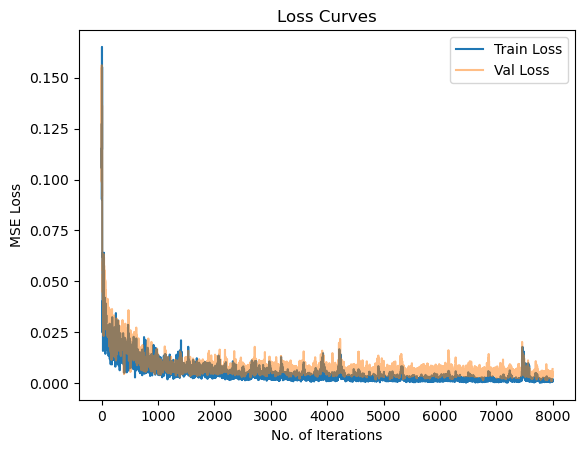

In [ ]:
num = 0


print (f"Number of epochs:{epochs}, \t Train and Validation batch_size = {batch_size},\t Test batch_size = {bs}")
print("Minimum Validation Loss: ",min_val_loss, "\nMinimum Train Loss: ", min_train_loss,  "\nTest Loss: ",Test_error)
print("========================================================")
print(f"Time taken for Training = {round(tok-tik, 3)}s")
plt.plot(train_loss_arr[num:], label = "Train Loss", alpha = 1)
plt.plot(val_loss_arr[num:], label = "Val Loss", alpha = 0.5)
plt.legend()
plt.title("Loss Curves")
plt.xlabel("No. of Iterations")
plt.ylabel("MSE Loss")
plt.show()

# **Predicring the similarities**

In [ ]:
# Predicring the similarities for the whole dataset one more time after the model is trained:
# These similarities will be used is input for the next step (clustering)

Total_error, predicted_sim_total = evaluate(Dataset_loader , model, loss_criterion)
print(Total_error)
print(len(predicted_sim_total[0]))
predicted_similarities = [j for sub in predicted_sim_total for j in sub]
print(len(predicted_similarities))

Matrix_predicted_similarities = np.reshape(predicted_similarities, (20, 20))
print(Matrix_predicted_similarities)
similarity_matrix = Matrix_predicted_similarities

0.0032930871844291686
1
400
[[0.99139798 0.72623396 0.82091141 0.95497161 0.82463914 0.8376621
  0.87314165 0.54434574 0.59364384 0.57452404 0.9079079  0.79654127
  0.72388875 0.58255708 0.84388947 0.86655772 0.73353666 0.55908197
  0.8203246  0.81458718]
 [0.67326403 0.66216719 0.79122835 0.48484483 0.67270768 0.80650622
  0.49006504 0.57856095 0.92069572 0.86964333 0.93546253 0.76875257
  0.73051095 0.67313051 0.4774296  0.88698012 0.88821644 0.79183036
  0.76855808 0.70110947]
 [0.74610752 0.47186732 0.73792827 0.88820821 0.92604089 0.63590091
  0.49816889 0.45540938 0.47186732 0.49232504 0.63590091 0.63226646
  0.45540938 0.73728466 0.92069572 0.99887711 0.79933727 0.77937955
  0.91208637 0.72042453]
 [0.66933399 0.72388875 0.886415   0.8119294  0.69734448 0.5821901
  0.65998024 0.73728466 0.79070997 0.89172208 0.95070291 0.88111818
  0.64690638 0.87458098 0.77949965 0.65998024 0.67481869 0.73830664
  0.99139798 0.76867491]
 [0.87314165 0.54921907 0.96957815 0.6356858  0.63548309 0

# Part 2: Clustering the users (Diversity method)

In [ ]:
# Clustering with Diversity

def calculate_diversity(similarity_matrix, X):
    """
    Calculate the diversity of each user not in the cluster X
    based on the similarity kernel matrix.

    Parameters:
    - X: Current cluster

    Returns:
    - diversity: Array containing the diversity values for each user not in X
    """
    num_users = len(similarity_matrix)
    L_X = similarity_matrix[X][:, X]
    L_X_inv = np.linalg.inv(L_X)
    diversity = np.zeros(num_users)
    for i in range(num_users):
        if i not in X:
            L_i_X = similarity_matrix[i][X]
            L_i_i = similarity_matrix[i][i]
            diversity[i] = np.log(L_i_i - np.dot(L_i_X, np.dot(L_X_inv, L_i_X)))
    return diversity


In [ ]:

def cluster_users(similarity_matrix, threshold=0, max_users=None):
    """
    Cluster users based on the inverse of diversity in a Determinantal Point Process (DPP) kernel matrix.

    Parameters:
    - threshold: Diversity threshold to stop clustering (default: 0)
    - max_users: Maximum number of users in a cluster (default: None)

    Returns:
    - clusters: List of clusters, where each cluster is represented as a list of user indices
    """
    num_users = len(similarity_matrix)
    clusters = []
    remaining_users = list(range(num_users))
    print(max_users)
    while remaining_users:
        current_cluster = []
        # Calculate diversity for each user not in any cluster
        diversity = calculate_diversity(similarity_matrix, [])
        # Find the user with the least diversity scorev and add it to a new cluster
        next_user_idx = np.argmin(diversity[remaining_users])
        next_user = remaining_users[next_user_idx]
        current_cluster.append(next_user)
        remaining_users.pop(next_user_idx)

        while True:
            # Calculate diversity for each user not in the current cluster
            diversity = calculate_diversity(similarity_matrix, current_cluster)
            # Check if remaining_users is empty before finding next_user
            if remaining_users:
                next_user_idx = np.argmin(diversity[remaining_users])
                next_user = remaining_users[next_user_idx]
                remaining_users.pop(next_user_idx)
            else:
                break
            # Add the next_user to the current cluster
            current_cluster.append(next_user)
            # Check stopping conditions
            print(diversity[next_user])
            if (diversity[next_user] >= threshold) or (max_users is not None and len(current_cluster) >= max_users):
                clusters.append(current_cluster)
                break
    return clusters


clusters = cluster_users(similarity_matrix, threshold=1.0, max_users=6)
print("Clusters:", clusters)


6
nan
nan
nan
nan
nan
nan
nan
-3.5981368877131246
-4.436060097495355
nan
nan
nan
nan
nan
nan
nan
Clusters: [[17, 1, 8, 10, 15, 16], [14, 0, 4, 5, 11, 3], [18, 2, 6, 7, 13, 19]]


/var/folders/3n/n3f4n2gn3hg1xvkglkjfg8wh0000gq/T/ipykernel_55012/998826552.py:22: RuntimeWarning: invalid value encountered in log
  diversity[i] = np.log(L_i_i - np.dot(L_i_X, np.dot(L_X_inv, L_i_X)))


In [ ]:
# Saving the groups ids as a csv file:

file_path = "6.SimGNN_groupMambersIDs_FoodData_DiversityClustering.csv"

# Write the 2D list to the CSV file
with open(file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    for row in clusters:
        csv_writer.writerow(row)

print("CSV file saved successfully.")

CSV file saved successfully.
